<a href="https://colab.research.google.com/github/pginjupalli/Verizon-EnergyPriceForecasting/blob/main/Final_Verizon_2_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 0: Necessary Imports**
Here, we will import the required Python libraries and load our dataset.

In [ ]:
# Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Getting the CSV file from Google Drive

from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/electricity_prices.csv', 'r') as f:
  df = pd.read_csv(f)

Mounted at /content/drive


# **Part 1: Exploratory Data Analysis (EDA)**
Here, we will explore the data, find any anomalies, and visualize them through plots and graphs.

## Section I: States vs. Regions
Our dataset contains data from 50 different states. However, it also contains data for the different regions.

In [ ]:
unique_states = df['stateDescription'].unique()
print(unique_states)
print()

num_unique_states = df['stateDescription'].nunique()
print("Number of unique states/regions:", num_unique_states)

['Wyoming' 'New England' 'South Carolina' 'South Dakota' 'Tennessee'
 'Texas' 'Utah' 'Vermont' 'Virginia' 'Washington' 'West Virginia'
 'Wisconsin' 'Alabama' 'Louisiana' 'Maine' 'Maryland' 'Massachusetts'
 'Michigan' 'Minnesota' 'Mississippi' 'Middle Atlantic'
 'Pacific Contiguous' 'Pacific Noncontiguous' 'U.S. Total' 'Missouri'
 'Montana' 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico'
 'New York' 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon'
 'Rhode Island' 'Alaska' 'Arizona' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida'
 'East North Central' 'West North Central' 'South Atlantic'
 'East South Central' 'West South Central' 'Mountain' 'Pennsylvania']

Number of unique states/regions: 62


In [ ]:
# Created two new dataframes: geographical areas and states

geographical_areas = ['East North Central', 'West North Central', 'South Atlantic',
                      'East South Central', 'West South Central', 'Mountain', 'U.S. Total',
                      'Middle Atlantic', 'Pacific Contiguous', 'Pacific Noncontiguous',
                      'District of Columbia', 'New England']

df_regions = df[df['stateDescription'].isin(geographical_areas)]


unique_areas = df_regions['stateDescription'].unique()
print(unique_areas)
print()

num_unique_areas = df_regions['stateDescription'].nunique()
print("Number of unique areas:", num_unique_areas)
print()

df_states  = df.drop(df_regions.index)
print(df_states.shape)
print(df_regions.shape)

['New England' 'Middle Atlantic' 'Pacific Contiguous'
 'Pacific Noncontiguous' 'U.S. Total' 'District of Columbia'
 'East North Central' 'West North Central' 'South Atlantic'
 'East South Central' 'West South Central' 'Mountain']

Number of unique areas: 12

(69250, 8)
(16620, 8)


## Section II: Missing Values
Our dataset may contain missing values. Here, we will find them and see how we could fix them.

The first step is to see if there are any null values, and if so, where they're located.

In [ ]:
df_states.isnull().sum()

year                    0
month                   0
stateDescription        0
sectorName              0
customers           21000
price                   0
revenue                 0
sales                   0
dtype: int64

The *customers* column contains 21,000 null values, which makes up a third of the whole data. This amount is too high to ignore to remove, so we must replace it with something else.

To replace it, we must use a value that accuratly represents the data. This could be a mean, median, mode, etc. The one that works best would be the value that, when used to fill the dataset, would maintain the correlation between the *customers* column and the label, *price*.

The correlation between *customers* and other columns like *price*, *revenue*, and *sales* is shown below. We make sure to remove the examples will null values beforehand.

In [ ]:
correlated_columns = ['customers', 'price', 'revenue', 'sales']

df_with_customers = df_states.loc[df_states['customers'].notnull()][correlated_columns]
df_with_customers.corr()

customers     price   revenue     sales
customers   1.000000  0.241719  0.866534  0.805044
price       0.241719  1.000000  0.219229  0.097654
revenue     0.866534  0.219229  1.000000  0.941299
sales       0.805044  0.097654  0.941299  1.000000

Let's try replacing the null values with different statistics and see how the generated correlations compare to those above.

First, we can try the **mode**.

In [ ]:
customers_mode = df_with_customers['customers'].mode()[0]
df_with_mode = df_states.fillna(customers_mode, inplace = False)

df_with_mode[correlated_columns].corr()

customers     price   revenue     sales
customers   1.000000  0.266811  0.767533  0.666223
price       0.266811  1.000000  0.232876  0.101523
revenue     0.767533  0.232876  1.000000  0.937108
sales       0.666223  0.101523  0.937108  1.000000

Next, we can try the **median**.

In [ ]:
customers_median = df_with_customers['customers'].median()
df_with_median = df_states.fillna(customers_median, inplace = False)

df_with_median[correlated_columns].corr()

customers     price   revenue     sales
customers   1.000000  0.256792  0.774643  0.676025
price       0.256792  1.000000  0.232876  0.101523
revenue     0.774643  0.232876  1.000000  0.937108
sales       0.676025  0.101523  0.937108  1.000000

Finally, we can try the **mean**.

In [ ]:
customers_mean = df_with_customers['customers'].mean()
df_with_mean = df_states.fillna(customers_mean, inplace = False)

df_with_mean[correlated_columns].corr()

customers     price   revenue     sales
customers   1.000000  0.212642  0.775483  0.689676
price       0.212642  1.000000  0.232876  0.101523
revenue     0.775483  0.232876  1.000000  0.937108
sales       0.689676  0.101523  0.937108  1.000000

Of all the 3 cases, the data where the mean was used as the replacement has the most similar values to the original correlation. So, we can use the mean as the replacement.

In [ ]:
df_states_new = df_states.fillna(customers_mean)
df_states_new

year  month stateDescription      sectorName     customers  price  \
0      2001      1          Wyoming     all sectors  1.203000e+06   4.31   
1      2001      1          Wyoming      commercial  1.203000e+06   5.13   
2      2001      1          Wyoming      industrial  1.203000e+06   3.26   
3      2001      1          Wyoming           other  1.203000e+06   4.75   
4      2001      1          Wyoming     residential  1.203000e+06   6.01   
...     ...    ...              ...             ...           ...    ...   
85865  2024      1         Arkansas     all sectors  1.717720e+06   9.63   
85866  2024      1         Arkansas      commercial  2.086690e+05  10.26   
85867  2024      1         Arkansas      industrial  3.495100e+04   7.08   
85868  2024      1         Arkansas     residential  1.474098e+06  11.24   
85869  2024      1         Arkansas  transportation  2.000000e+00  12.70   

         revenue       sales  
0       48.12840  1116.17208  
1       12.67978   247.08691  
2       19.60858   602.30484  
3        0.76868    16.17442  
4       15.07136   250.60591  
...          ...         ...  
85865  442.98773  4598.63147  
85866   97.79467   953.02154  
85867  109.92656  1553.02838  
85868  235.26399  2092.56172  
85869    0.00252     0.01984  

[69250 rows x 8 columns]

## Section III: Visualizing The Data
Here, we will use graphs/plots to visualize our data and find any notable trends.

###**SWEETVIZ** : we are installing and importing sweetviz

In [ ]:
!pip install sweetviz
import sweetviz as sv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 18.0 MB/s eta 0:00:00


Next we can generate reports for both the general dataset and the dataset excluding the null values.

                                             |          | [  0%]   00:00 -> (? left)


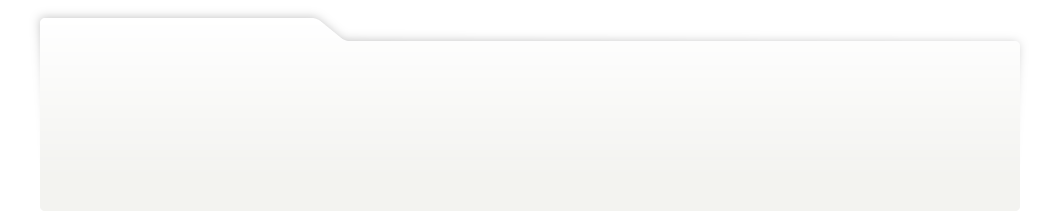
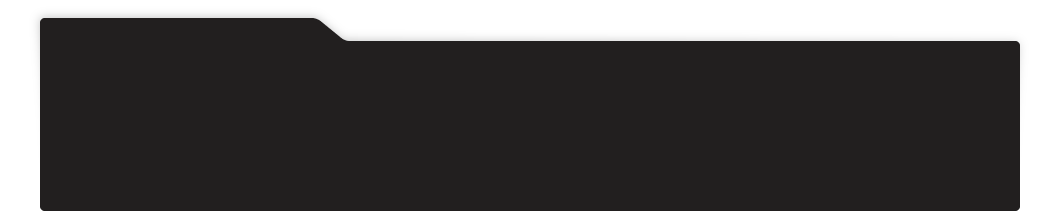
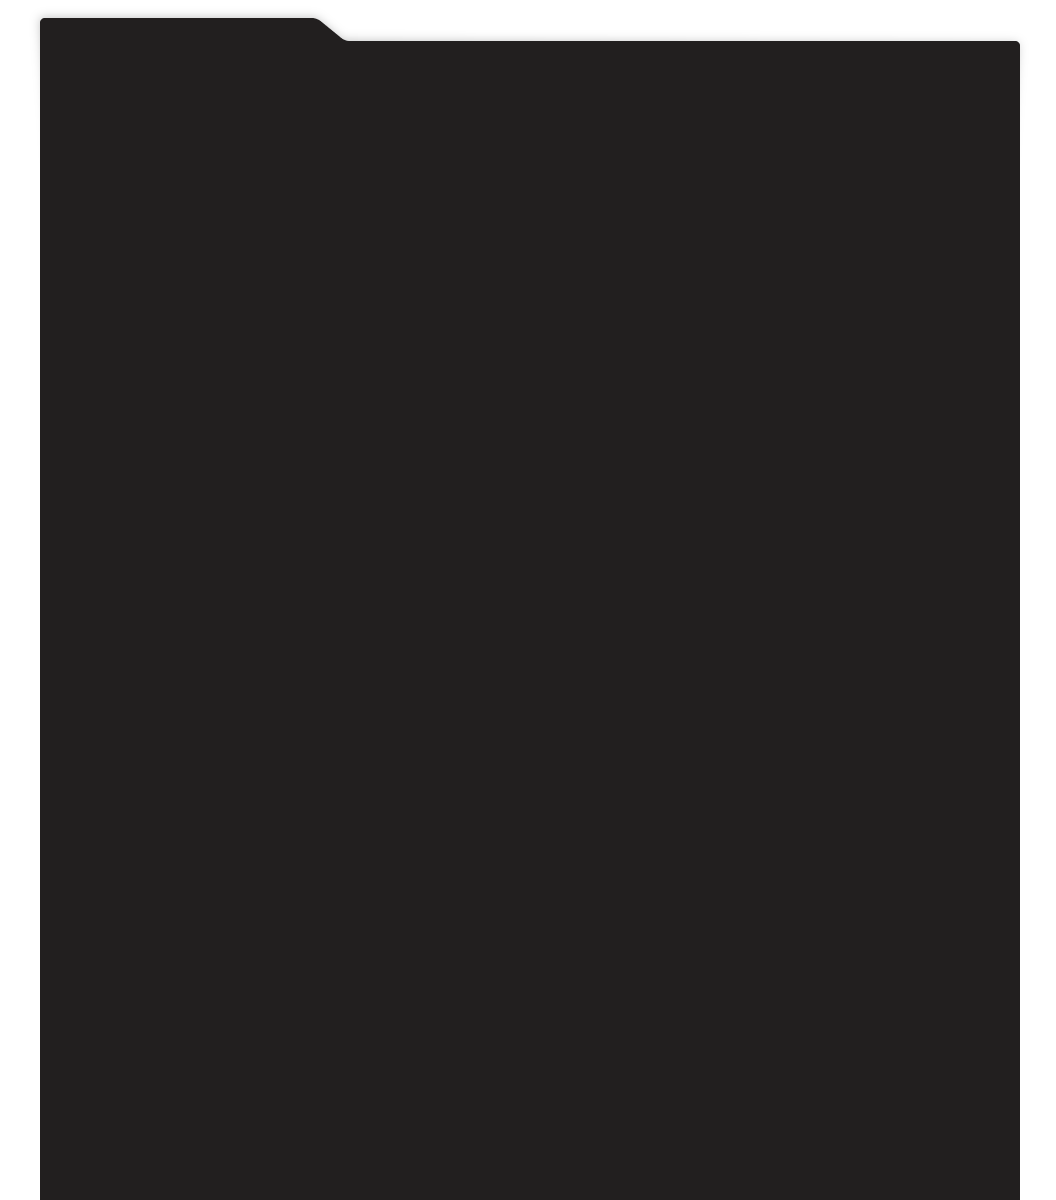
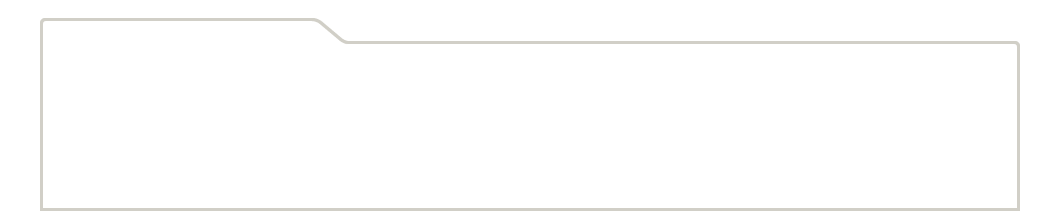
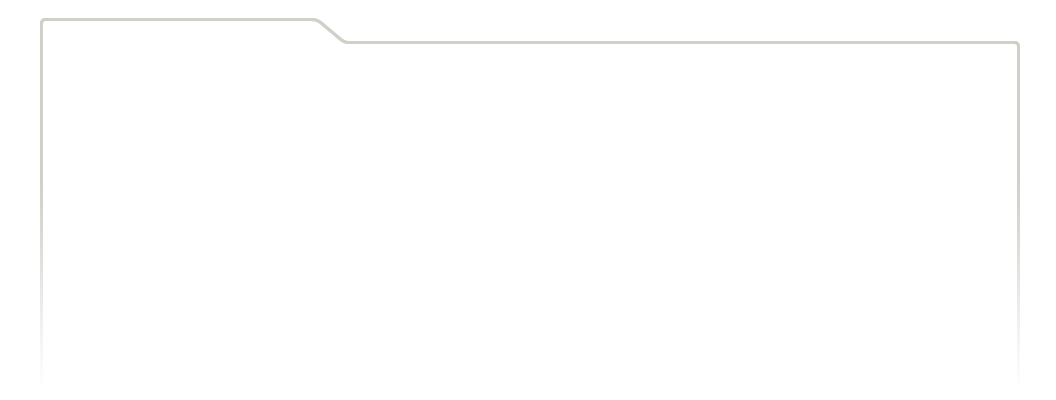
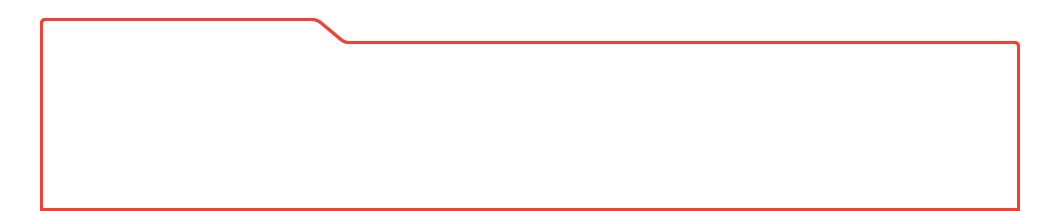
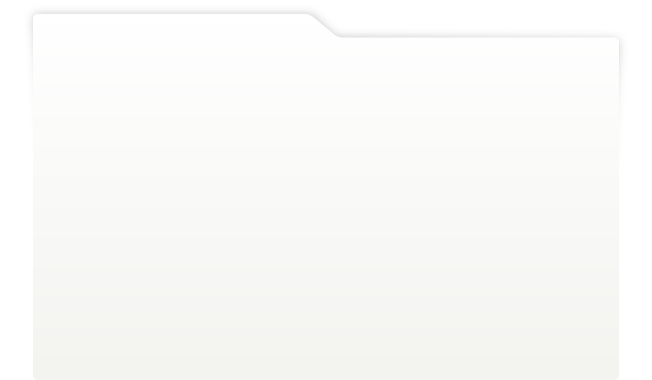
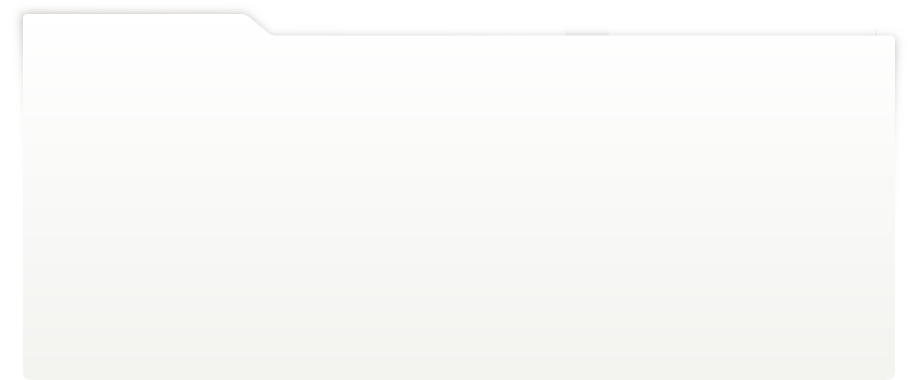
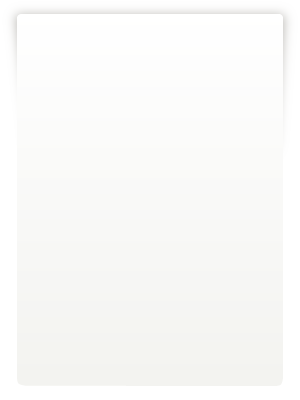
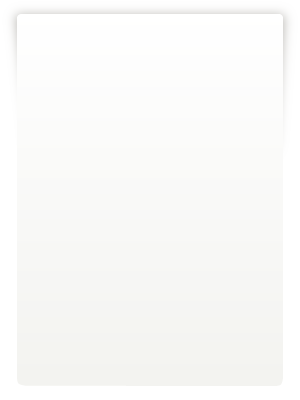
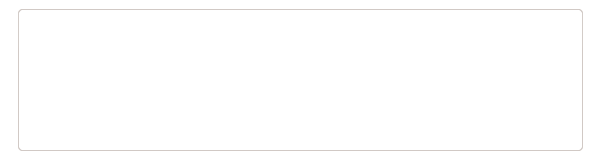
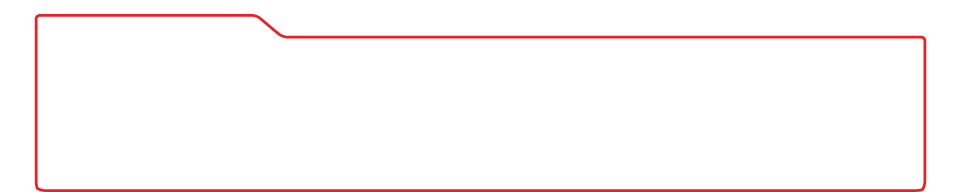
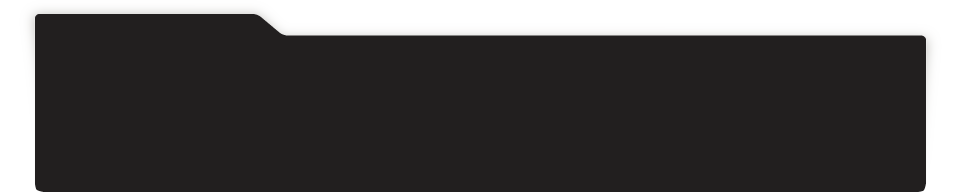
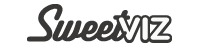
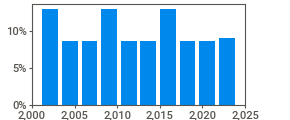
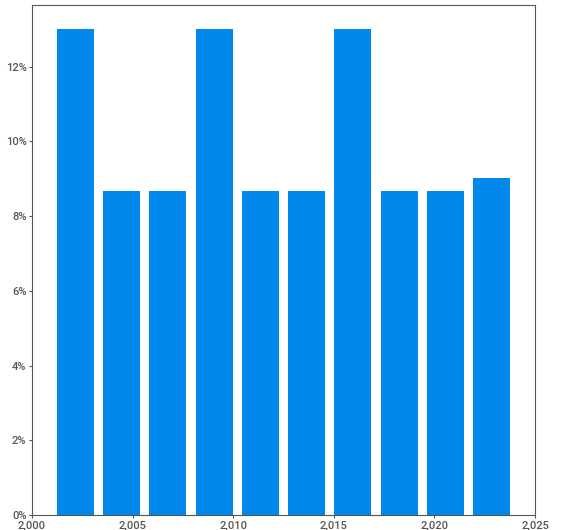
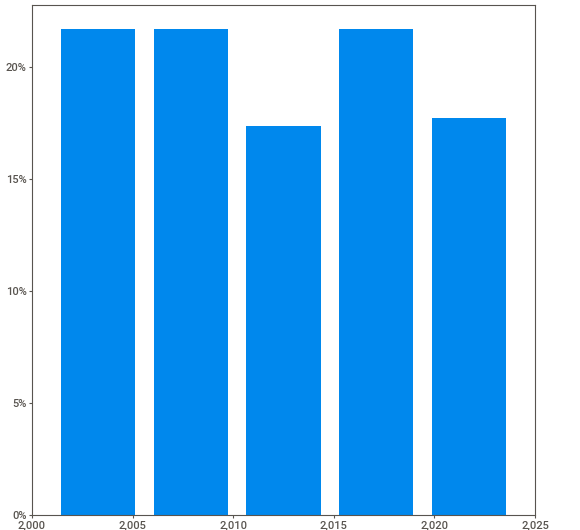
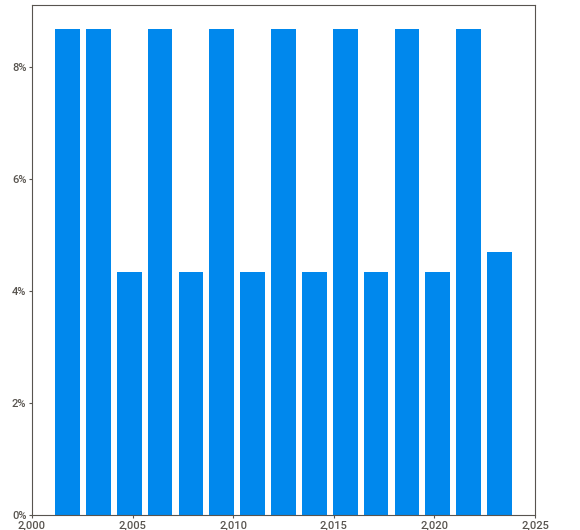
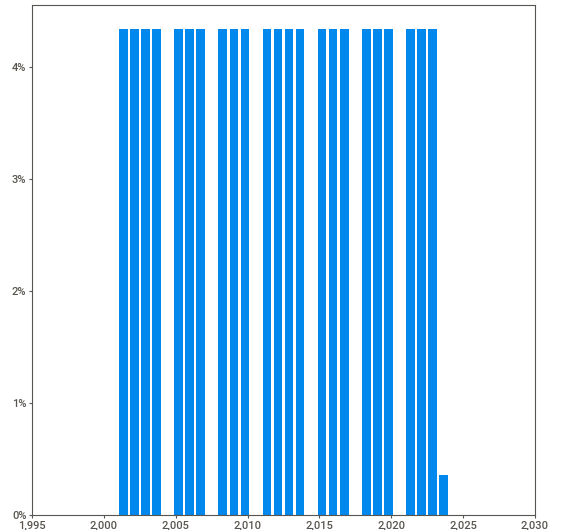
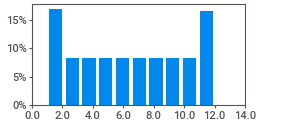
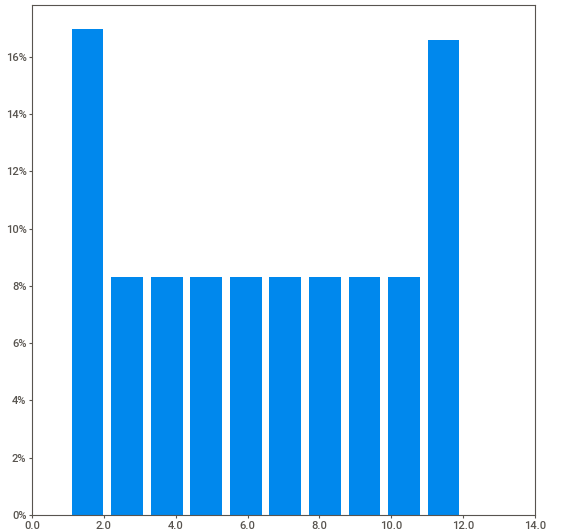
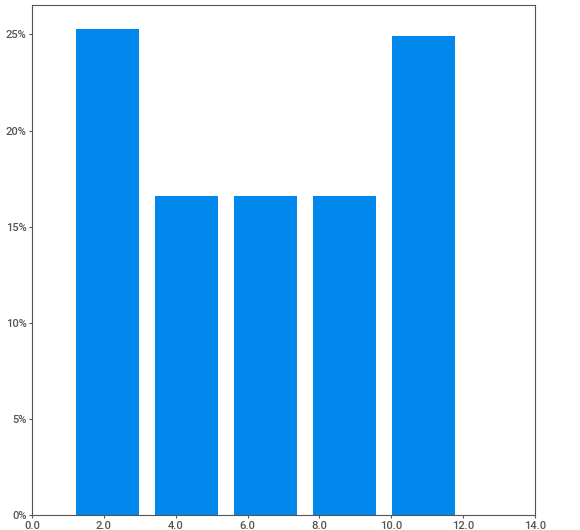
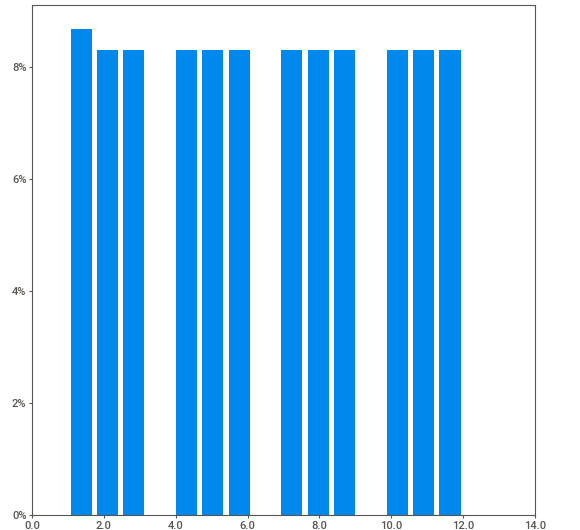
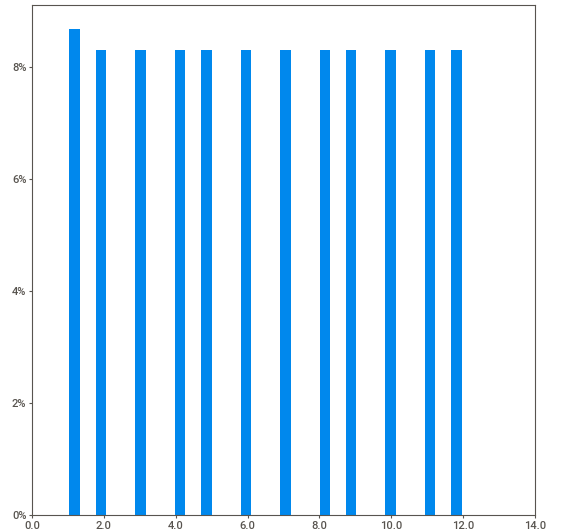
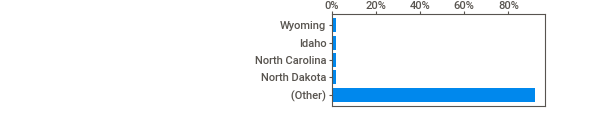
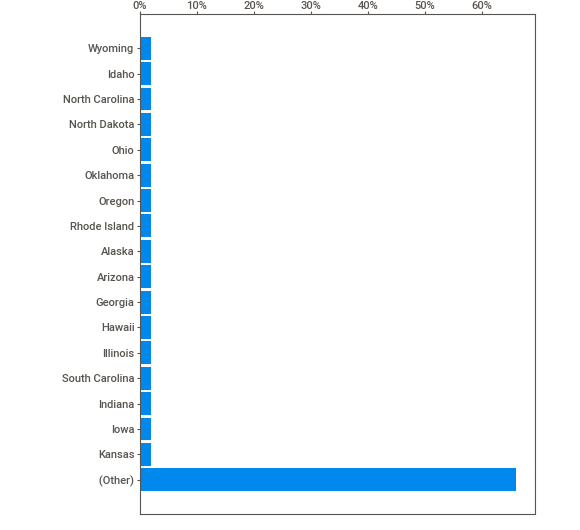
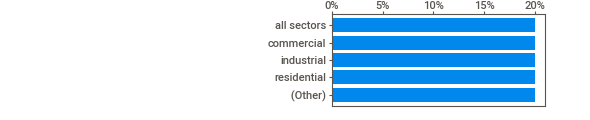
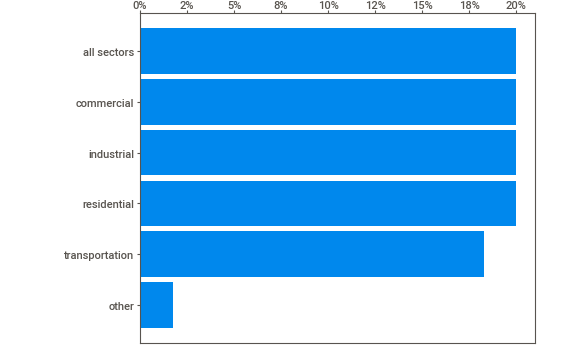
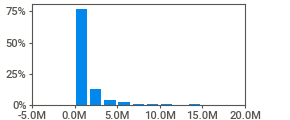
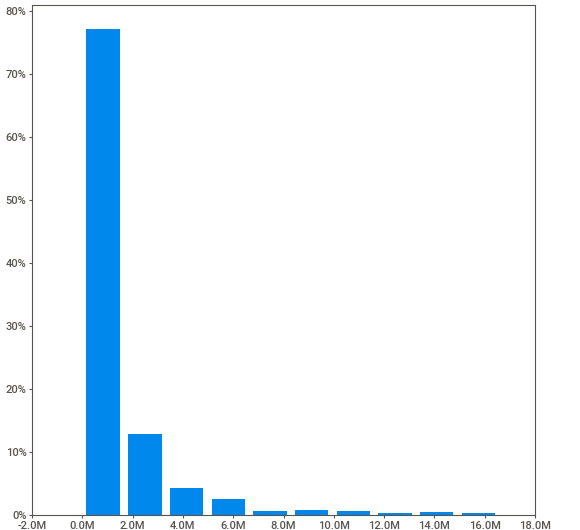
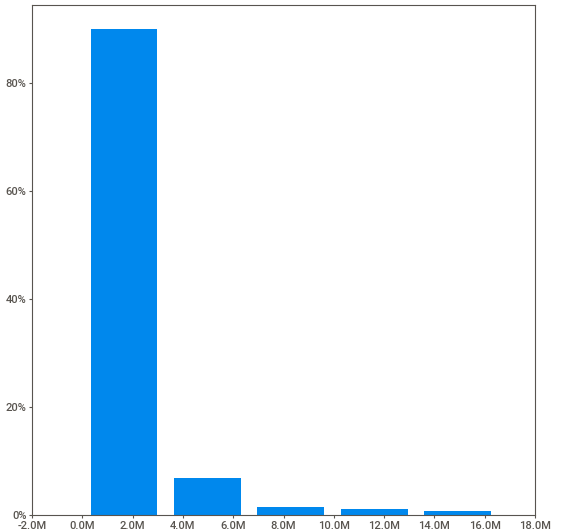
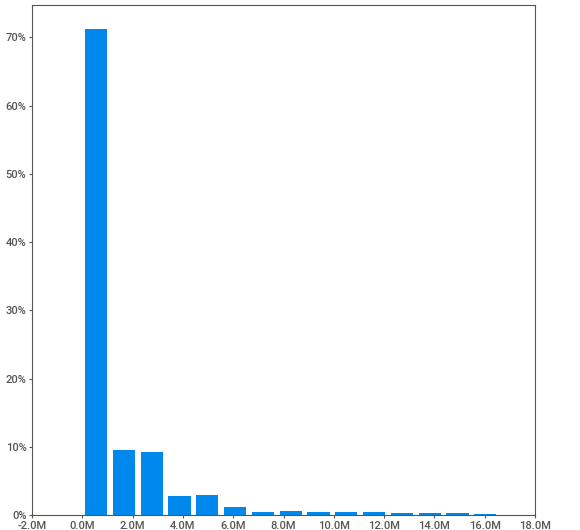
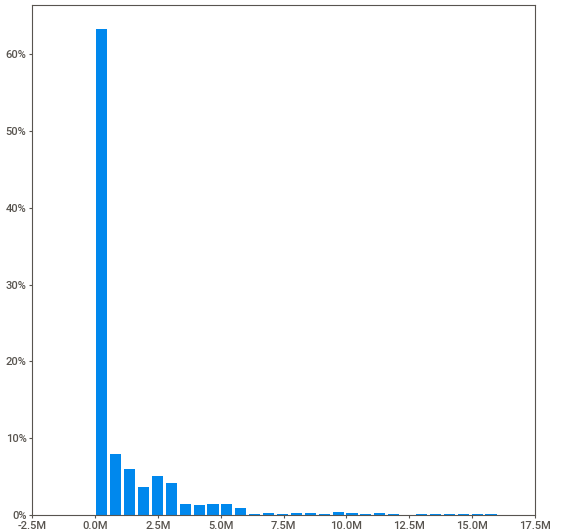
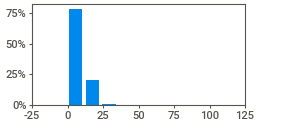
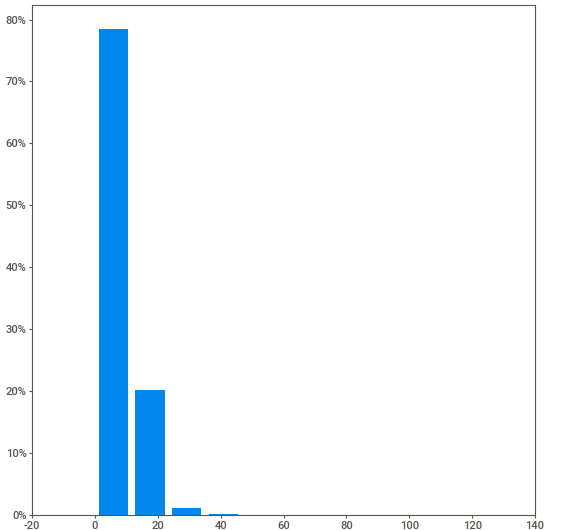
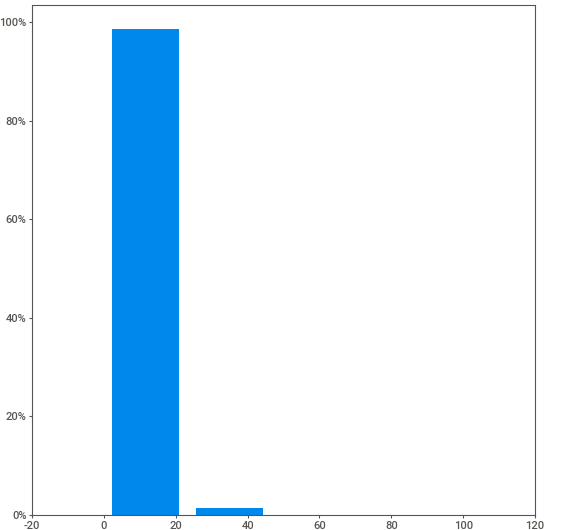
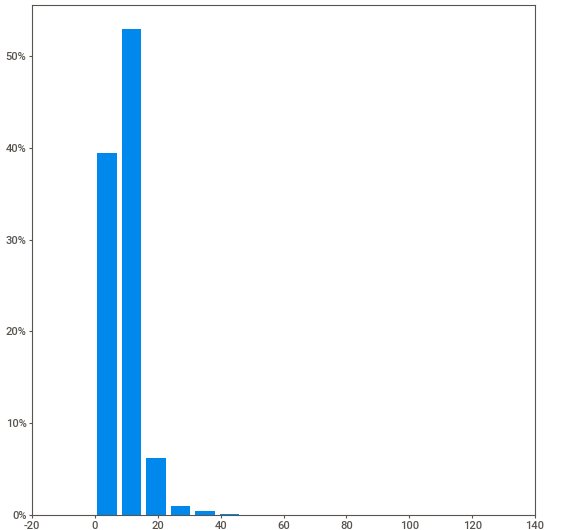
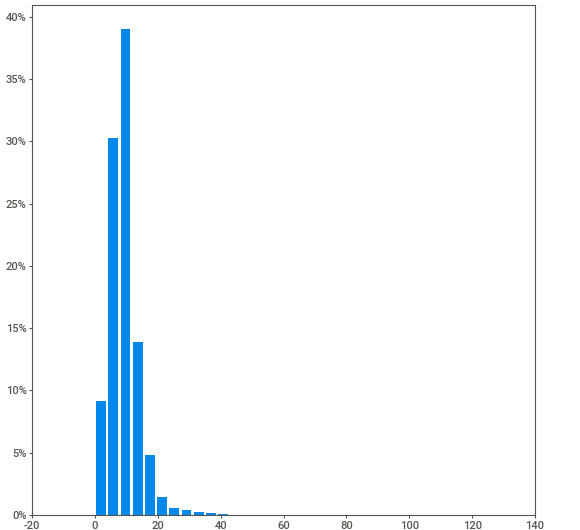
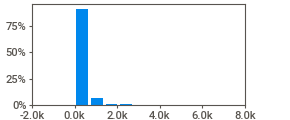
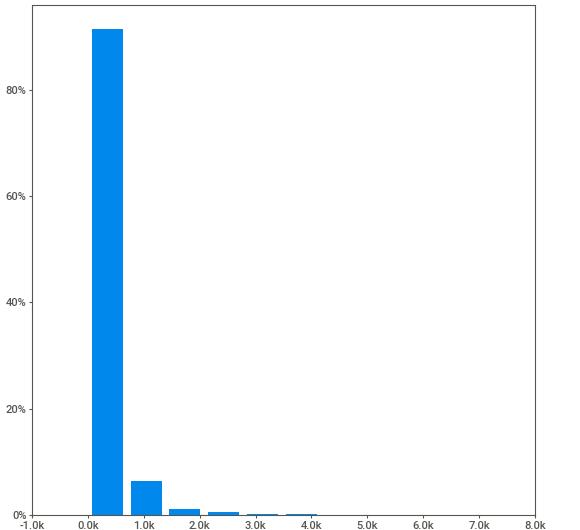
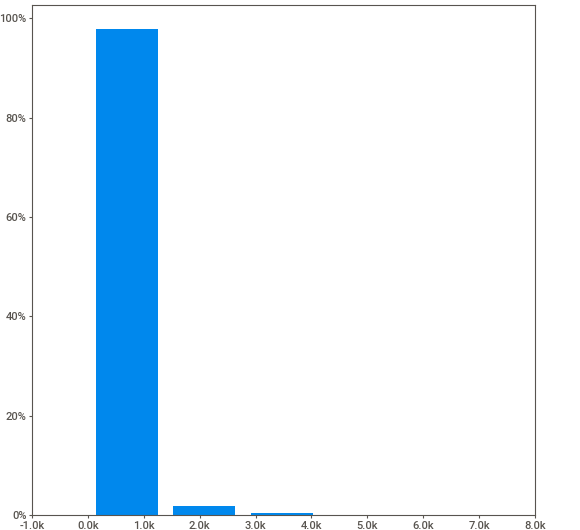
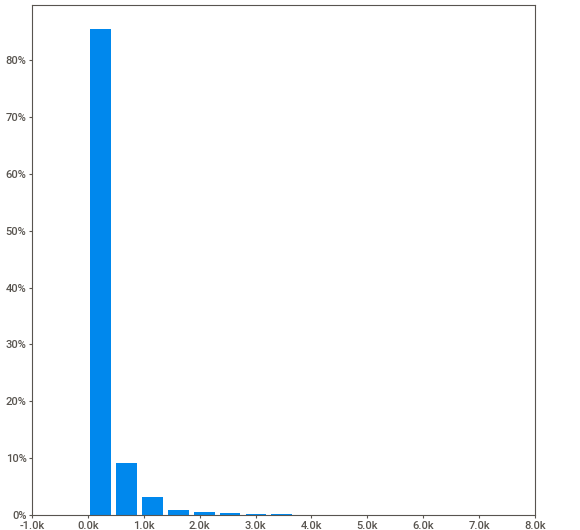
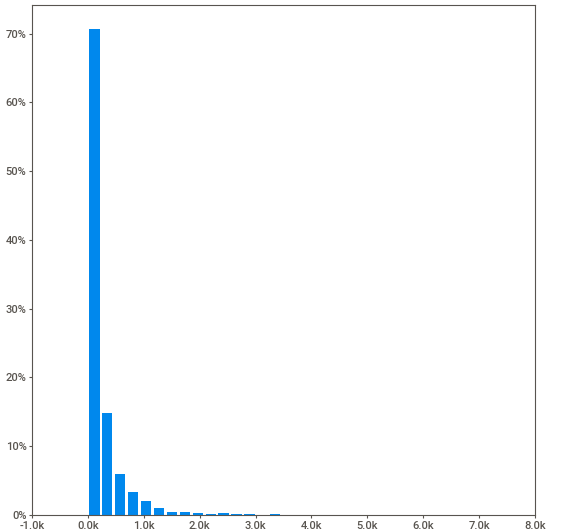
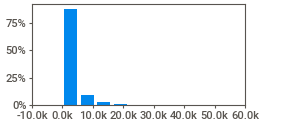
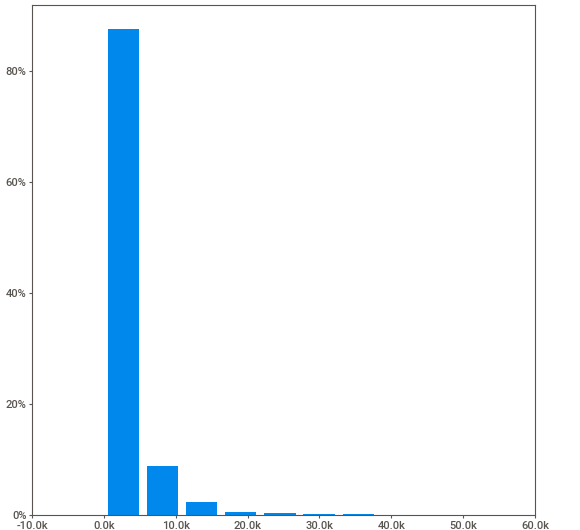
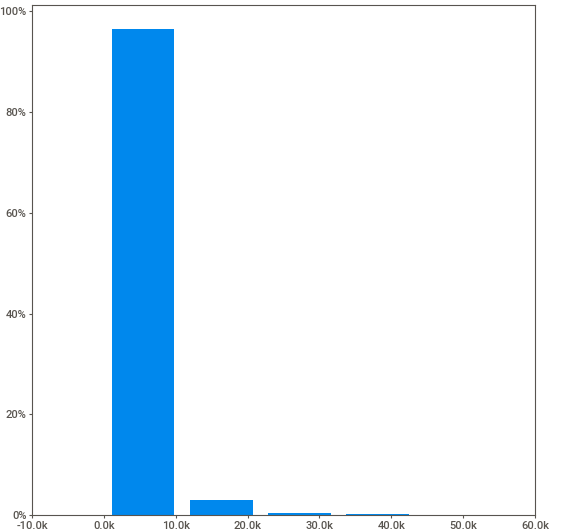
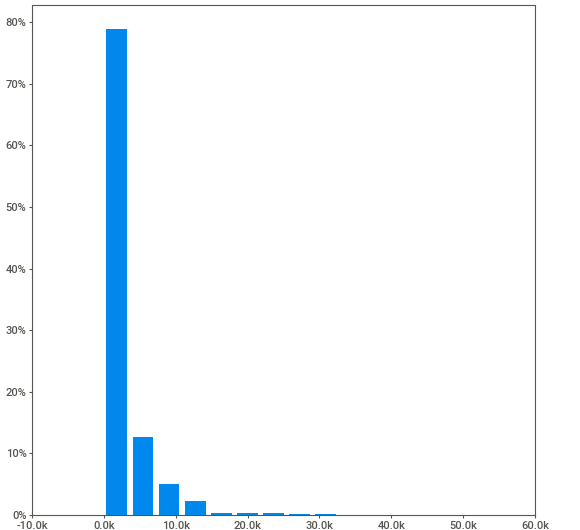
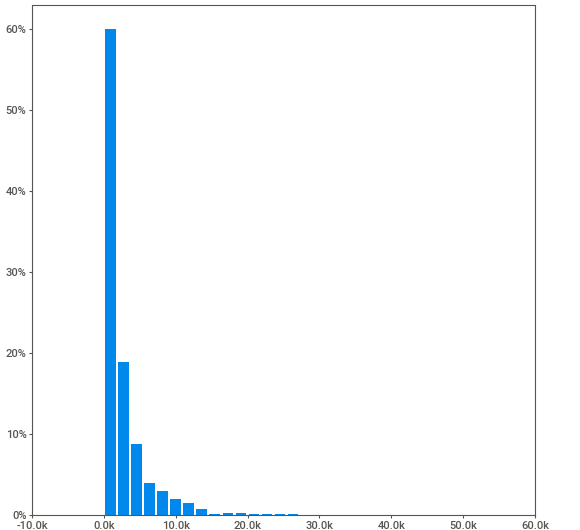
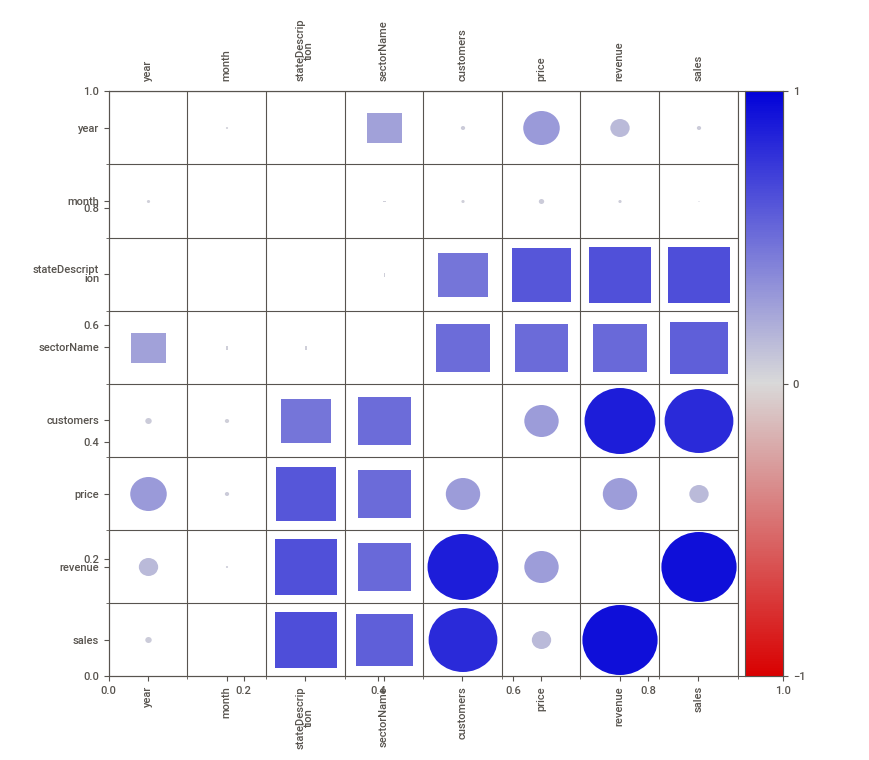
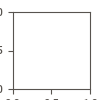

In [ ]:
#for general dataset
general_df = sv.analyze(df_states)
general_df.show_notebook()

                                             |          | [  0%]   00:00 -> (? left)


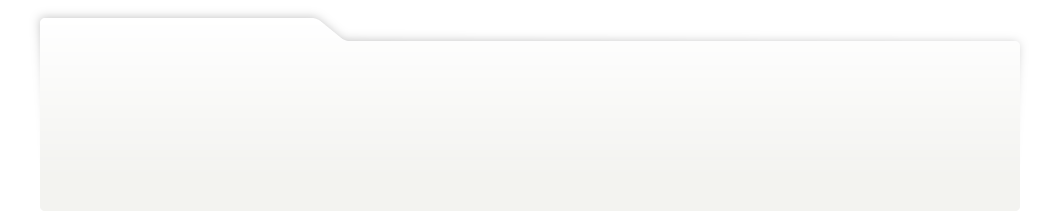
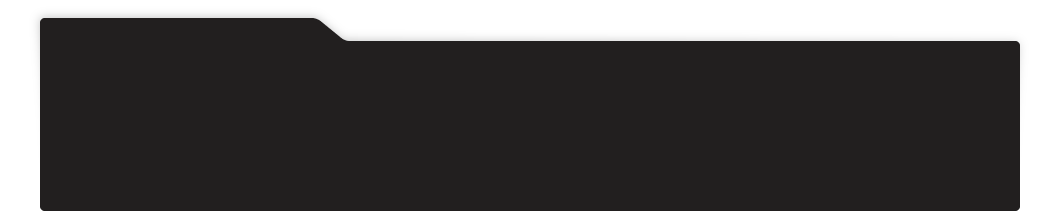
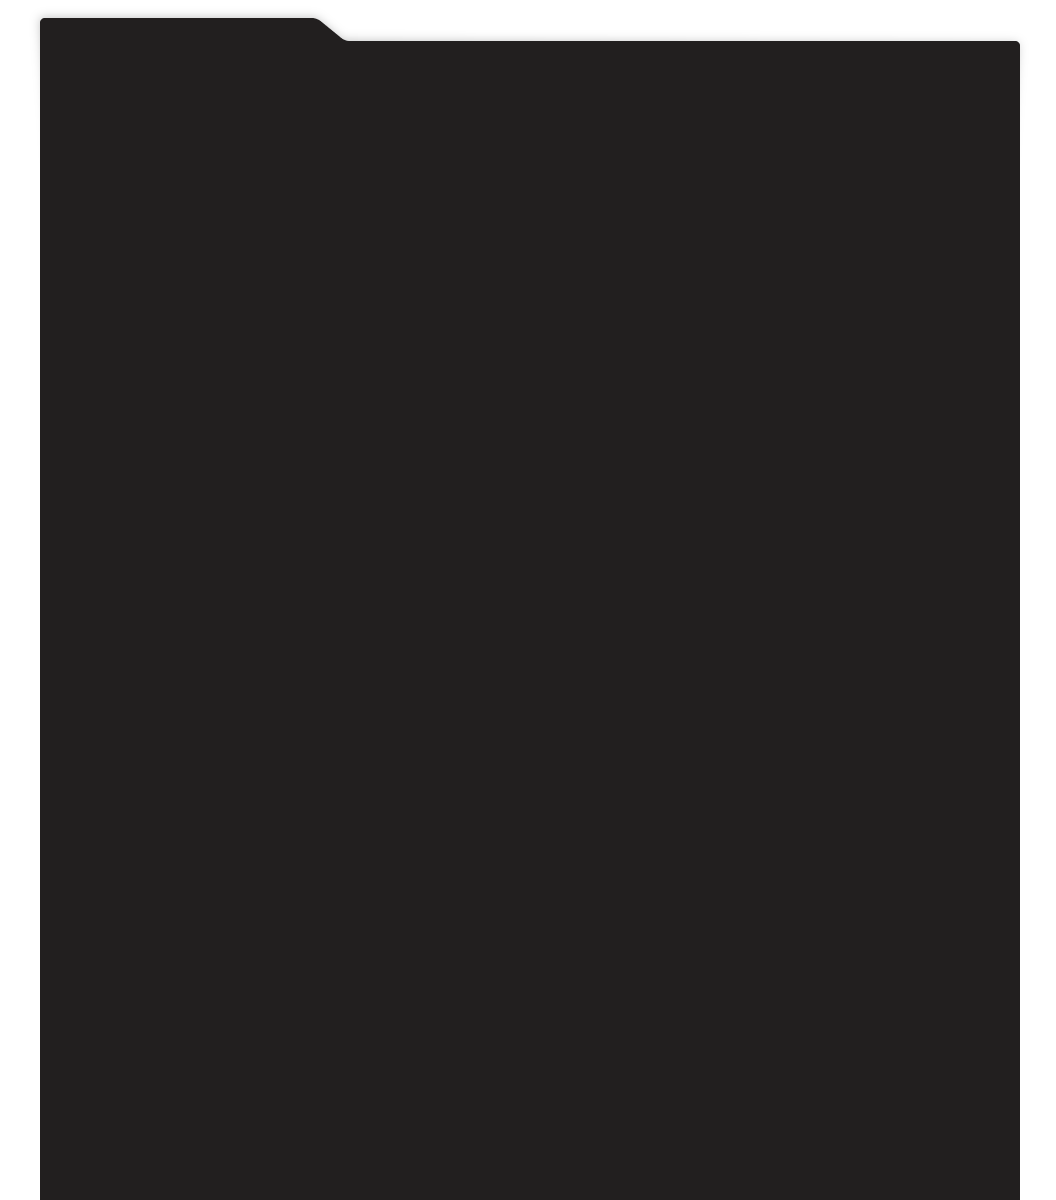
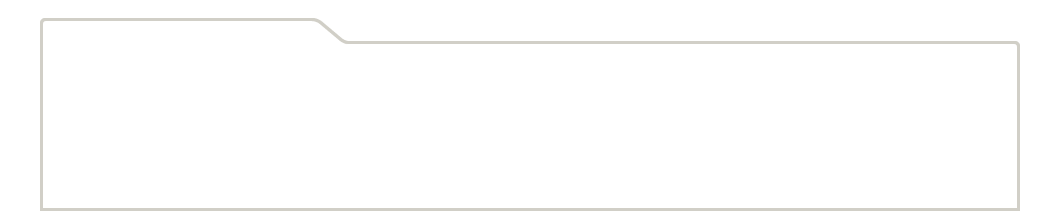
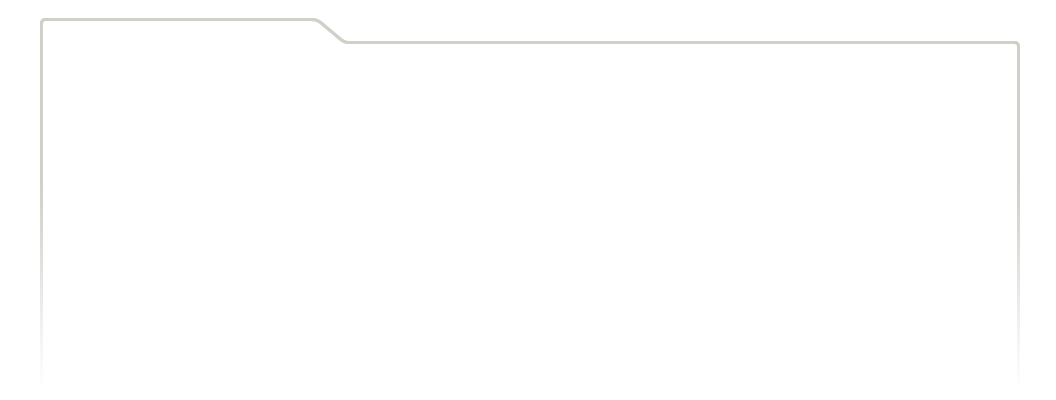
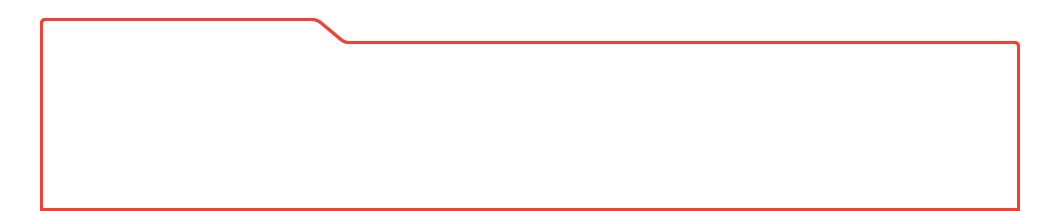
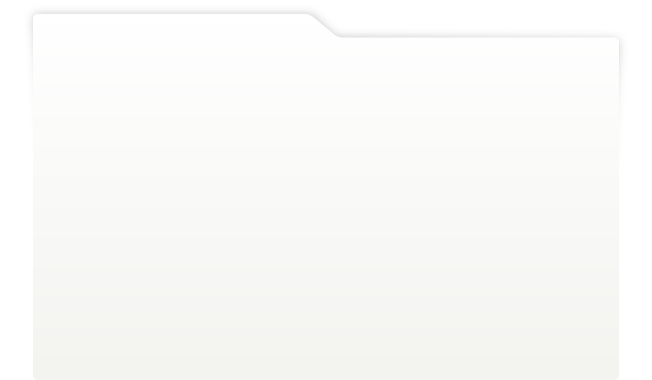
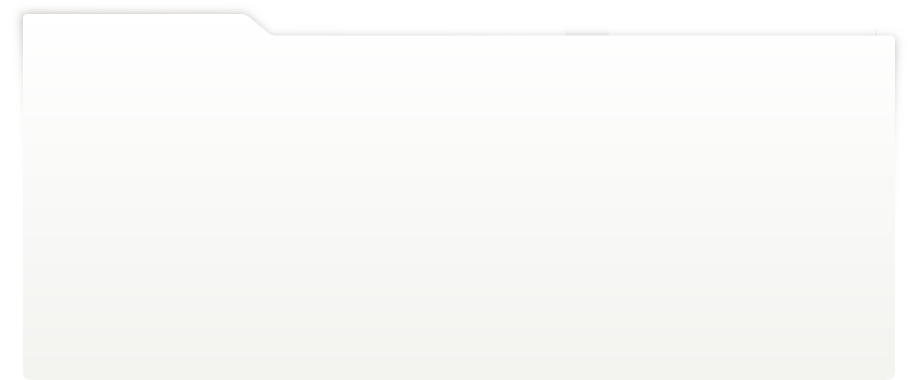
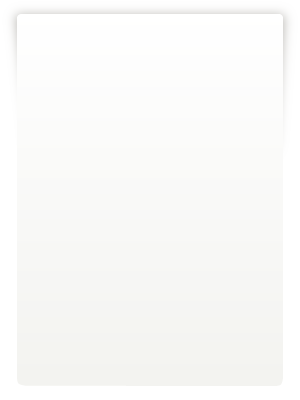
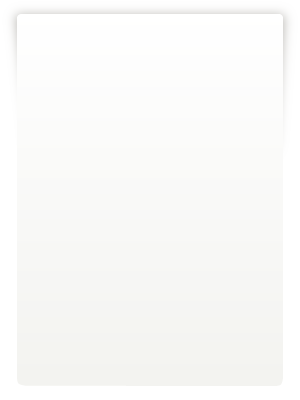
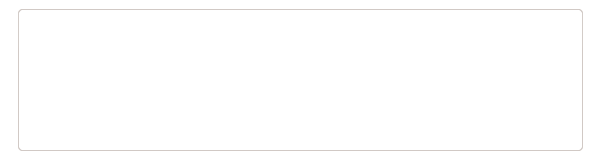
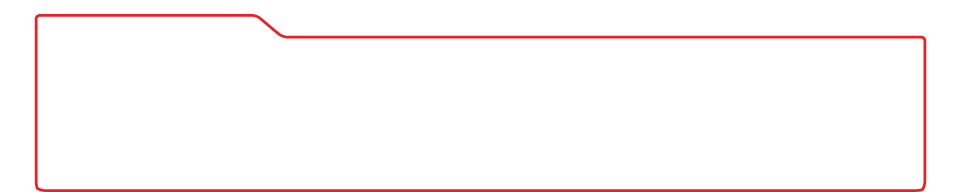
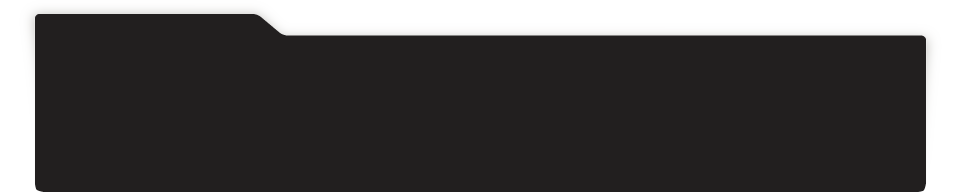
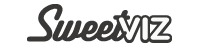
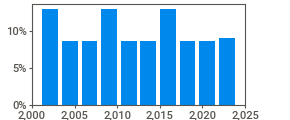
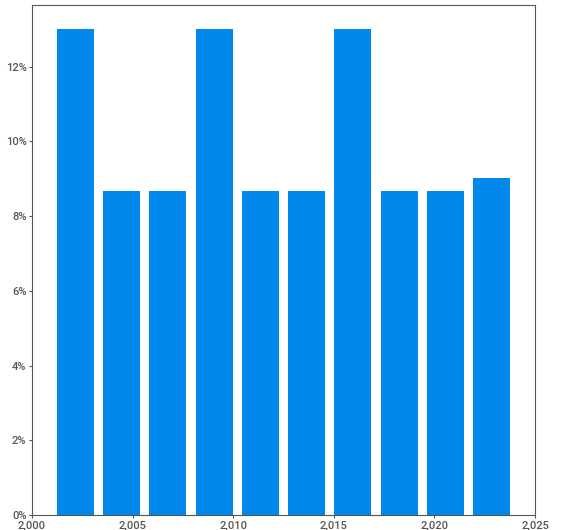
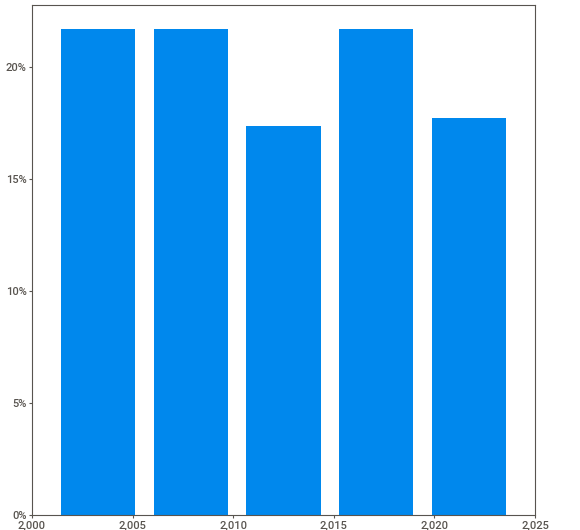
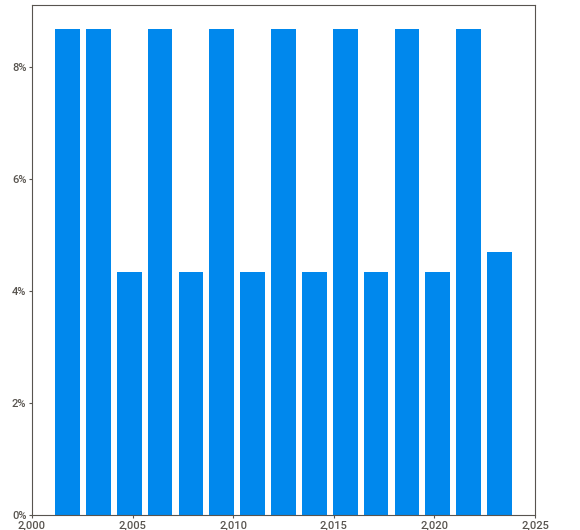
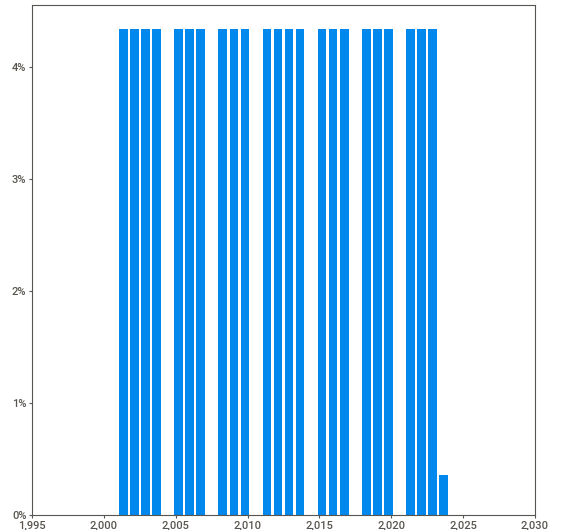
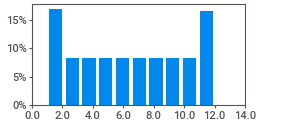
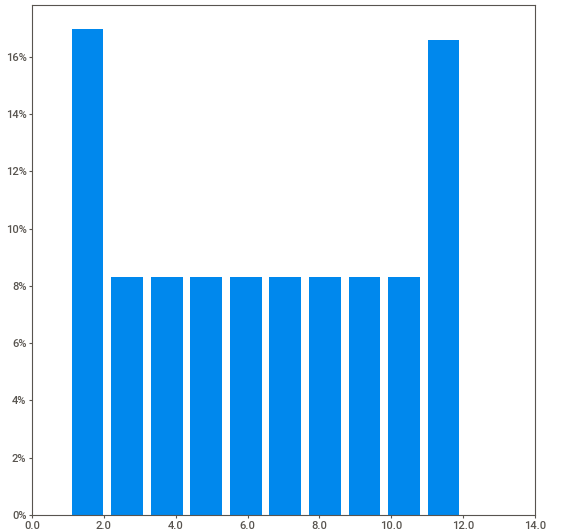
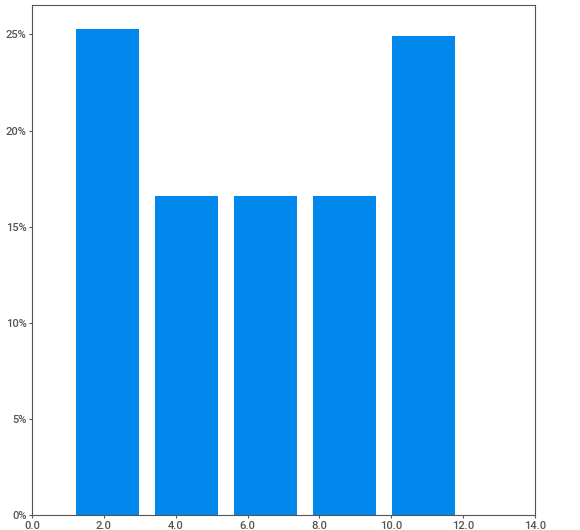
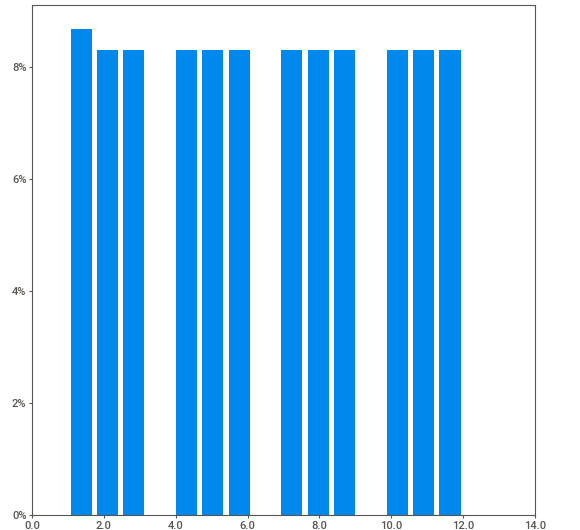
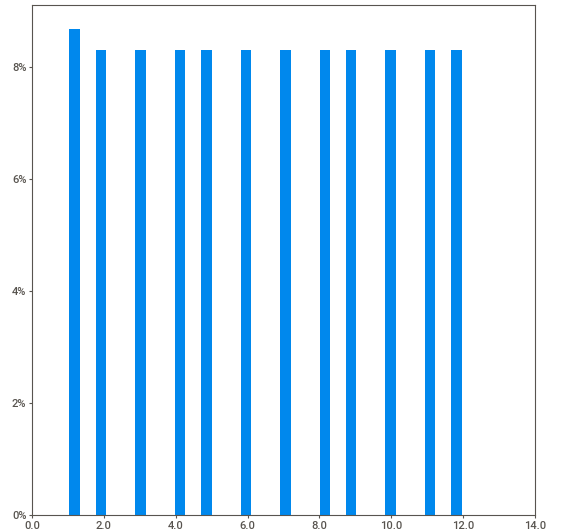
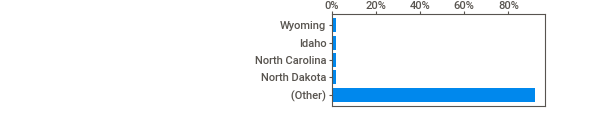
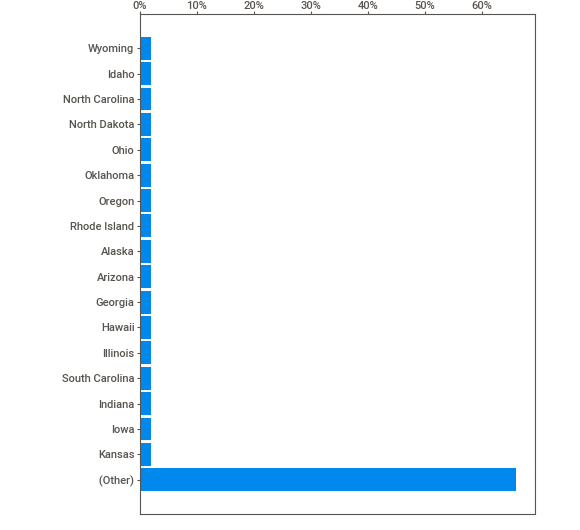
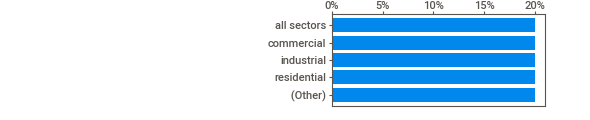
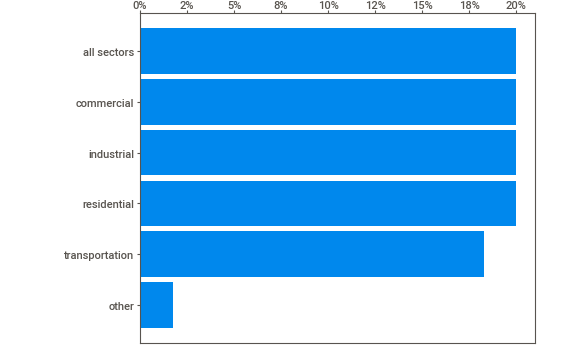
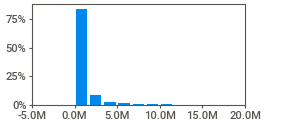
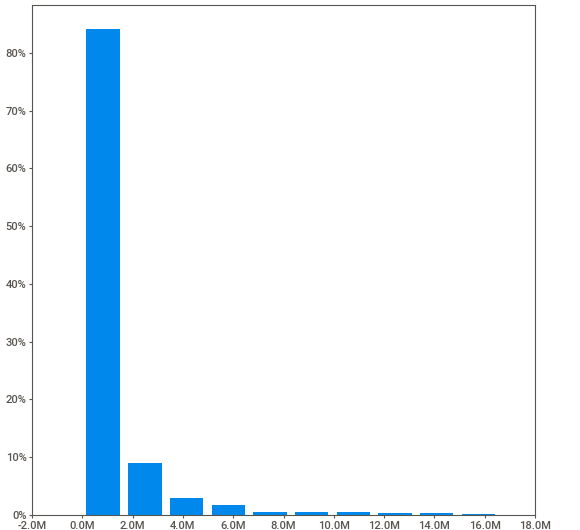
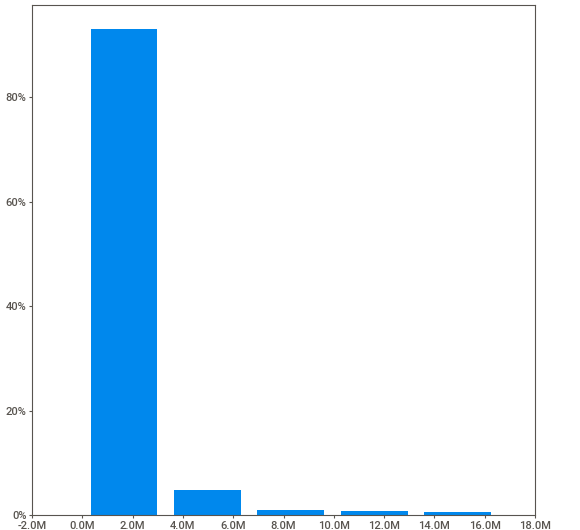
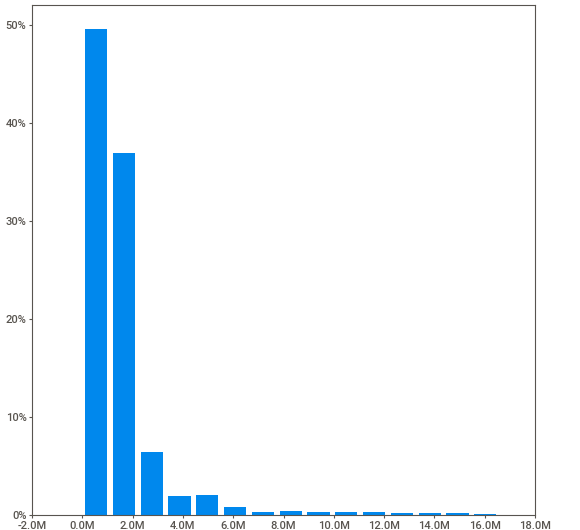
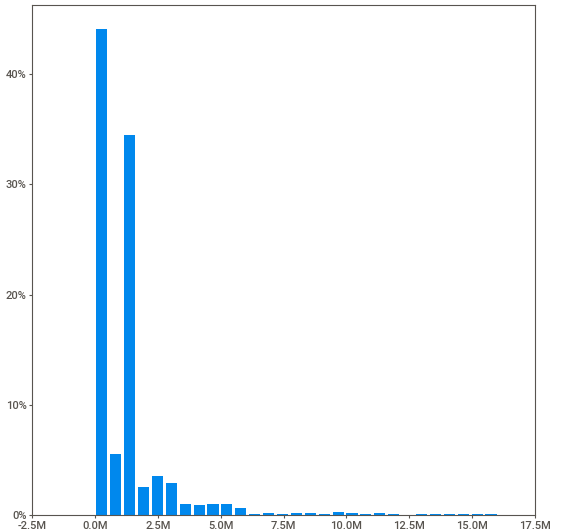
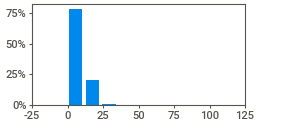
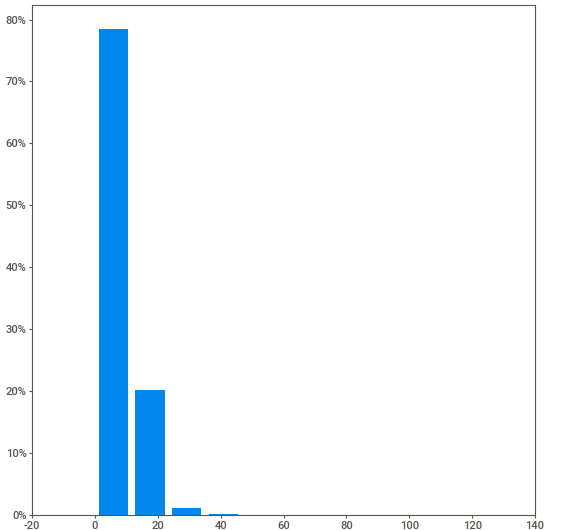
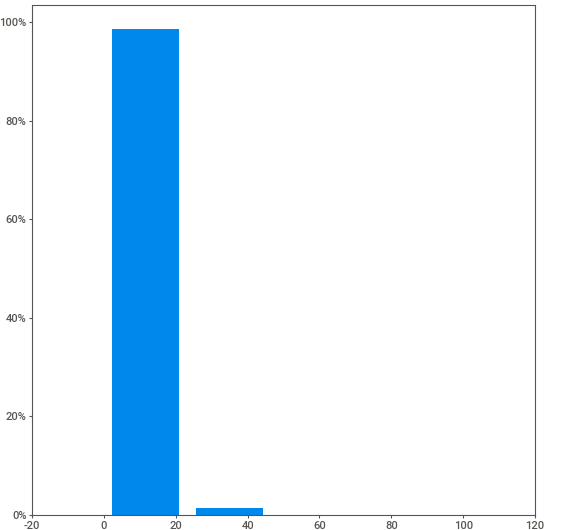
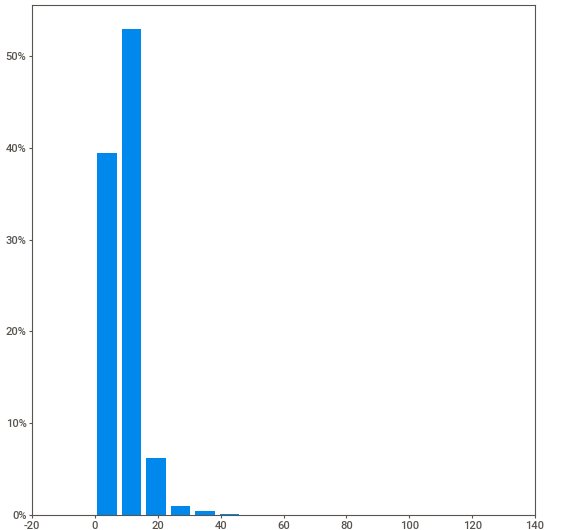
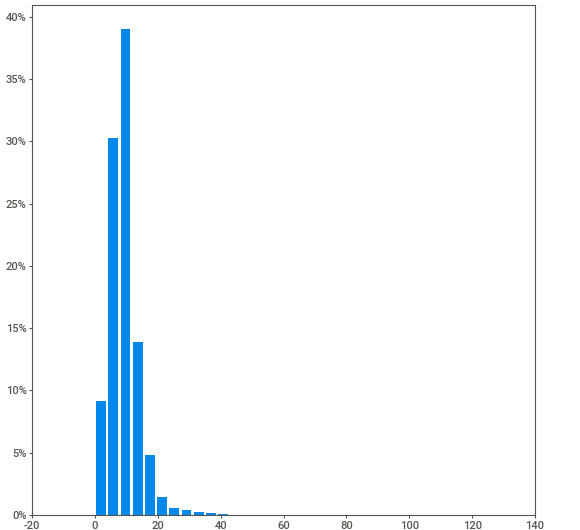
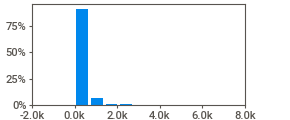
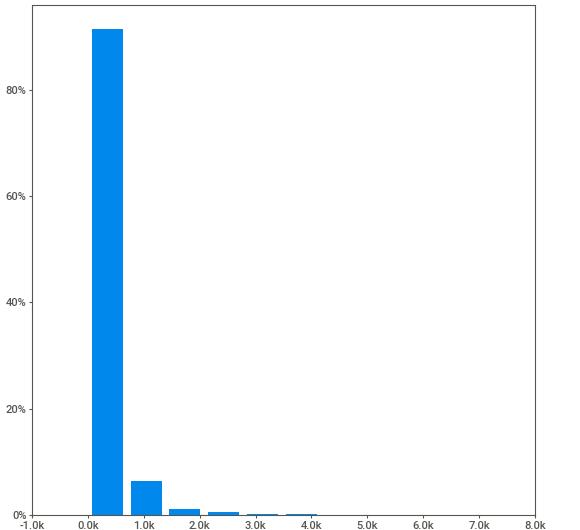
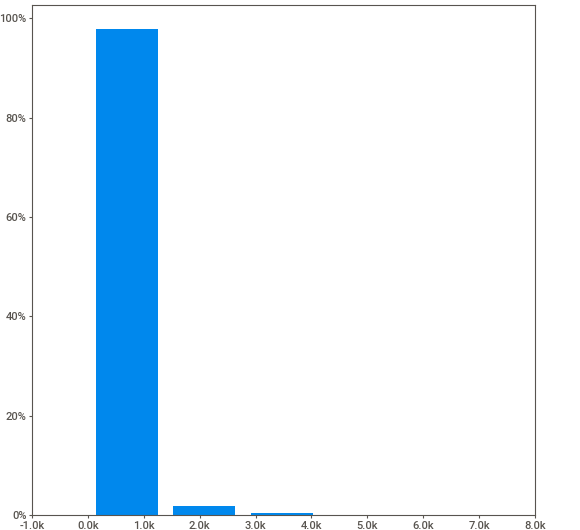
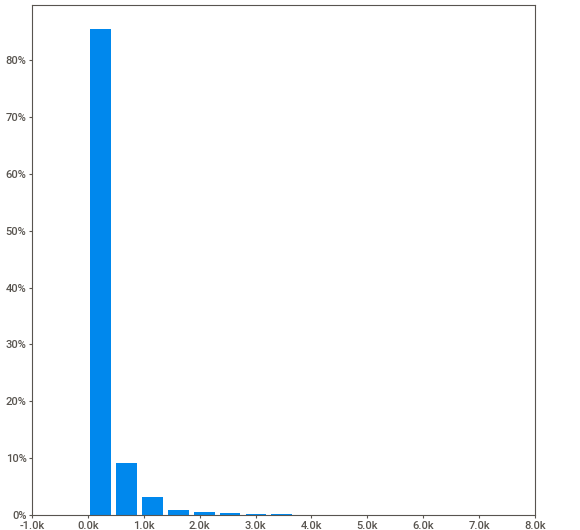
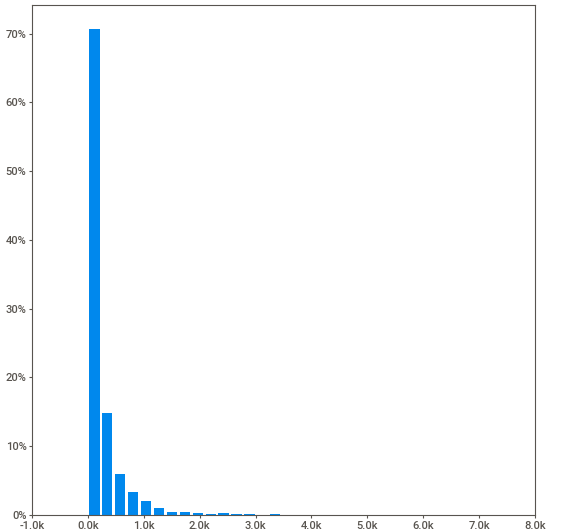
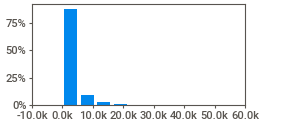
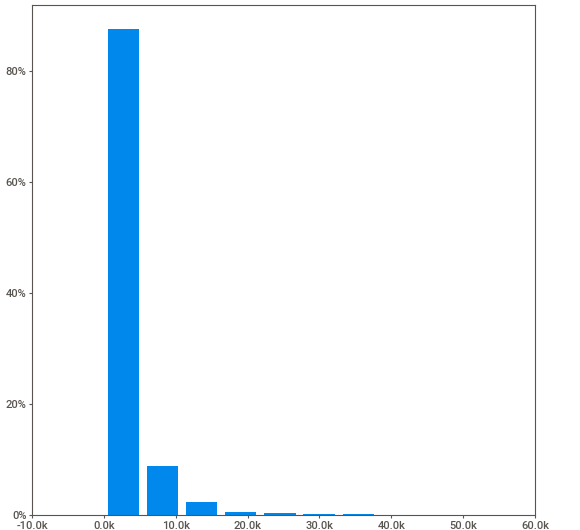
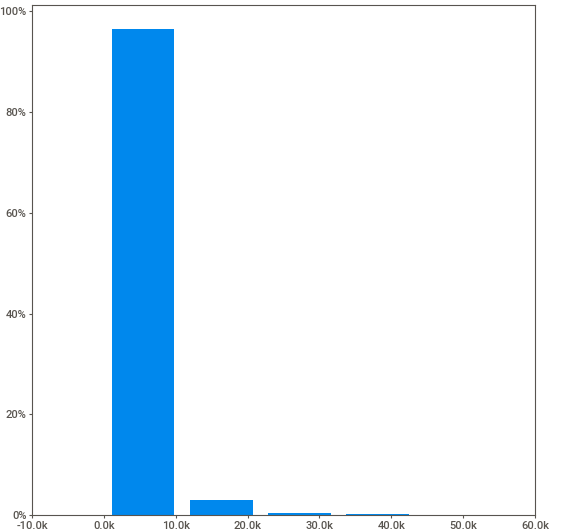
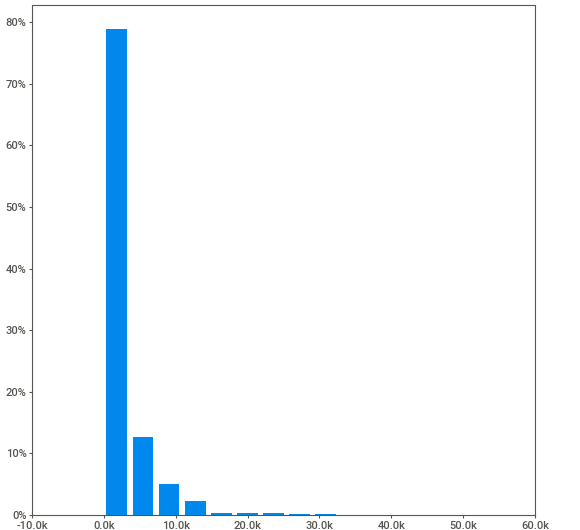
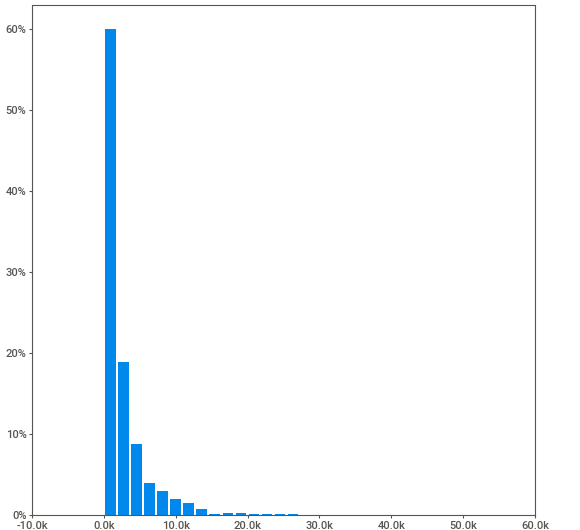
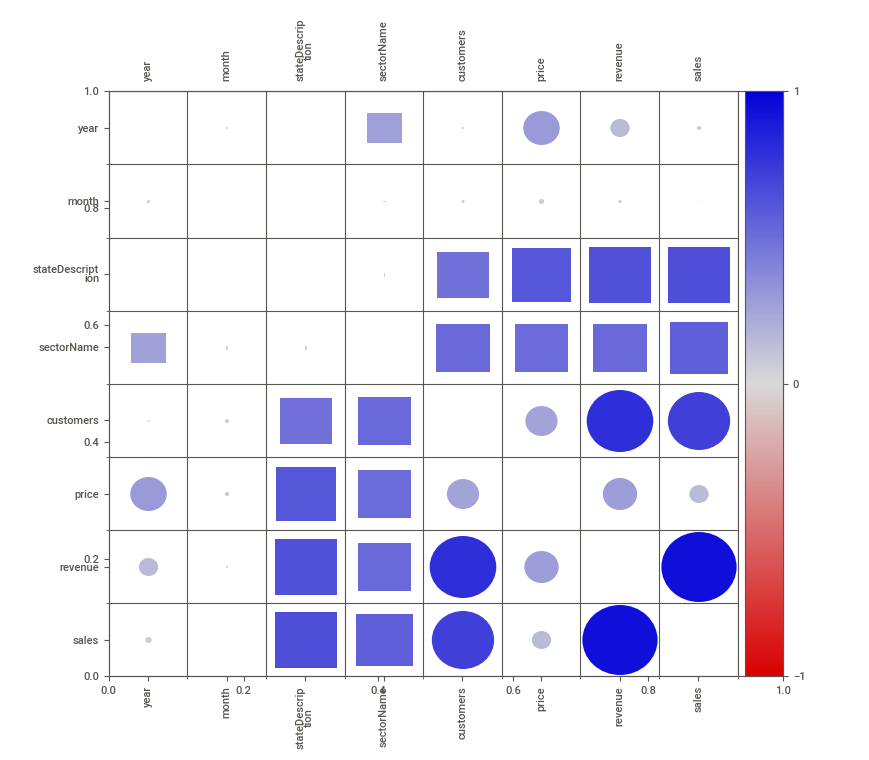
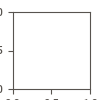

In [ ]:
#for no null values
noNull_df = sv.analyze(df_states_new)
noNull_df.show_notebook()

We can see that the data is distributed pretty well between the sectors (other than other). We are also able to see that modifying the null values did not change the zero values. There are still a lot of data with 0s in columns [customer, revenue, sales, price].

Now, we will generate these sweetviz analysis for each individual state

###**KLIB** : installing and importing klib

In [ ]:
!pip install --upgrade klib
import klib as klib

Next we can try using some of what klib has to visualize the distribution and correlation matrix

Displaying positive correlations. Specify a positive "threshold" to limit the results further.


<Axes: title={'center': 'Feature-correlation (pearson)'}>

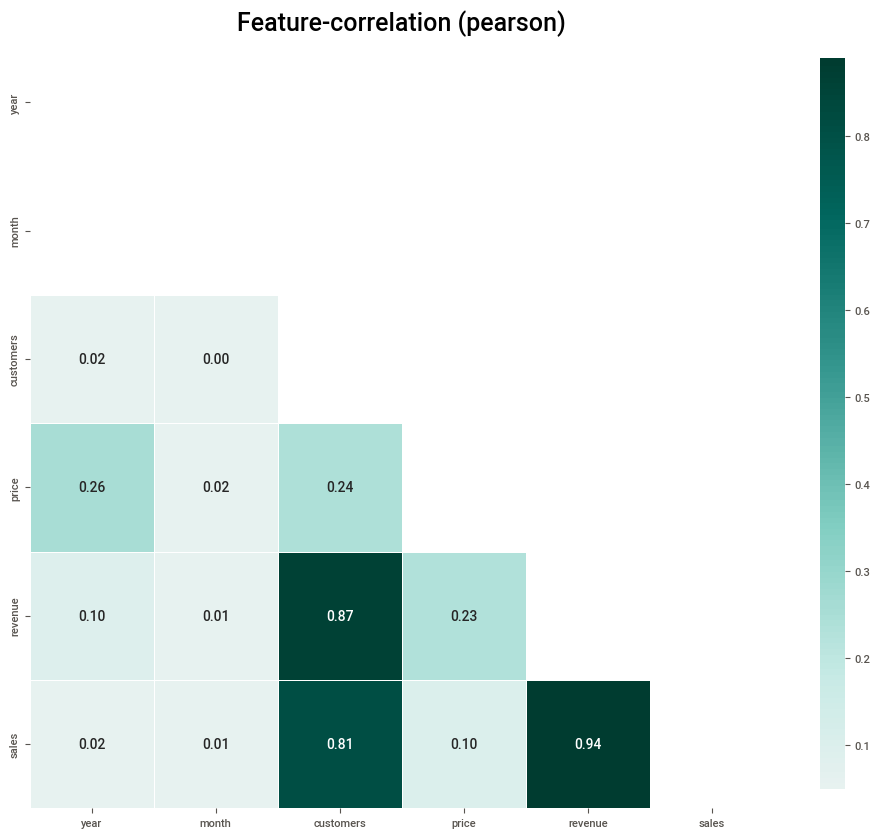

In [ ]:
#positive correlations
klib.corr_plot(df_states, split='pos')

Based on the plot above, the highest correlation is between:
- revenue x sales
  - sales directly contributes to revenue since you need to generate sales to generate revenue
- revenue x customers
  - the more customers you have the more revenue, direct correlation
- customers x sales
  - more customers contribute to the sales

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Axes: xlabel='sales', ylabel='Density'>

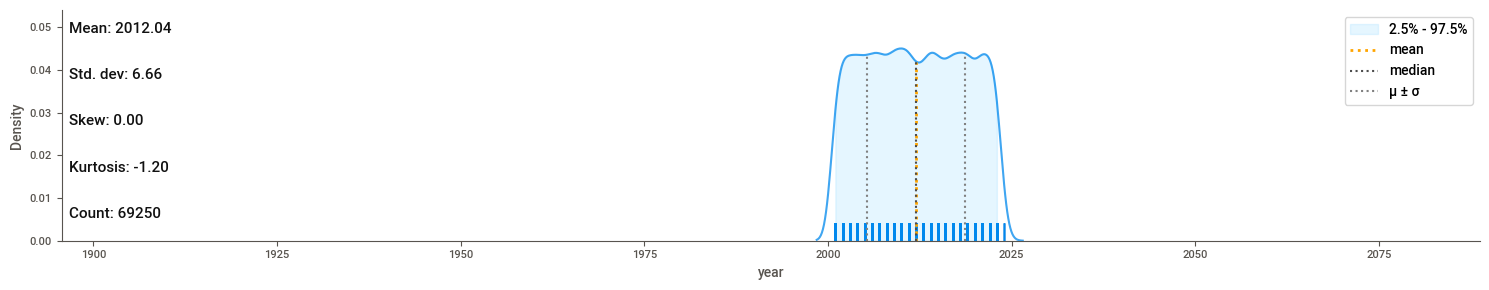

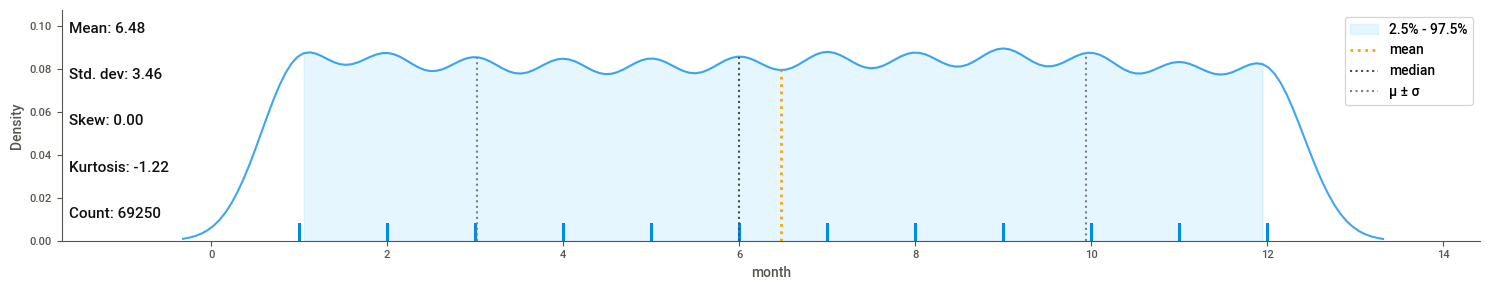

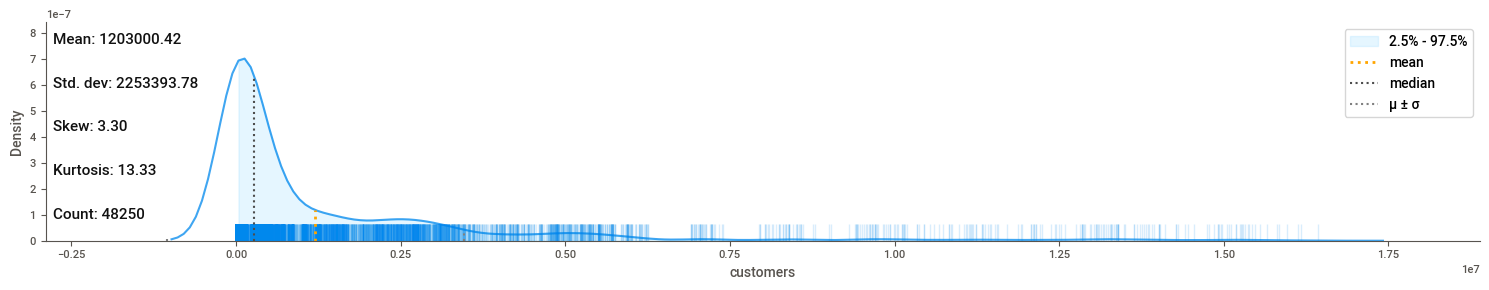

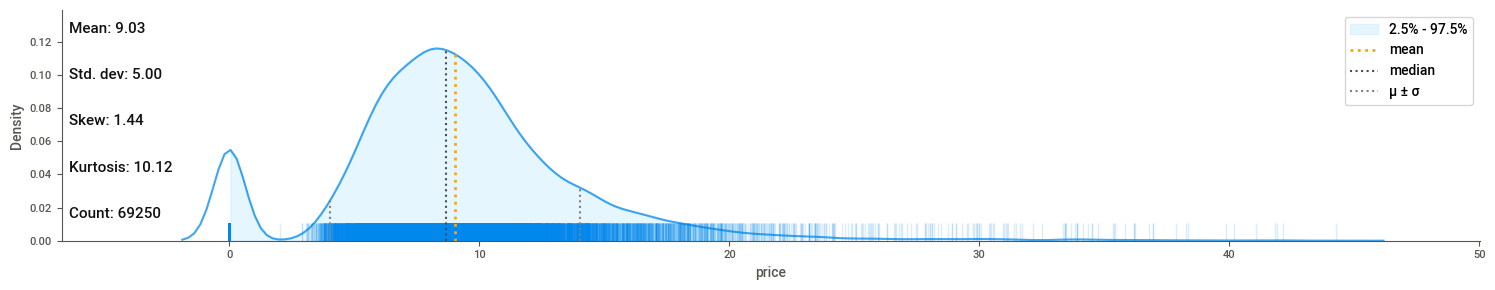

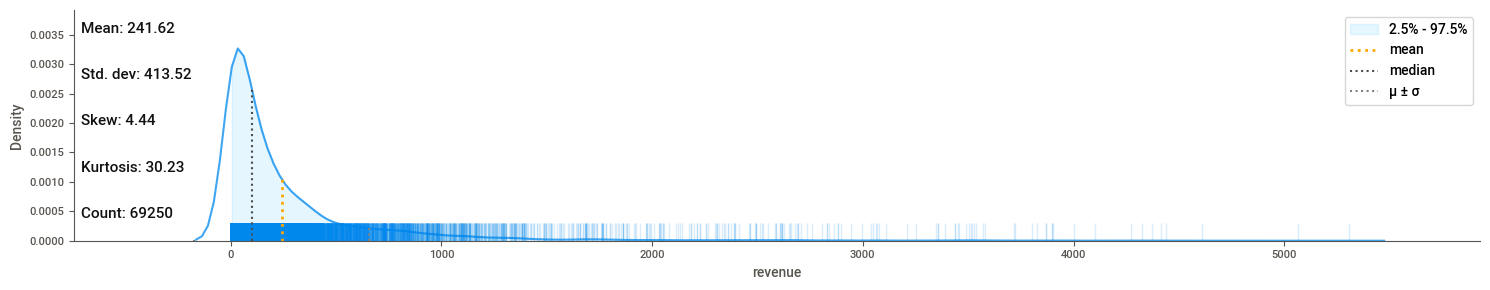

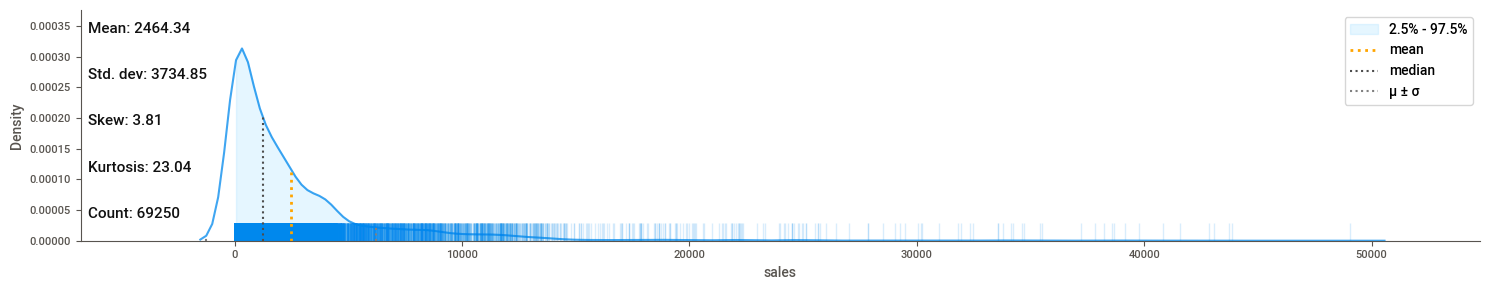

In [ ]:
#distribution of df
klib.dist_plot(df_states)

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Axes: xlabel='sales', ylabel='Density'>

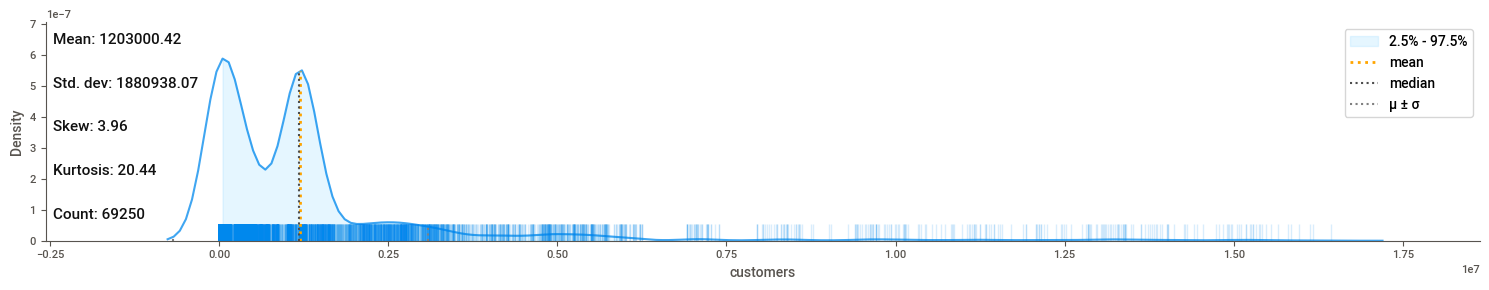

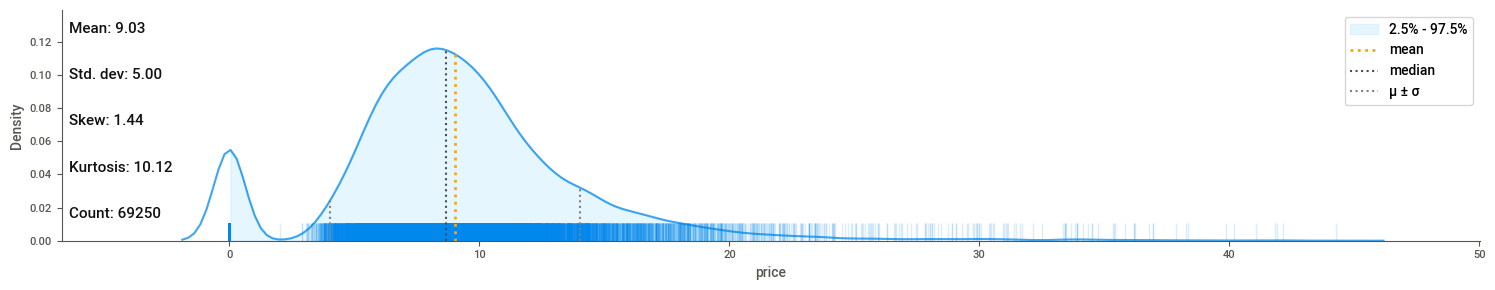

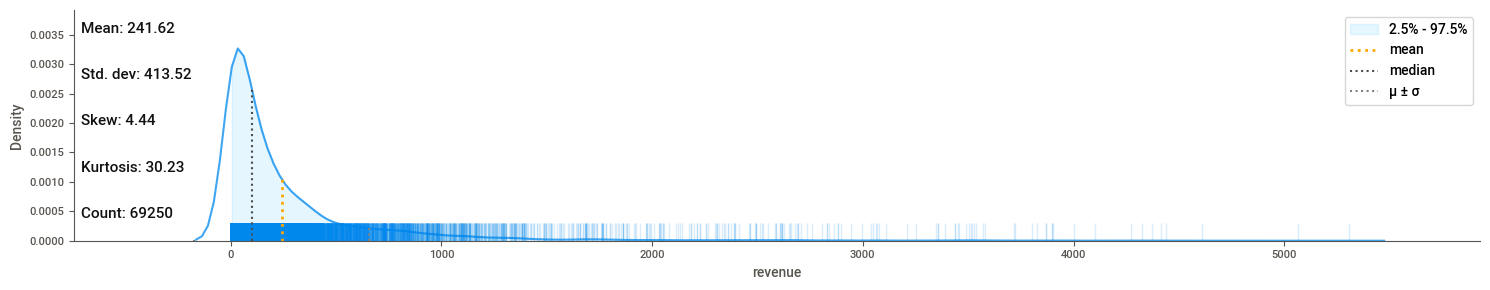

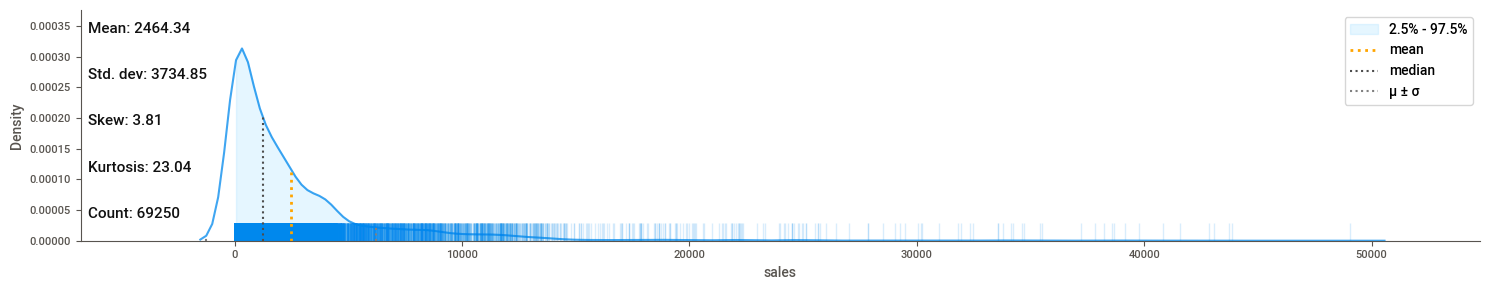

In [ ]:
#distribution of df_states_new
klib.dist_plot(df_states_new.drop(columns = ['year','month'], axis=1))

KLib has an auto-processing that drops duplicates and adjust the types as well as another function that adjusts the datatypes of the columns. We will see how this looks with our own cleaned up dataframe.

In [ ]:
df_klib = klib.data_cleaning(df_states)
df_klib = klib.convert_datatypes(df_klib)

Shape of cleaned data: (69250, 8) - Remaining NAs: 21000


Dropped rows: 0
     of which 0 duplicates. (Rows (first 150 shown): [])

Dropped columns: 0
     of which 0 single valued.     Columns: []
Dropped missing values: 0
Reduced memory by at least: 5.12 MB (-75.63%)



                                             |          | [  0%]   00:00 -> (? left)


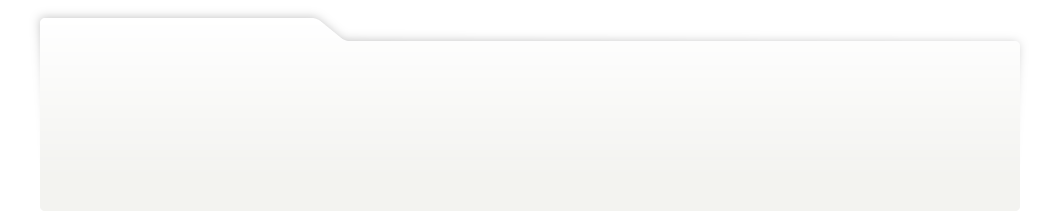
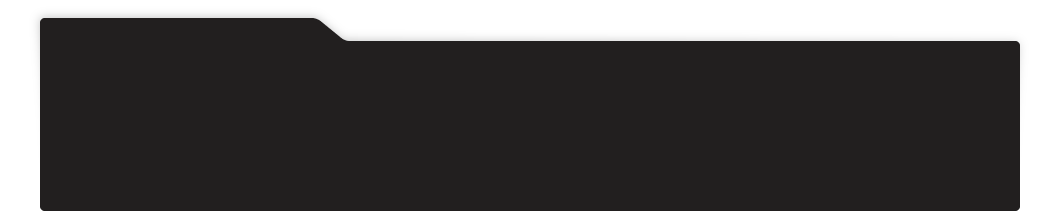
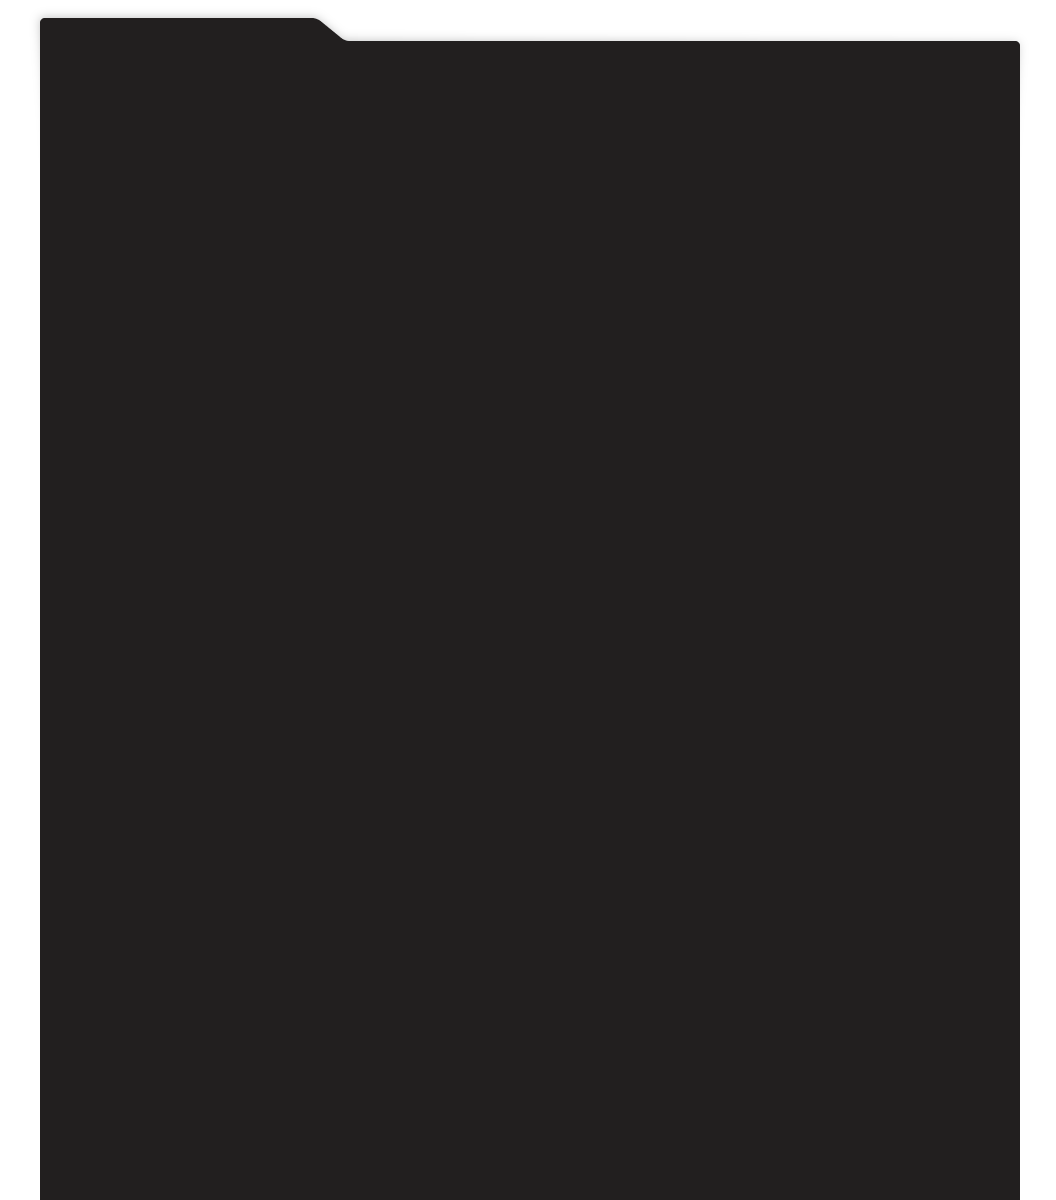
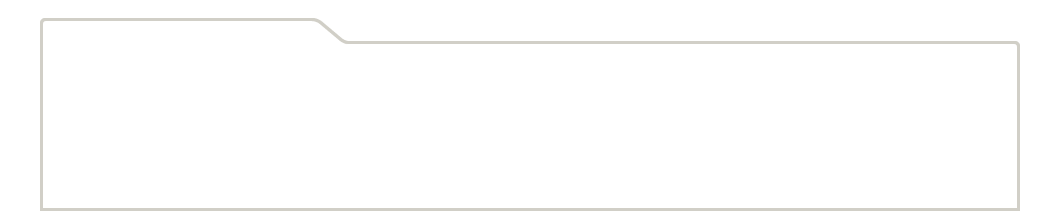
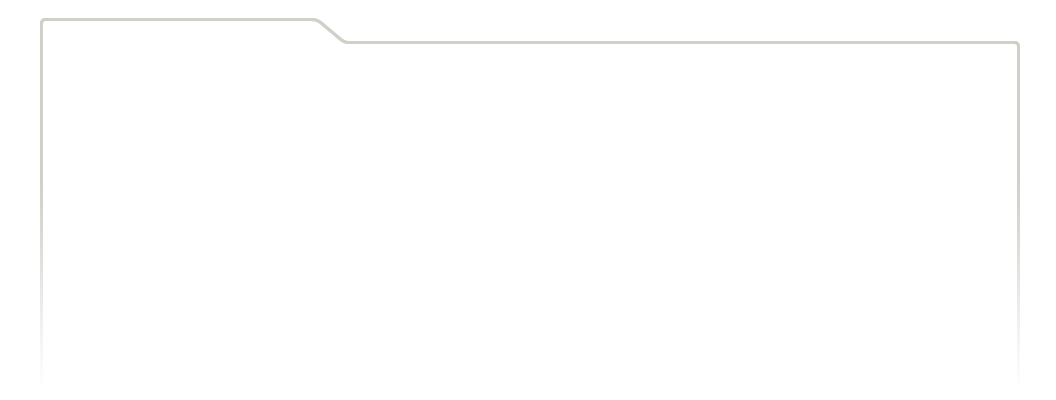
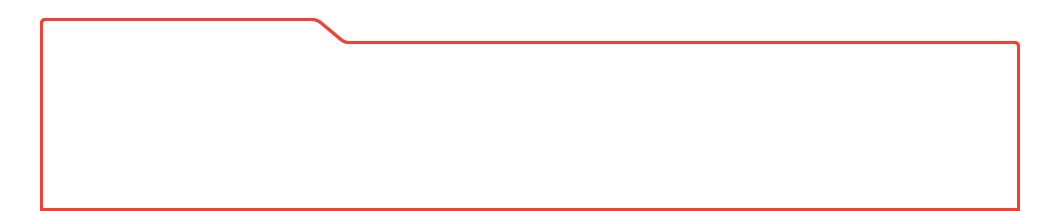
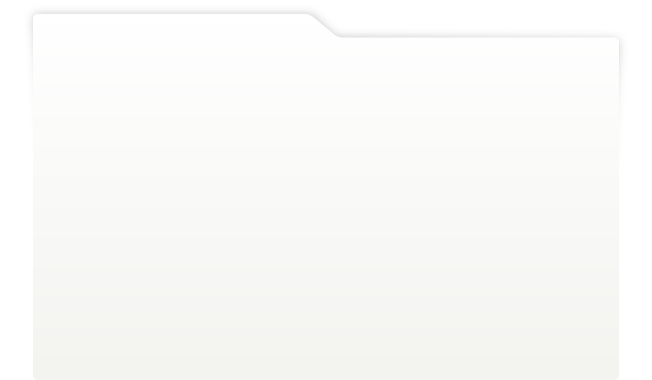
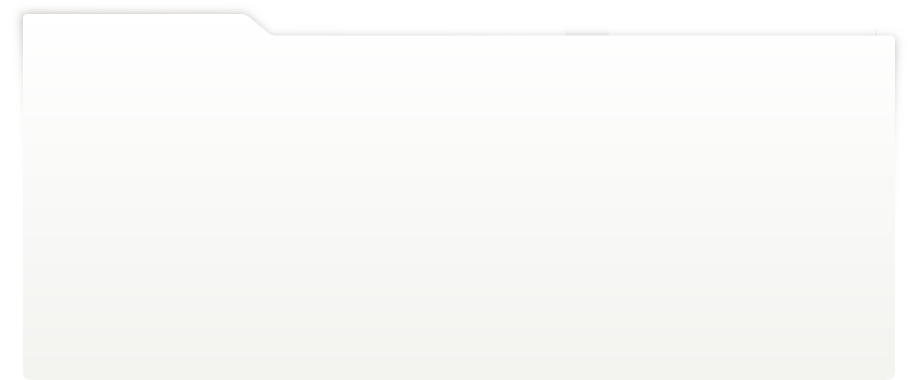
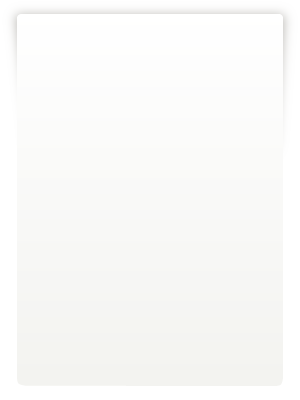
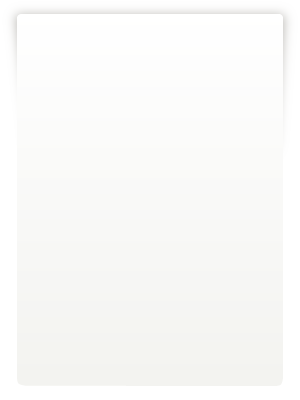
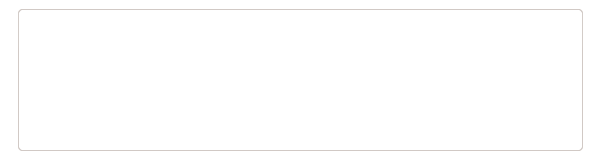
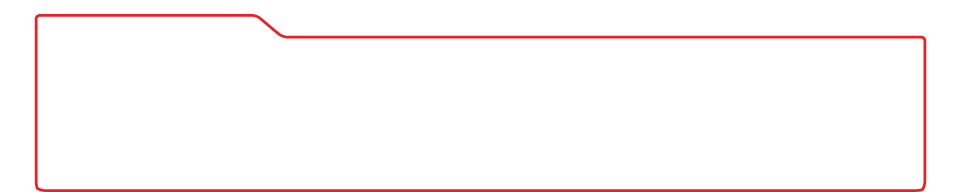
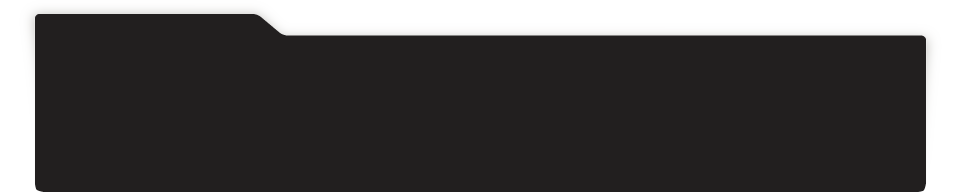
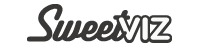
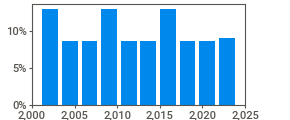
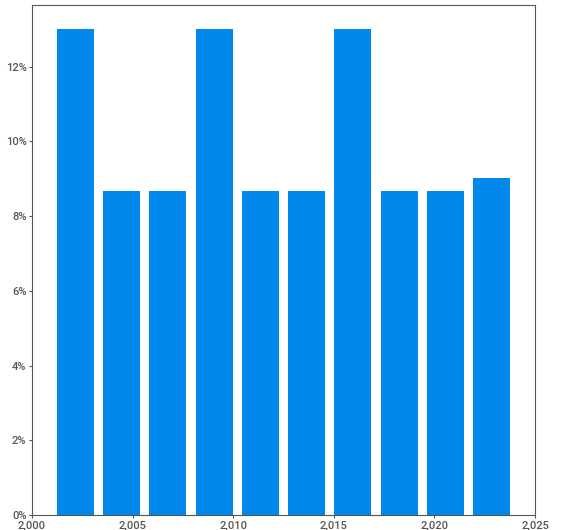
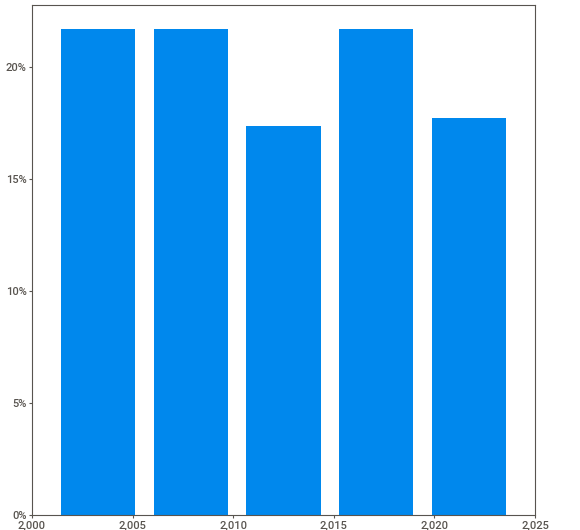
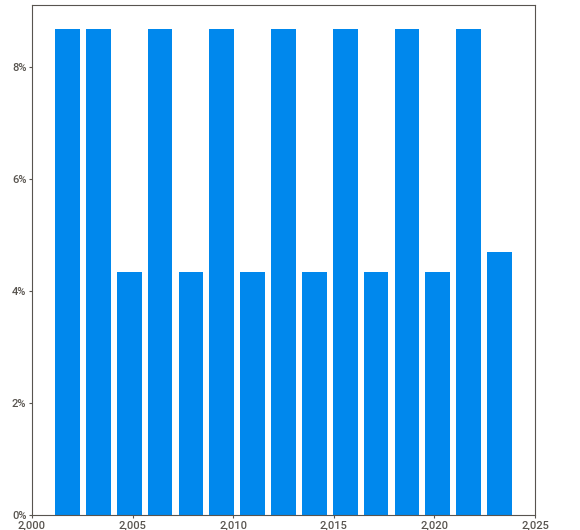
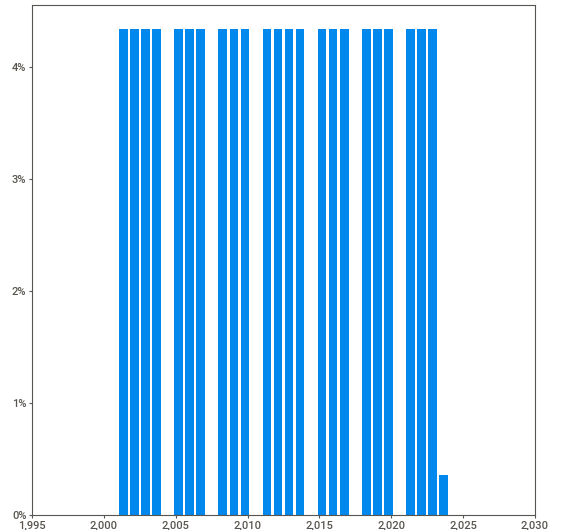
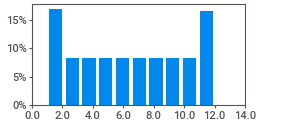
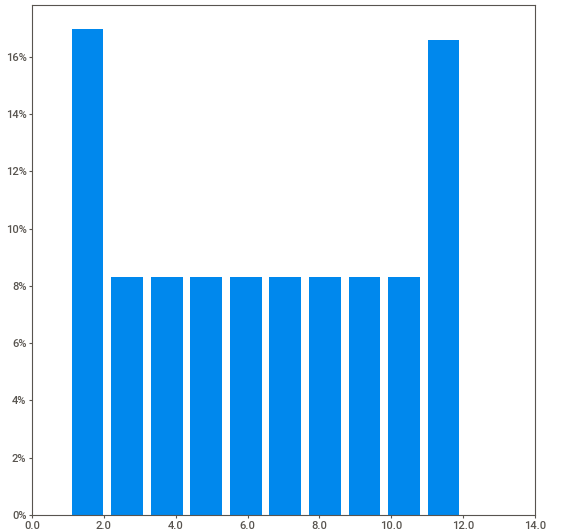
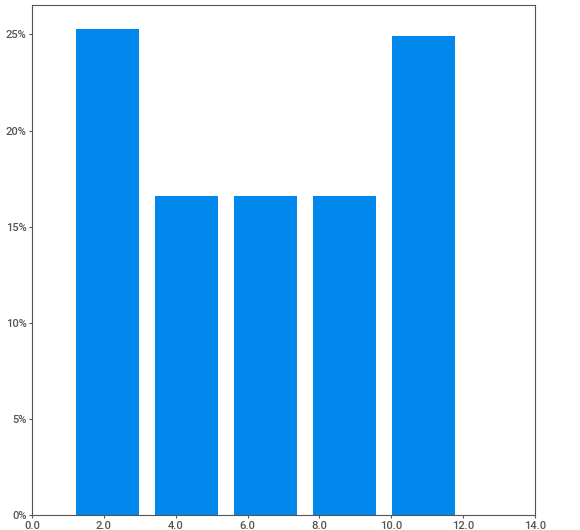
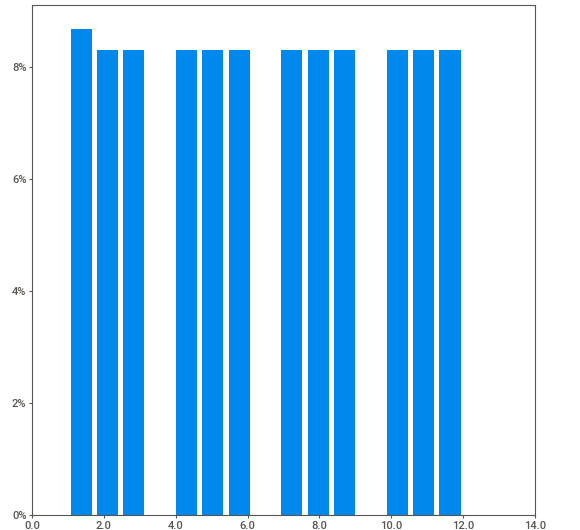
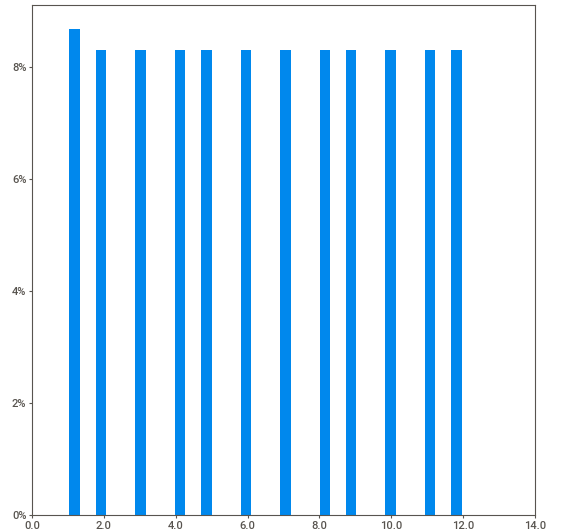
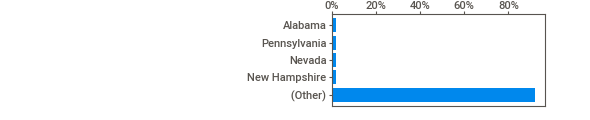
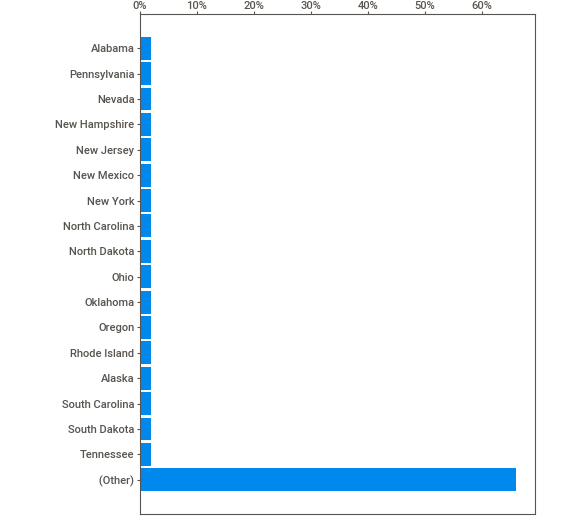
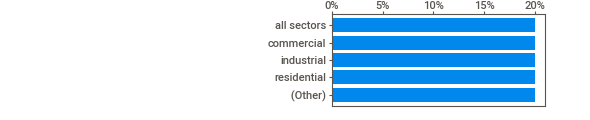
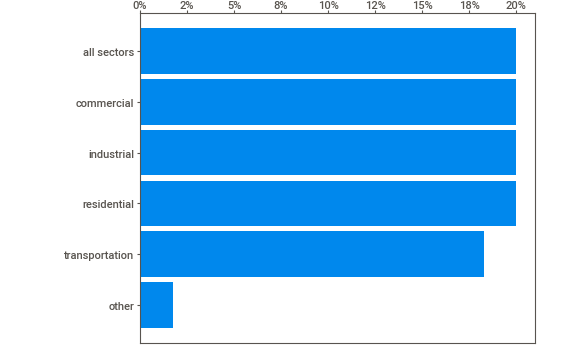
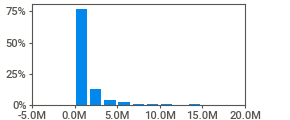
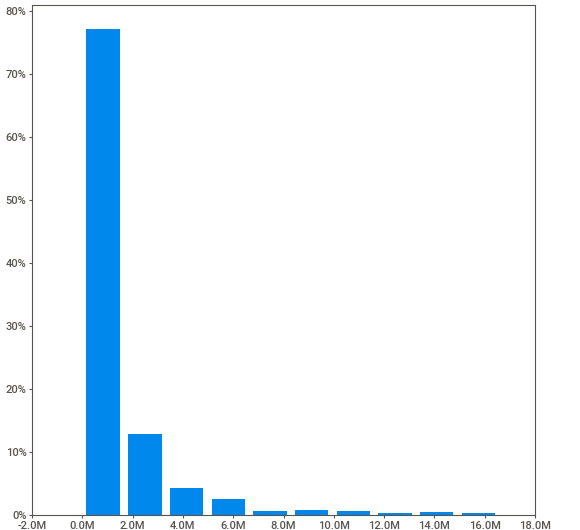
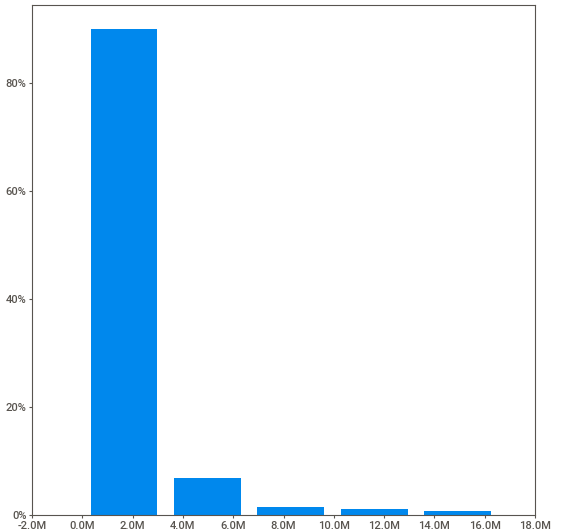
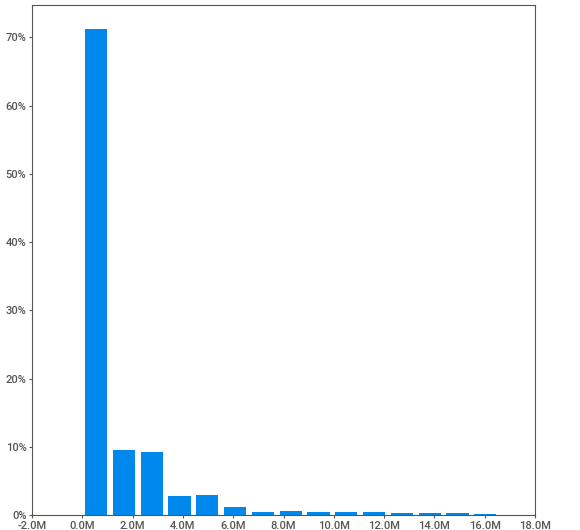
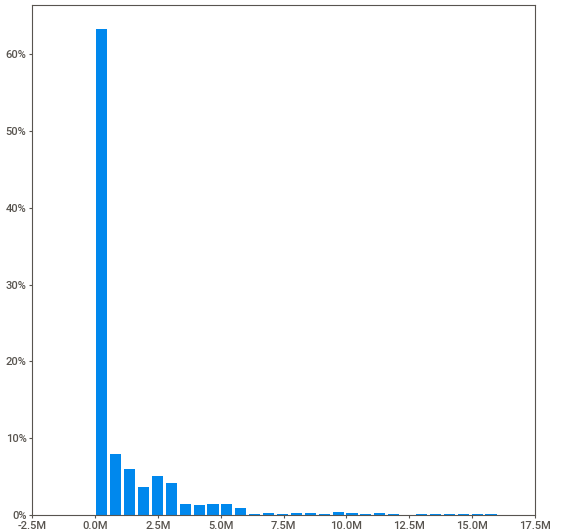
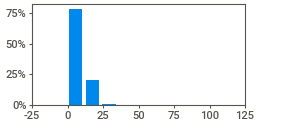
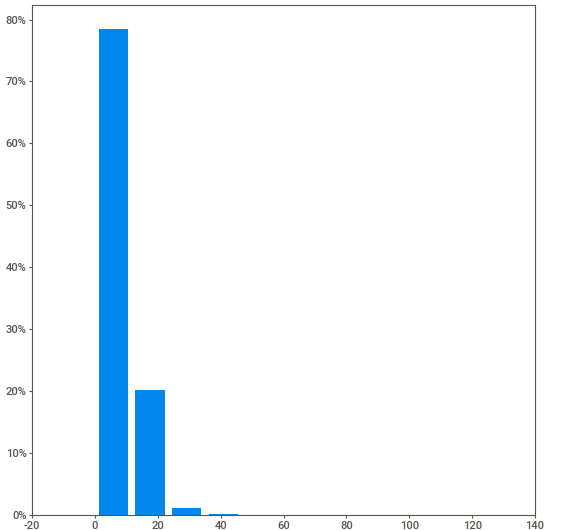
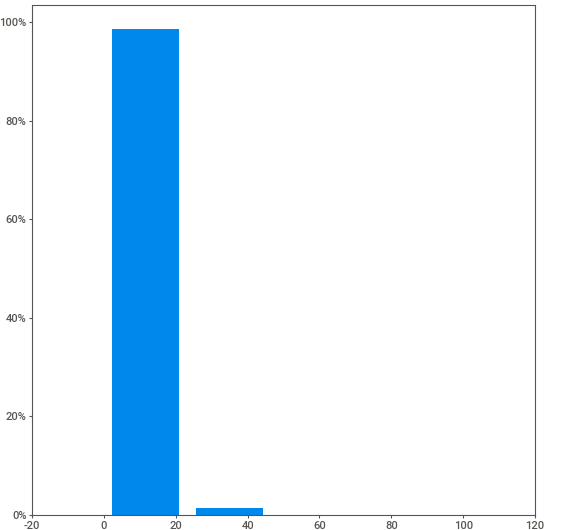
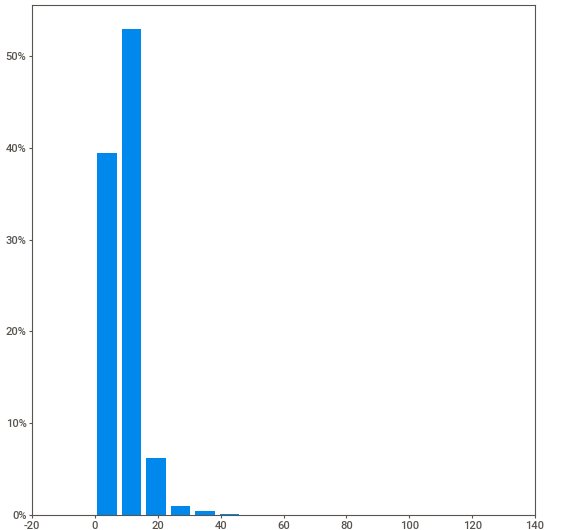
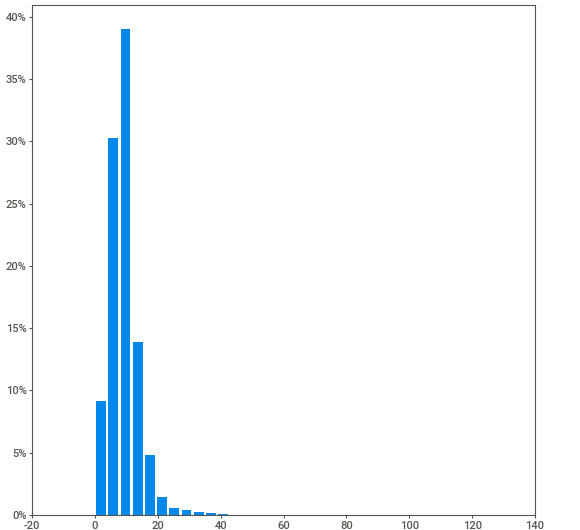
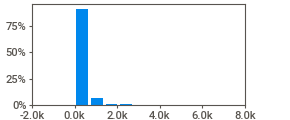
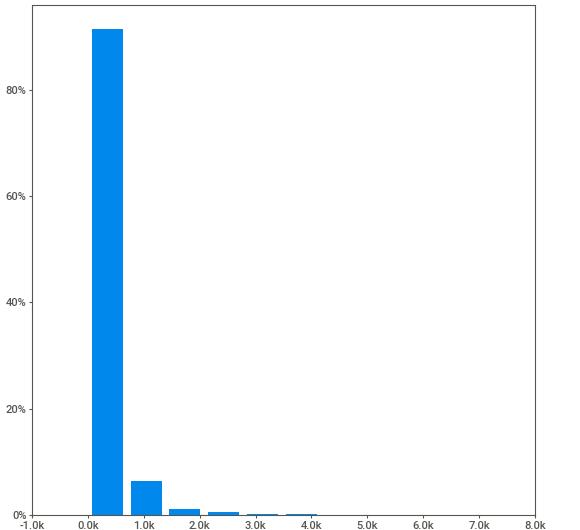
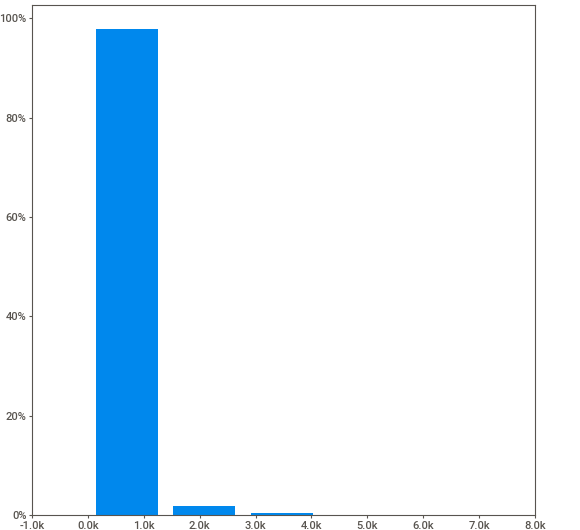
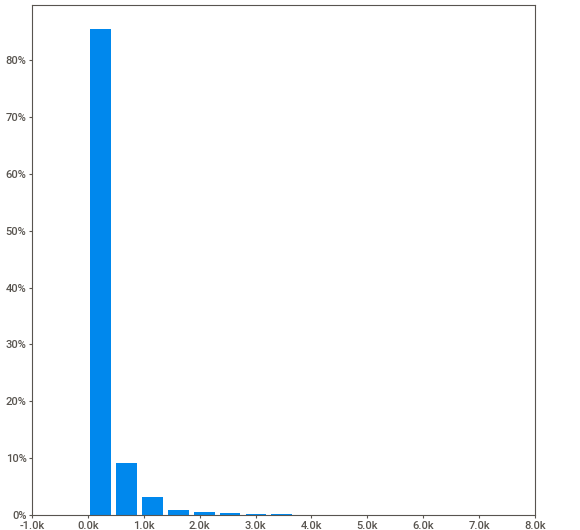
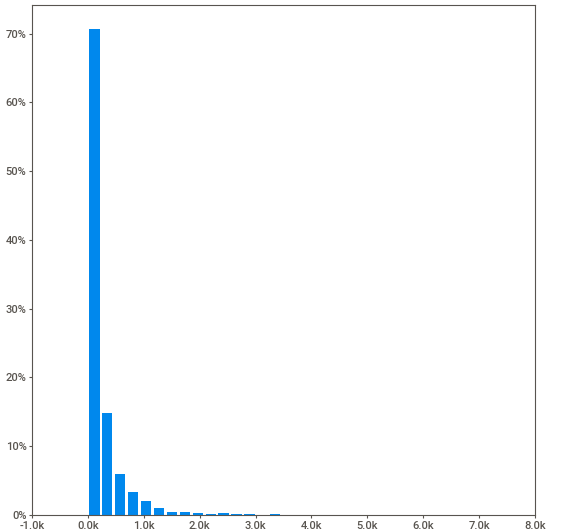
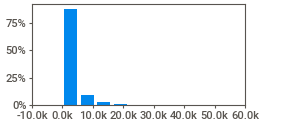
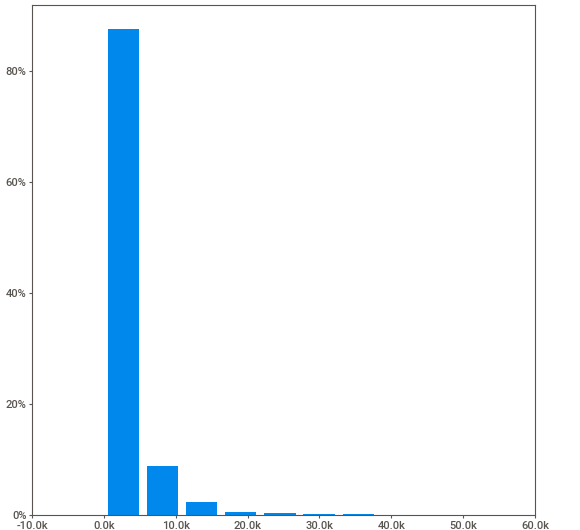
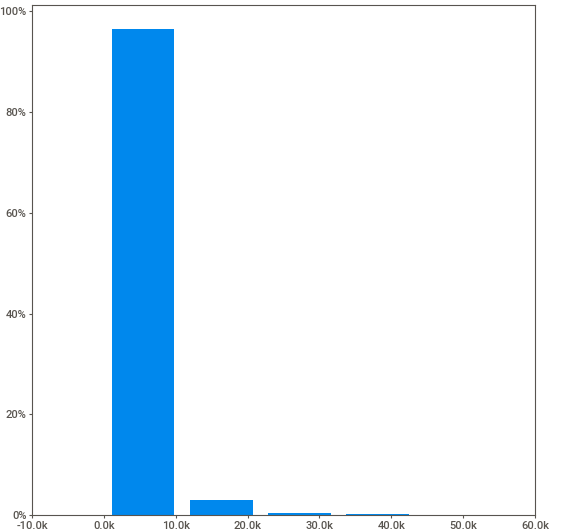
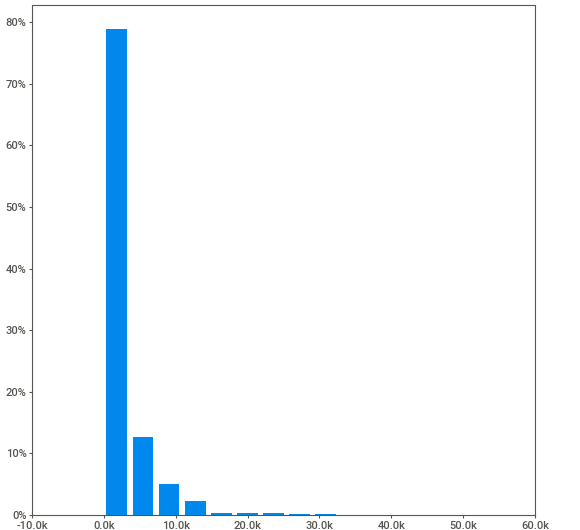
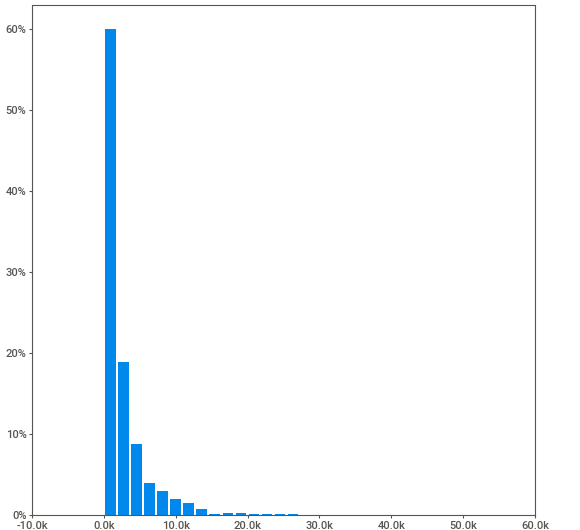
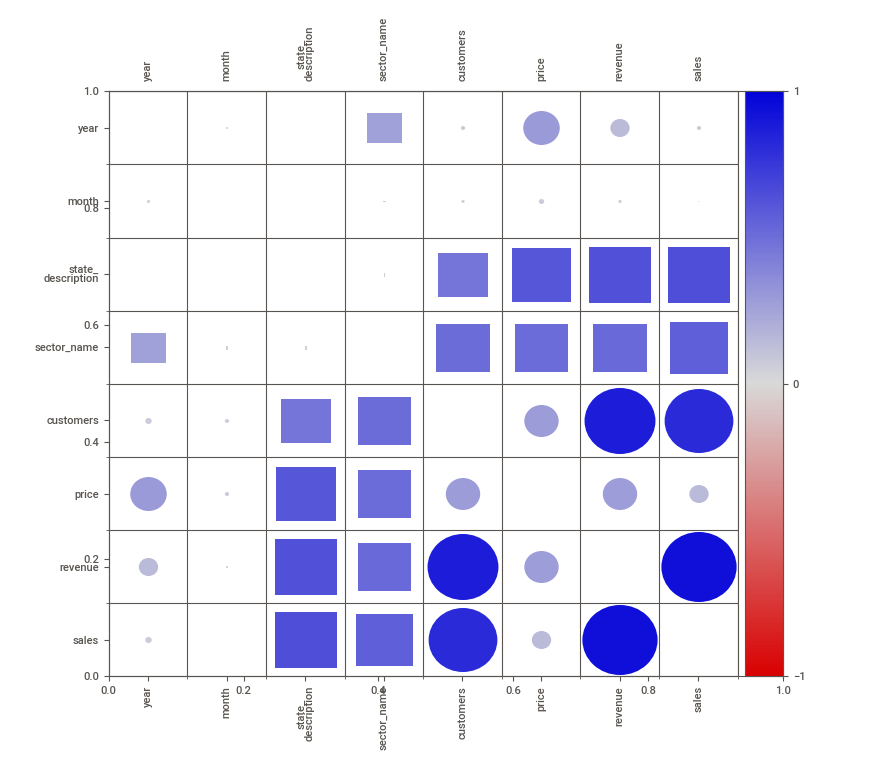
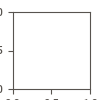

In [ ]:
#after cleaned df from klib
klib_df = sv.analyze(df_klib)
klib_df.show_notebook()

Didn't really do much. Though these tools are great for us to visualize our data and the correlations, they aren't very intuitive when it comes to cleaning data for us.

### **dabl**: Installing and importing dabl


In [ ]:
!pip install dabl
import dabl as db

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.3/558.3 kB 5.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dabl/plot/supervised.py:622: FutureWarning: The second positional argument of plot is a Series 'y'. If passing a column name, use a keyword.
  warnings.warn("The second positional argument of plot is a Series 'y'."
/usr/local/lib/python3.10/dist-packages/dabl/preprocessing.py:172: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(series[:10])
/usr/local/lib/python3.10/dist-packages/dabl/preprocessing.py:172: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(series[:10])
/usr/local/lib/python3.10/dist-packages/dabl/plot/utils.py:711: UserWarning: Dropped 66 outliers in column price.
  warn("Dropped {} outliers in column {}.".format(
/usr/local/lib/pyt

Target looks like regression


/usr/local/lib/python3.10/dist-packages/dabl/plot/utils.py:711: UserWarning: Dropped 9 outliers in column price.
  warn("Dropped {} outliers in column {}.".format(
/usr/local/lib/python3.10/dist-packages/dabl/plot/supervised.py:107: UserWarning: Not plotting highly correlated (0.9731082775908615) feature sales. Set prune_correlations_threshold=0 to keep.
  warn(f"Not plotting highly correlated ({corr.max()})"
/usr/local/lib/python3.10/dist-packages/dabl/plot/utils.py:711: UserWarning: Dropped 9 outliers in column price.
  warn("Dropped {} outliers in column {}.".format(
/usr/local/lib/python3.10/dist-packages/dabl/plot/supervised.py:214: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = X_new.groupby(col)[target_col].median()
/usr/local/lib/python3.10/dist-packages/dabl/plot/supervised.py:21

[<Axes: title={'center': 'Target distribution'}, xlabel='price', ylabel='frequency'>,
 array([[<Axes: title={'center': 'F=5.15E-01'}, xlabel='customers', ylabel='price'>,
         <Axes: title={'center': 'F=3.75E-01'}, xlabel='revenue'>,
         <Axes: title={'center': 'F=3.19E-01'}, xlabel='year (jittered)'>,
         <Axes: title={'center': 'F=2.47E-02'}, xlabel='month (jittered)'>]],
       dtype=object),
 array([[<Axes: title={'center': 'F=4.23E-01'}, xlabel='price', ylabel='stateDescription'>,
         <Axes: title={'center': 'F=3.20E-01'}, xlabel='price', ylabel='sectorName'>]],
       dtype=object)]

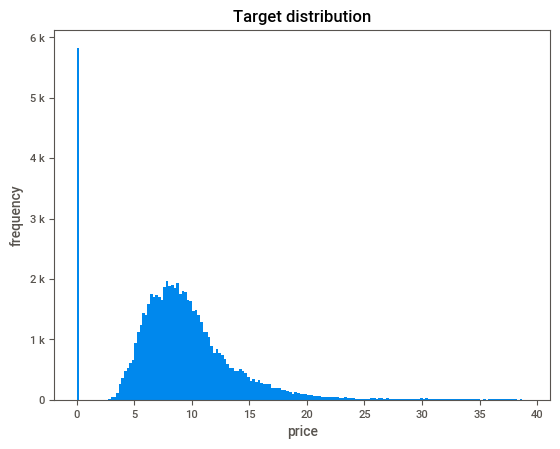

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


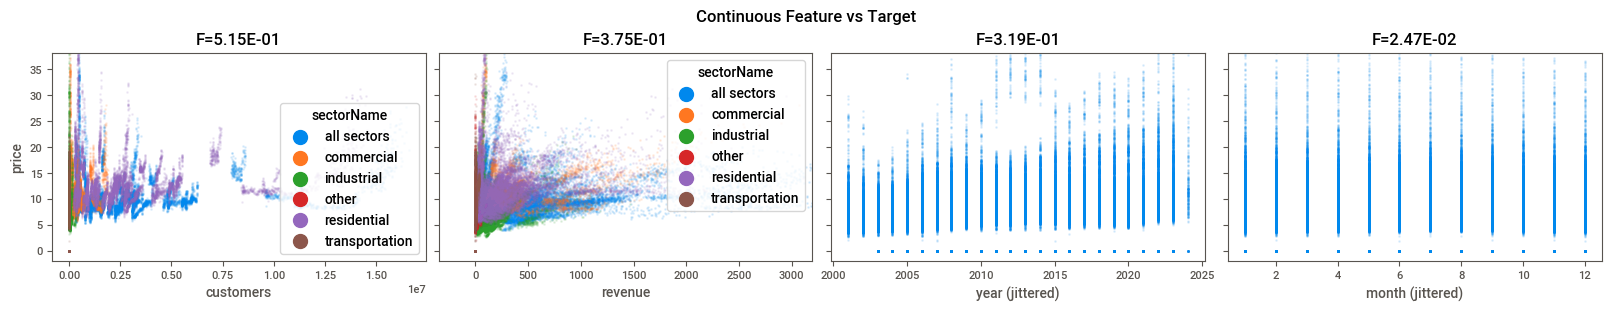

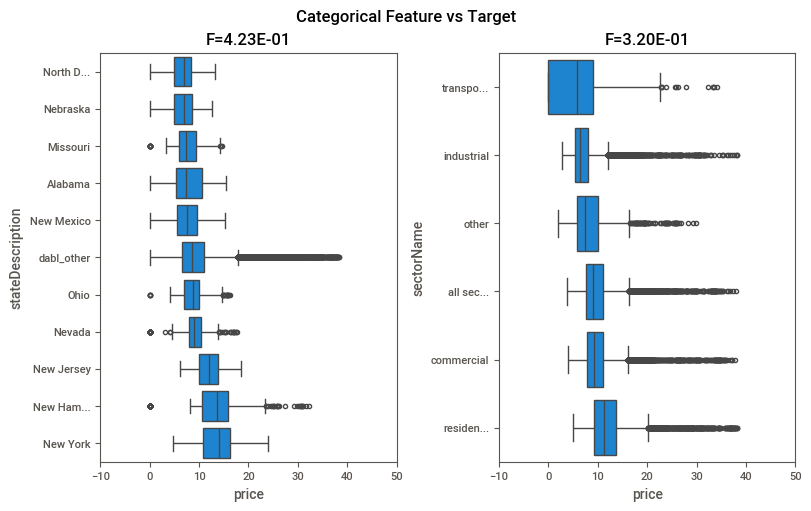

In [ ]:
db.plot(df_states, 'price')



*   Frequency of price = $0 is high
*   Year and month are not continuous -- have to plot as a categorical (notice if it is sinusoidal-- seasonal -- time series) -- Jittering is the act of adding random noise to data in order to prevent overplotting in statistical graphs.
* Frequency for prices follow a bell curve -- excluding the price = 0



## Section IV: Finding Invalid 0 Values

List of Combinations with Invalid 0 Values:


*   customers = 0, revenue != 0
*   price = 0, sales != 0
*   sales = 0, revenue != 0
*   price = 0, revenue != 0



In [ ]:
# Find rows where customers = 0, revenue != 0
rows_with_zero_customers_non_zero_revenue = df_states_new[(df_states_new['customers'] == 0) & (df_states_new['revenue'] != 0)]

if not rows_with_zero_customers_non_zero_revenue.empty:
  print("There are rows with 0 customers but non-zero revenue.")
  print(rows_with_zero_customers_non_zero_revenue)
else:
  print("There are no rows with 0 customers but non-zero revenue.")

There are rows with 0 customers but non-zero revenue.
       year  month stateDescription      sectorName  customers  price  \
26290  2008      1   North Carolina  transportation        0.0   7.96   
26615  2008      2   North Carolina  transportation        0.0   7.67   
26799  2008      3   North Carolina  transportation        0.0   9.40   
39843  2011      9             Utah  transportation        0.0   9.95   
40105  2011     10             Utah  transportation        0.0   9.97   
40570  2011     11             Utah  transportation        0.0   8.63   
40626  2011     12             Utah  transportation        0.0   8.64   
42228  2012      5   North Carolina  transportation        0.0   8.03   
42525  2012      6   North Carolina  transportation        0.0   8.14   
42804  2012      7   North Carolina  transportation        0.0   8.00   
43251  2012      8   North Carolina  transportation        0.0   7.89   
43537  2012      9   North Carolina  transportation        0.0   7.87 

In [ ]:
# Find rows where price = 0 and sales != 0
rows_with_zero_price_non_zero_sales = df_states_new[(df_states_new['price'] == 0) & (df_states_new['sales'] != 0)]

if not rows_with_zero_price_non_zero_sales.empty:
  print("There are rows with price = 0 and sales != 0:")
  print(rows_with_zero_price_non_zero_sales)
else:
  print("There are no rows with price = 0 and sales != 0.")

There are rows with price = 0 and sales != 0:
       year  month stateDescription      sectorName     customers  price  \
15168  2005      1   North Carolina  transportation  1.203000e+06    0.0   
15374  2005      2   North Carolina  transportation  1.203000e+06    0.0   
15658  2005      3   North Carolina  transportation  1.203000e+06    0.0   
15902  2005      4   North Carolina  transportation  1.203000e+06    0.0   
16229  2005      5   North Carolina  transportation  1.203000e+06    0.0   
16621  2005      6   North Carolina  transportation  1.203000e+06    0.0   
17027  2005      7   North Carolina  transportation  1.203000e+06    0.0   
17154  2005      8   North Carolina  transportation  1.203000e+06    0.0   
17547  2005      9   North Carolina  transportation  1.203000e+06    0.0   
41064  2012      1     Rhode Island  transportation  1.000000e+00    0.0   
41367  2012      2     Rhode Island  transportation  1.000000e+00    0.0   
41606  2012      3     Rhode Island  trans

In [ ]:
# Find rows where sales = 0 and revenue != 0
rows_with_zero_sales_non_zero_revenue = df_states_new[(df_states_new['sales'] == 0) & (df_states_new['revenue'] != 0)]

if not rows_with_zero_sales_non_zero_revenue.empty:
  print("\nThere are rows with with sales = 0 and revenue != 0:")
  print(rows_with_zero_sales_non_zero_revenue)
else:
  print("\nThere are no rows with with sales = 0 and revenue != 0.")


There are no rows with with sales = 0 and revenue != 0.


In [ ]:
# Find rows with price = 0 and revenue !=0

rows_with_zero_price_non_zero_revenue = df_states_new[(df_states_new['price'] == 0) & (df_states_new['revenue'] != 0)]

if not rows_with_zero_price_non_zero_revenue.empty:
  print("There are rows with price = 0 and revenue != 0:")
  print(rows_with_zero_price_non_zero_revenue)
else:
  print("There are no rows with price = 0 and revenue != 0.")

There are no rows with price = 0 and revenue != 0.


Observation: All the invalid 0 combination root from the transportation sector. During feature engineering phase, we plan on dropping the transportation sector

##Section V: Distribution

In this section, we explore the distribution of data across states.

In [ ]:
state_describe = df_states_new.groupby('stateDescription').apply(lambda x: x.describe())
print(state_describe)

                               year        month     customers        price  \
stateDescription                                                              
Alabama          count  1385.000000  1385.000000  1.385000e+03  1385.000000   
                 mean   2012.043321     6.480144  1.085302e+06     7.138469   
                 std       6.662671     3.462819  9.459002e+05     4.144726   
                 min    2001.000000     1.000000  0.000000e+00     0.000000   
                 25%    2006.000000     3.000000  7.397000e+03     5.390000   
...                             ...          ...           ...          ...   
Wyoming          min    2001.000000     1.000000  0.000000e+00     0.000000   
                 25%    2006.000000     3.000000  1.142300e+04     4.370000   
                 50%    2012.000000     6.000000  2.705250e+05     6.690000   
                 75%    2018.000000     9.000000  1.203000e+06     8.320000   
                 max    2024.000000    12.000000  1.

<ipython-input-26-c4f1d5fa4515>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_describe = df_states_new.groupby('stateDescription').apply(lambda x: x.describe())


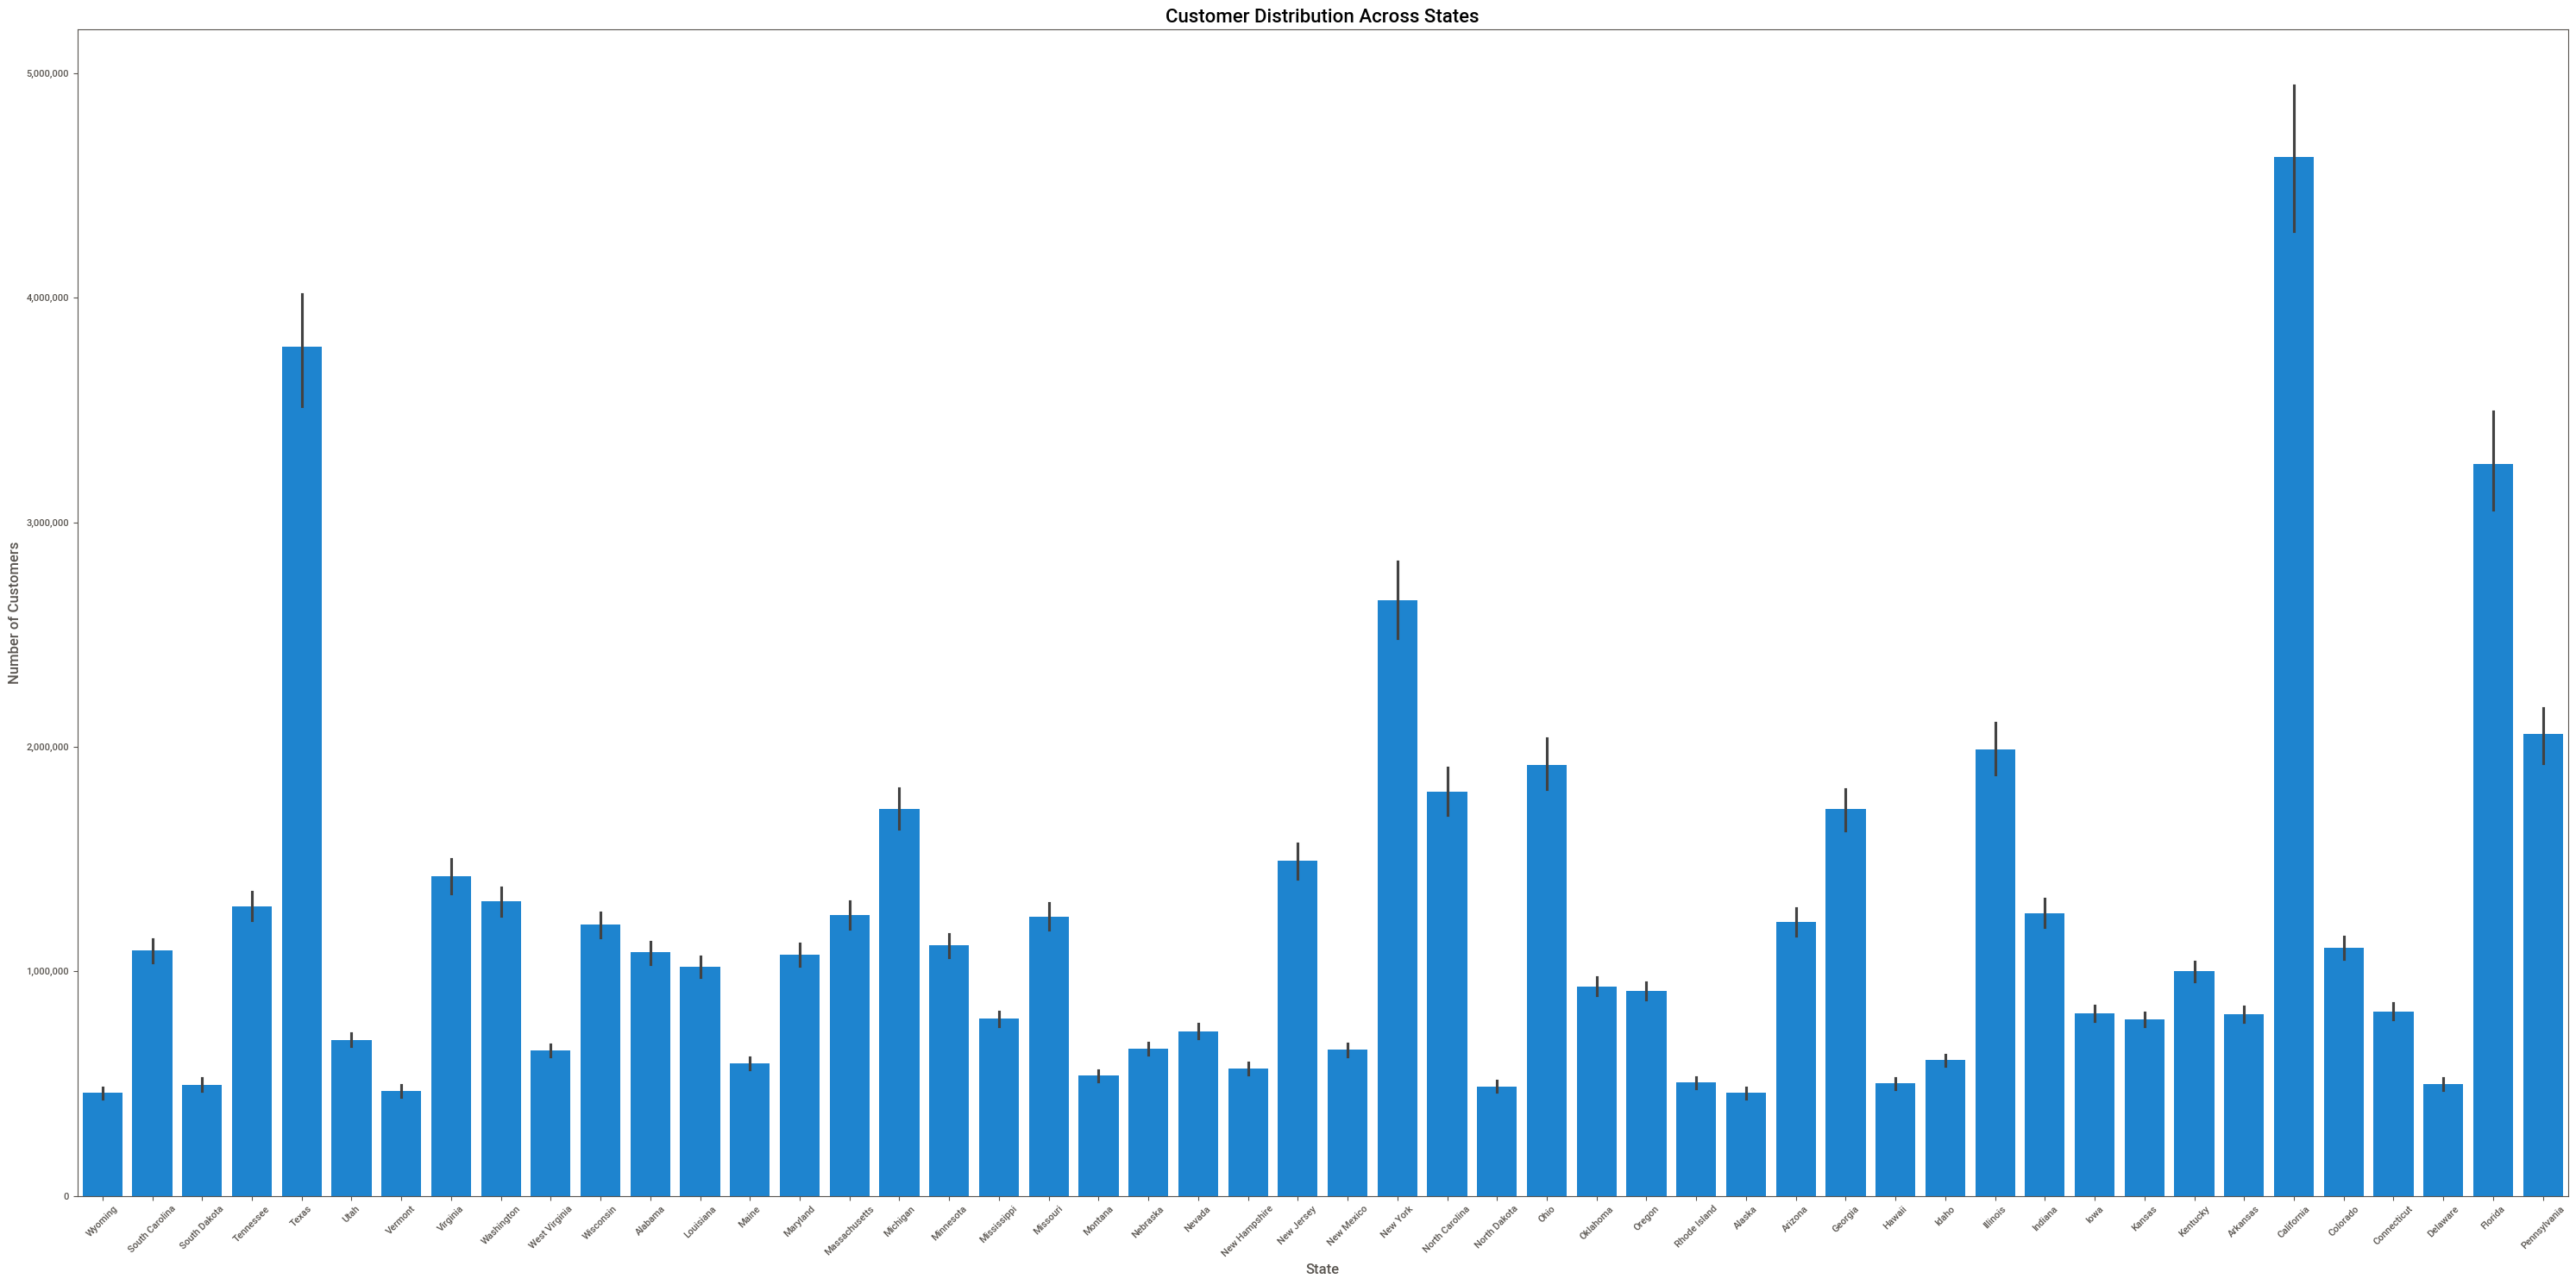

In [ ]:
plt.figure(figsize=(30, 15))
sns.barplot(x='stateDescription', y='customers', data=df_states_new)

plt.title('Customer Distribution Across States', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

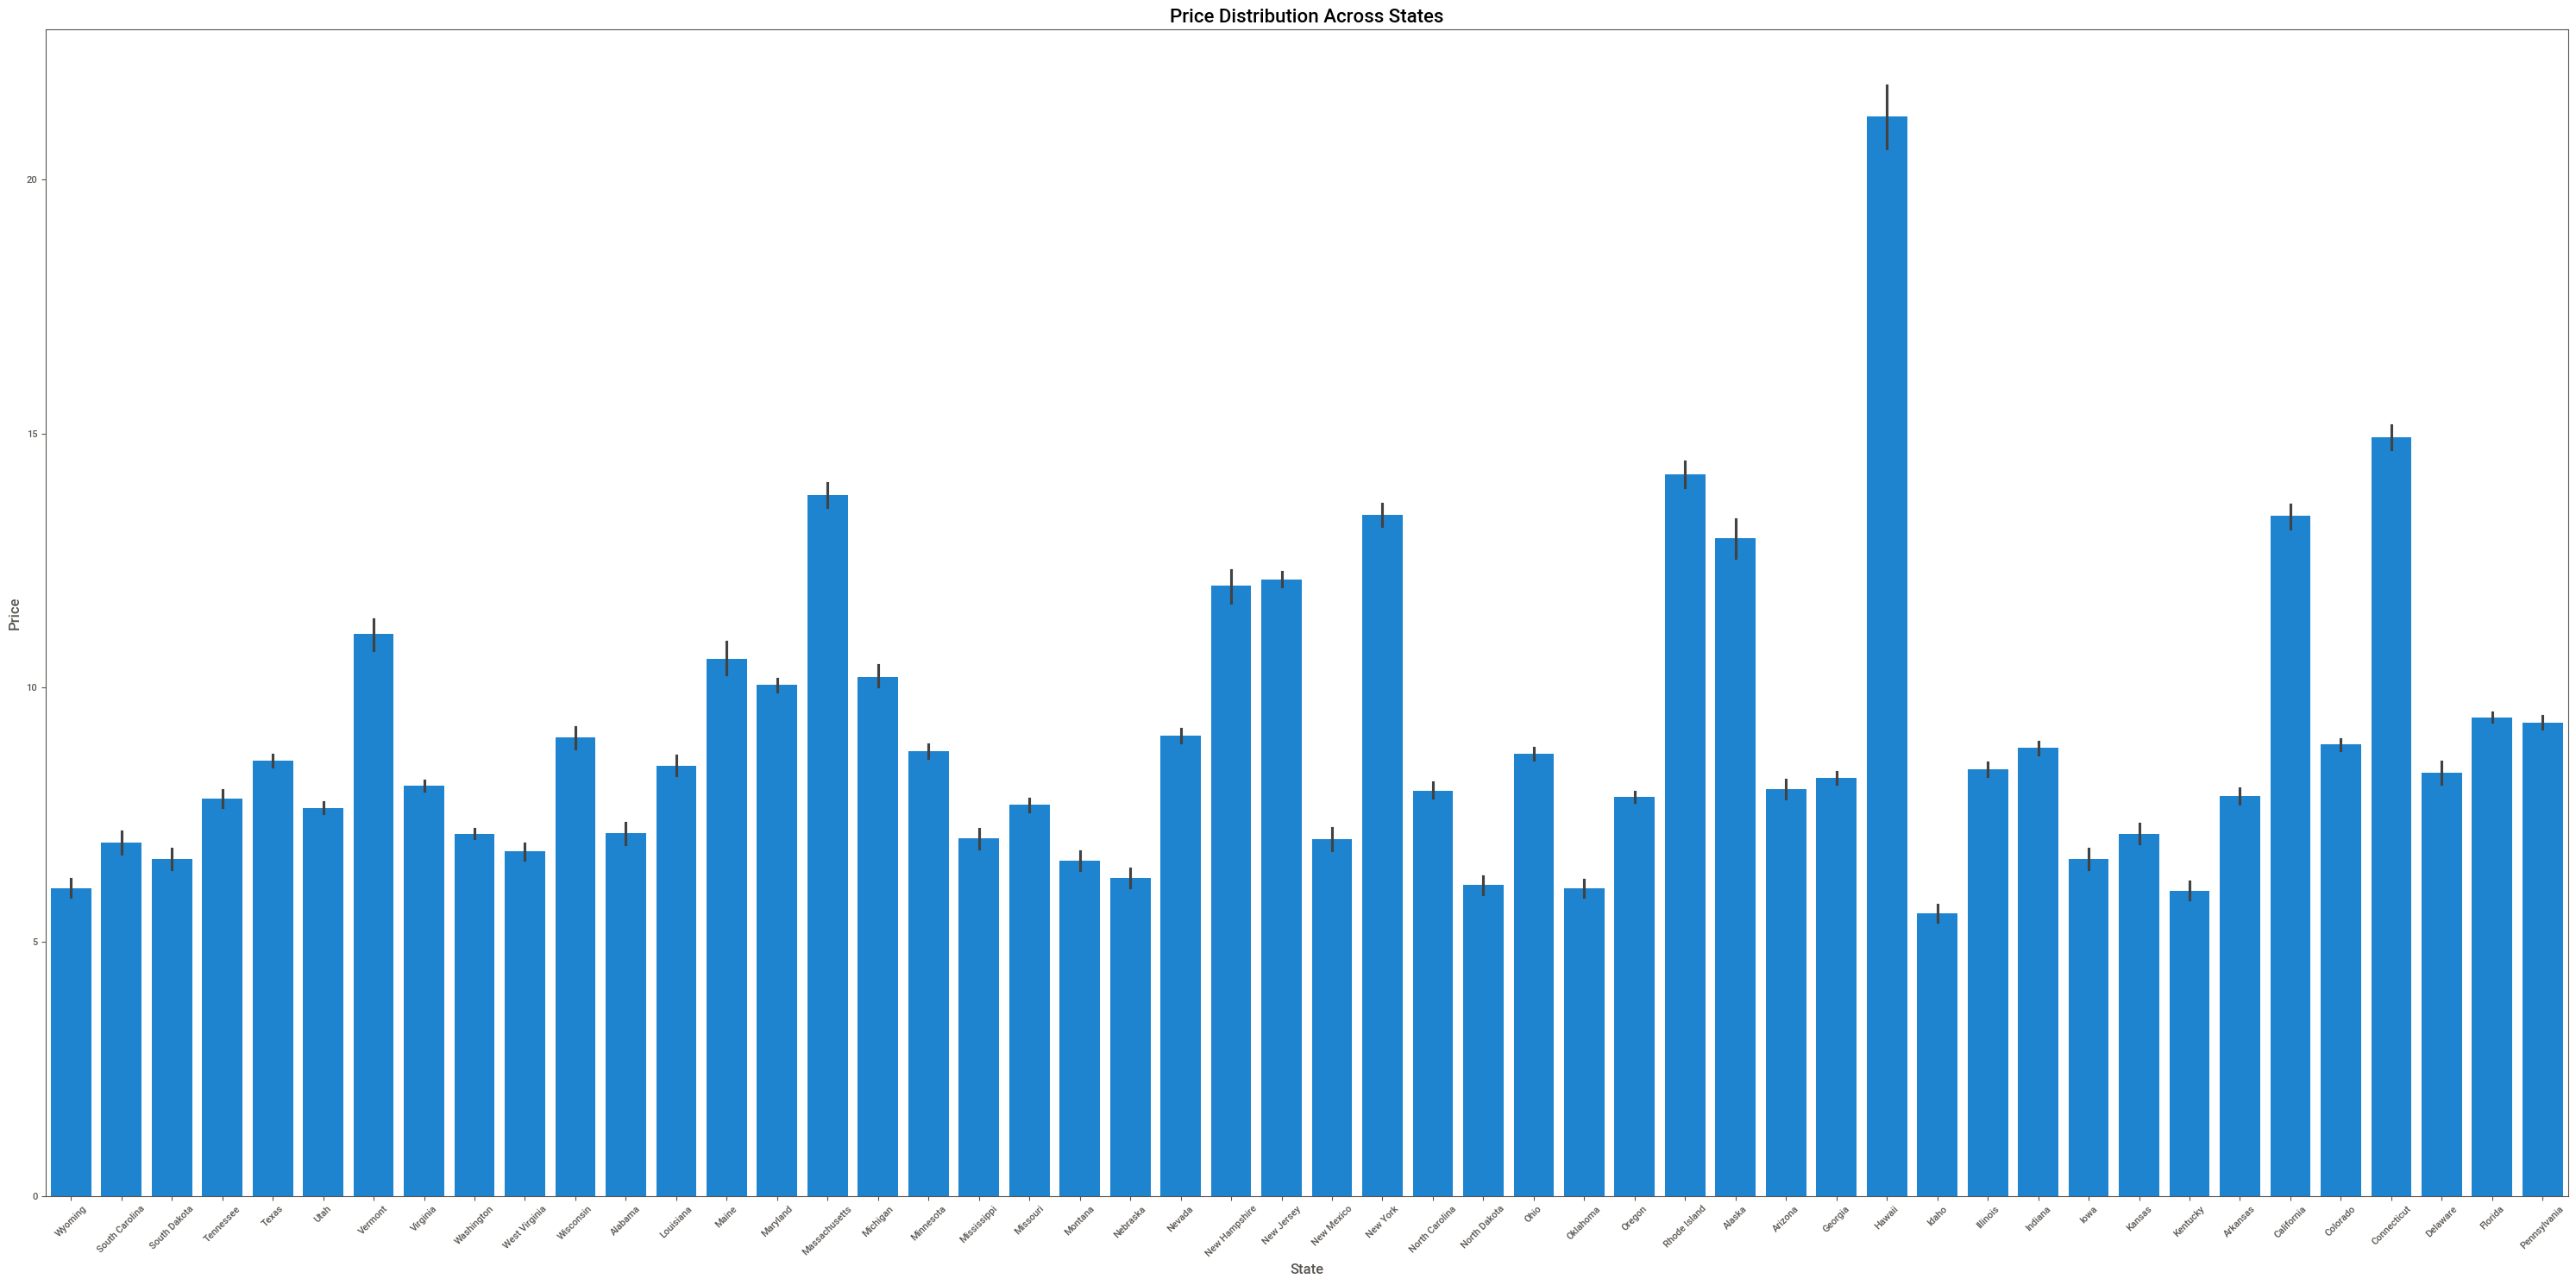

In [ ]:
plt.figure(figsize=(30, 15))
sns.barplot(x='stateDescription', y='price', data=df_states_new)

plt.title('Price Distribution Across States', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

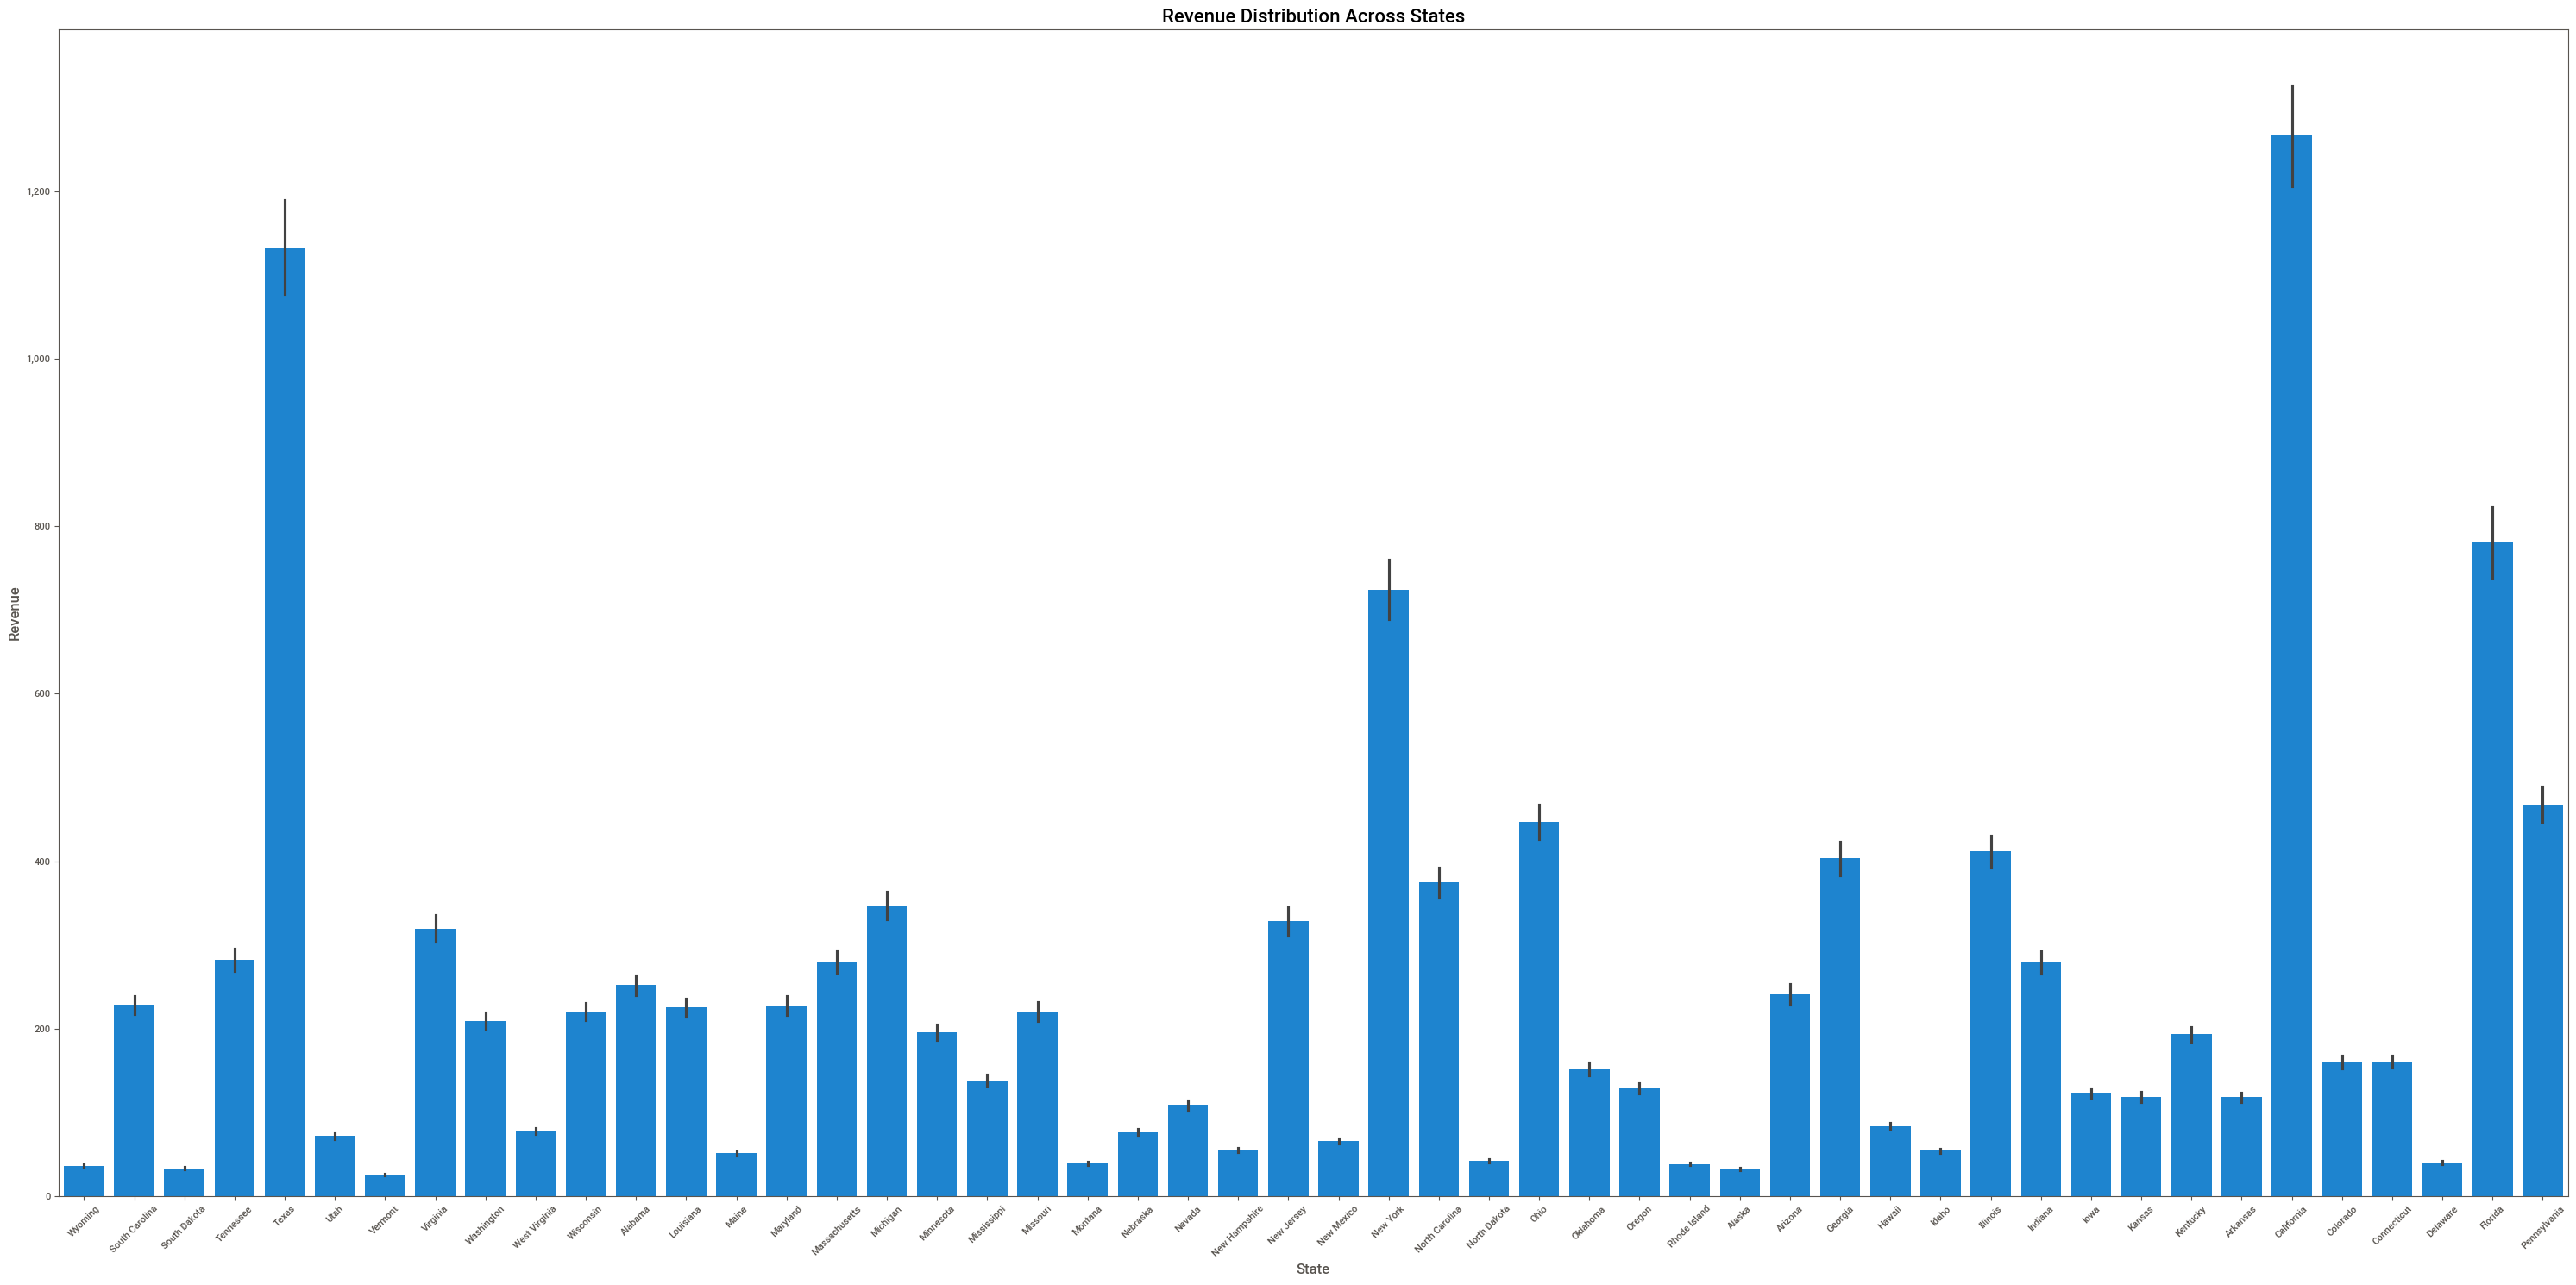

In [ ]:
plt.figure(figsize=(30, 15))
sns.barplot(x='stateDescription', y='revenue', data=df_states_new)

plt.title('Revenue Distribution Across States', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

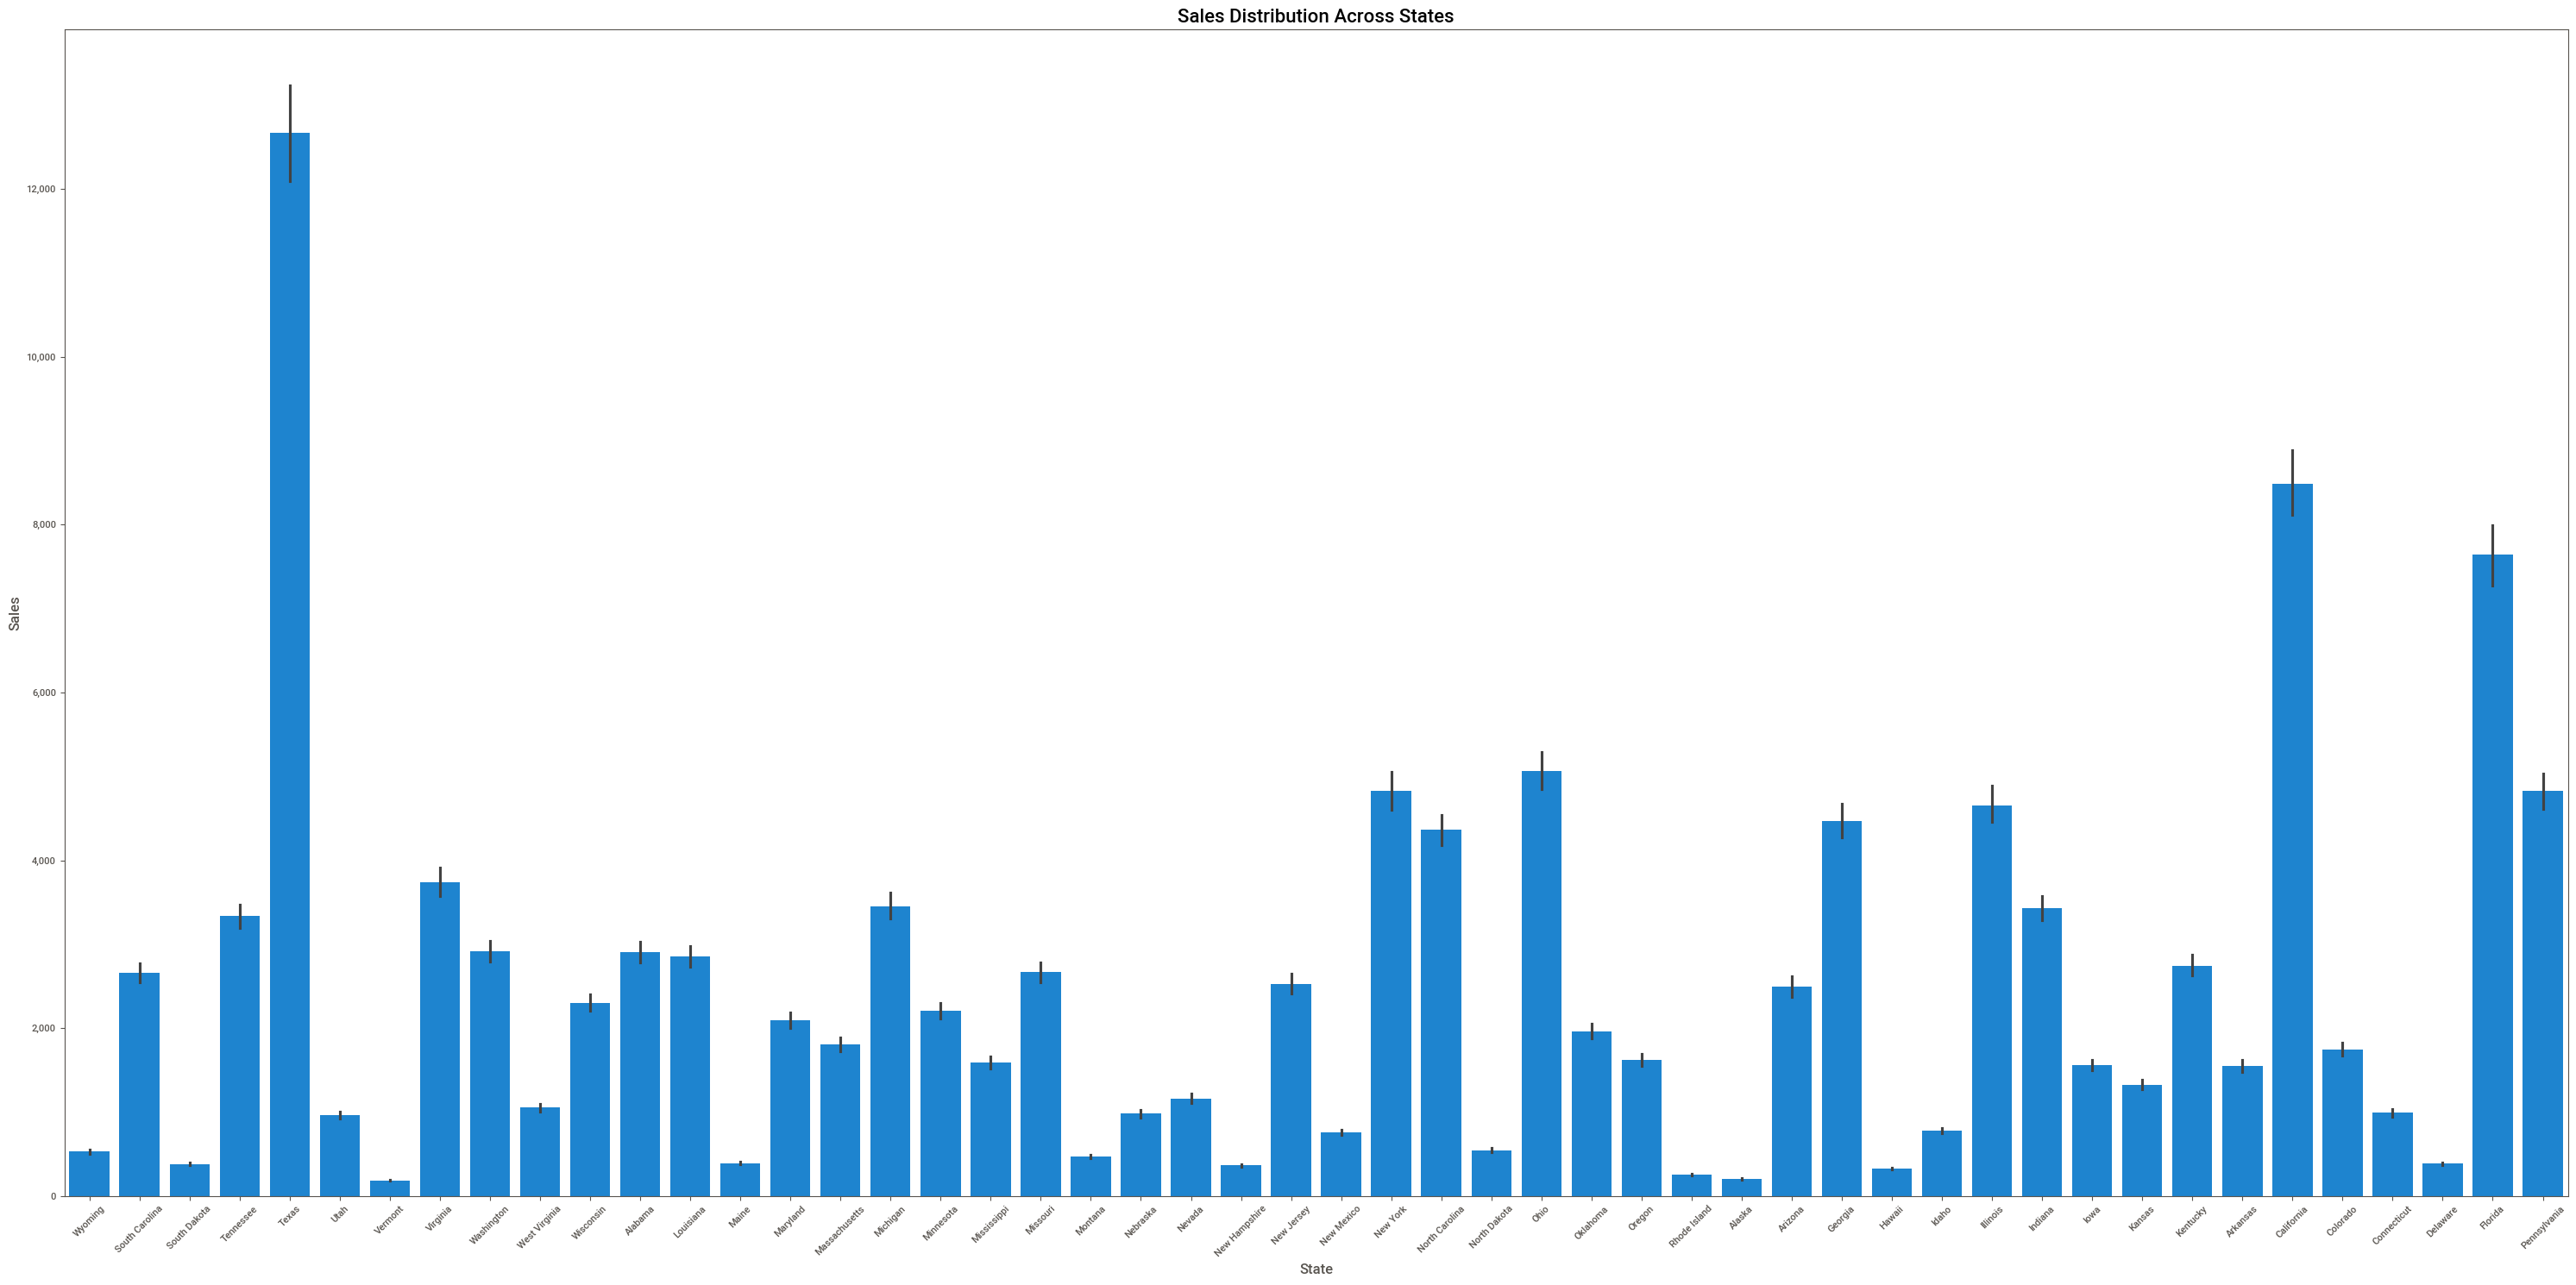

In [ ]:
plt.figure(figsize=(30, 15))
sns.barplot(x='stateDescription', y='sales', data=df_states_new)

plt.title('Sales Distribution Across States', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

# **Part 2: Feature Engineering**

Now we are preparing the dataset for training. The name of the dataframe is 'df_states_new'.

## Section I: Removing Unnecessary Information

First, we will remove the 'transporation' and 'other' sector as transportation is lacking in data and the 'other' sector is undefined.

In [ ]:
df_states_new = df_states_new.loc[df_states_new['sectorName'] != "transportation"].loc[df_states_new['sectorName'] != "other"] # Removing 'transportation' and 'other' sectors

## Section 2: Adding 'season'

Since weather and overall temperature can affect energy prices, we are going to add a new feature to our dataset called 'Season' which indicates if what season an example is set in.

The season is indicated with a number from 0-3 where **0 = Winter**, **1 = Spring**, **2 = Summer**, and **3 = Fall**

In [ ]:
season_mappings = {
    12 : 0,
    1 : 0,
    2 : 0,
    3 : 1,
    4 : 1,
    5 : 1,
    6 : 2,
    7 : 2,
    8 : 2,
    9 : 3,
    10 : 3,
    11 : 3,
}

season_column = []

for index, row in df_states_new.iterrows():
  season_column.append(season_mappings[row['month']])

df_states_new.insert(2, "Season", season_column)
df_states_new = df_states_new.drop('month', axis=1)
df_states_new

year  Season stateDescription   sectorName     customers  price  \
0      2001       0          Wyoming  all sectors  1.203000e+06   4.31   
1      2001       0          Wyoming   commercial  1.203000e+06   5.13   
2      2001       0          Wyoming   industrial  1.203000e+06   3.26   
4      2001       0          Wyoming  residential  1.203000e+06   6.01   
7      2001       0   South Carolina  residential  1.203000e+06   7.36   
...     ...     ...              ...          ...           ...    ...   
85863  2024       0          Arizona  residential  3.073908e+06  14.11   
85865  2024       0         Arkansas  all sectors  1.717720e+06   9.63   
85866  2024       0         Arkansas   commercial  2.086690e+05  10.26   
85867  2024       0         Arkansas   industrial  3.495100e+04   7.08   
85868  2024       0         Arkansas  residential  1.474098e+06  11.24   

         revenue       sales  
0       48.12840  1116.17208  
1       12.67978   247.08691  
2       19.60858   602.30484  
4       15.07136   250.60591  
7      225.81673  3066.25911  
...          ...         ...  
85863  385.98019  2736.43727  
85865  442.98773  4598.63147  
85866   97.79467   953.02154  
85867  109.92656  1553.02838  
85868  235.26399  2092.56172  

[55400 rows x 8 columns]

##Section 3: One Hot Encoding

We are one hot encoding the 'sectorNames', so our model can differentiate the examples based off the sectors.

In [ ]:
df_states_new = pd.get_dummies(df_states_new, columns = ['sectorName'], dtype = int)

We are one hot encoding the 'stateDescription', so our model can differentiate the examples based off the sectors.

In [ ]:
df_states_new = pd.get_dummies(df_states_new, columns = ['stateDescription'], dtype = int)

##Section 4: Normalizing

Because some of out features have numbers in the thousands while other features have numbers in the hundreds, we will be normalizing these values. That way, our model will not mistake the large quantity of customers as having more weight or the revenue to have less.

In [ ]:
normalize_columns = ['customers', 'price', 'revenue', 'sales']
scaler = MinMaxScaler()

df_states_new[normalize_columns] = scaler.fit_transform(df_states_new[normalize_columns])
df_states_new

year  Season  customers     price   revenue     sales  \
0      2001       0   0.072557  0.037313  0.006196  0.019782   
1      2001       0   0.072557  0.056437  0.001084  0.003808   
2      2001       0   0.072557  0.012826  0.002083  0.010337   
4      2001       0   0.072557  0.076959  0.001429  0.003873   
7      2001       0   0.072557  0.108442  0.031823  0.055626   
...     ...     ...        ...       ...       ...       ...   
85863  2024       0   0.185414  0.265858  0.054922  0.049563   
85865  2024       0   0.103606  0.161381  0.063144  0.083791   
85866  2024       0   0.012576  0.176073  0.013359  0.016784   
85867  2024       0   0.002097  0.101912  0.015109  0.027812   
85868  2024       0   0.088910  0.198927  0.033186  0.037729   

       sectorName_all sectors  sectorName_commercial  sectorName_industrial  \
0                           1                      0                      0   
1                           0                      1                      0   
2                           0                      0                      1   
4                           0                      0                      0   
7                           0                      0                      0   
...                       ...                    ...                    ...   
85863                       0                      0                      0   
85865                       1                      0                      0   
85866                       0                      1                      0   
85867                       0                      0                      1   
85868                       0                      0                      0   

       sectorName_residential  ...  stateDescription_South Dakota  \
0                           0  ...                              0   
1                           0  ...                              0   
2                           0  ...                              0   
4                           1  ...                              0   
7                           1  ...                              0   
...                       ...  ...                            ...   
85863                       1  ...                              0   
85865                       0  ...                              0   
85866                       0  ...                              0   
85867                       0  ...                              0   
85868                       1  ...                              0   

       stateDescription_Tennessee  stateDescription_Texas  \
0                               0                       0   
1                               0                       0   
2                               0                       0   
4                               0                       0   
7                               0                       0   
...                           ...                     ...   
85863                           0                       0   
85865                           0                       0   
85866                           0                       0   
85867                           0                       0   
85868                           0                       0   

       stateDescription_Utah  stateDescription_Vermont  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
4                          0                         0   
7                          0                         0   
...                      ...                       ...   
85863                      0                         0   
85865                      0                         0   
85866                      0                         0   
85867                      0                         0   
85868                      0                         0   

       stateDescription_Virgin

In [ ]:
df_states_new.to_csv('electricty_prices_clean.csv', sep='\t', index=False,header=True)

In [ ]:
#make lag 1 and lag 2
#df_states_new['price_lag_1'] = df_states_new['price'].shift(1,fill_value=0)

#df_states_new['price_lag_2'] = df_states_new['price'].shift(2,fill_value=0)

In [ ]:
df_states_new.head()

year  Season  customers     price   revenue     sales  \
0  2001       0   0.072557  0.037313  0.006196  0.019782   
1  2001       0   0.072557  0.056437  0.001084  0.003808   
2  2001       0   0.072557  0.012826  0.002083  0.010337   
4  2001       0   0.072557  0.076959  0.001429  0.003873   
7  2001       0   0.072557  0.108442  0.031823  0.055626   

   sectorName_all sectors  sectorName_commercial  sectorName_industrial  \
0                       1                      0                      0   
1                       0                      1                      0   
2                       0                      0                      1   
4                       0                      0                      0   
7                       0                      0                      0   

   sectorName_residential  ...  stateDescription_South Dakota  \
0                       0  ...                              0   
1                       0  ...                              0   
2                       0  ...                              0   
4                       1  ...                              0   
7                       1  ...                              0   

   stateDescription_Tennessee  stateDescription_Texas  stateDescription_Utah  \
0                           0                       0                      0   
1                           0                       0                      0   
2                           0                       0                      0   
4                           0                       0                      0   
7                           0                       0                      0   

   stateDescription_Vermont  stateDescription_Virginia  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
4                         0                          0   
7                         0                          0   

   stateDescription_Washington  stateDescription_West Virginia  \
0                            0                               0   
1                            0                               0   
2                            0                               0   
4                            0                               0   
7                            0                               0   

   stateDescription_Wisconsin  stateDescription_Wyoming  
0                           0                         1  
1                           0                         1  
2                           0                         1  
4                           0                         1  
7                           0                         0  

[5 rows x 60 columns]

## Saving CSV File

In [ ]:
df_states_new.to_csv('/content/drive/MyDrive/electricity_prices_clean.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/electricity_prices_clean.csv', 'r') as f:
  df_states_new = pd.read_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Part 3: Feature Selection**

## Section I: Calculate mutual information between features and price (target variable)


In [ ]:
from sklearn.feature_selection import mutual_info_regression

X = df_states_new.drop('price', axis=1)
y = df_states_new['price']

mutual_info = mutual_info_regression(X, y)

mutual_info_df = pd.DataFrame({'feature': X.columns, 'mutual_info': mutual_info})

mutual_info_df = mutual_info_df.sort_values('mutual_info', ascending=False)

mutual_info_df

feature  mutual_info
2                         customers     0.599469
3                           revenue     0.198125
4                             sales     0.155096
0                              year     0.153378
7             sectorName_industrial     0.141137
8            sectorName_residential     0.077639
19          stateDescription_Hawaii     0.058350
10          stateDescription_Alaska     0.027866
37   stateDescription_New Hampshire     0.025029
15     stateDescription_Connecticut     0.024699
6             sectorName_commercial     0.023430
47    stateDescription_Rhode Island     0.022244
29   stateDescription_Massachusetts     0.020860
13      stateDescription_California     0.019157
40        stateDescription_New York     0.015598
38      stateDescription_New Jersey     0.015495
53         stateDescription_Vermont     0.014597
58         stateDescription_Wyoming     0.013943
17         stateDescription_Florida     0.013899
5            sectorName_all sectors     0.013388
50       stateDescription_Tennessee     0.012010
20           stateDescription_Idaho     0.011682
25        stateDescription_Kentucky     0.011581
52            stateDescription_Utah     0.010388
27           stateDescription_Maine     0.010011
12        stateDescription_Arkansas     0.009678
45          stateDescription_Oregon     0.008379
49    stateDescription_South Dakota     0.008354
35        stateDescription_Nebraska     0.008213
43            stateDescription_Ohio     0.008056
55      stateDescription_Washington     0.007877
26       stateDescription_Louisiana     0.007401
11         stateDescription_Arizona     0.007245
44        stateDescription_Oklahoma     0.007176
41  stateDescription_North Carolina     0.006537
32     stateDescription_Mississippi     0.006527
42    stateDescription_North Dakota     0.006230
48  stateDescription_South Carolina     0.006201
56   stateDescription_West Virginia     0.005830
54        stateDescription_Virginia     0.004989
21        stateDescription_Illinois     0.004942
46    stateDescription_Pennsylvania     0.004370
34         stateDescription_Montana     0.003907
28        stateDescription_Maryland     0.003870
51           stateDescription_Texas     0.003640
18         stateDescription_Georgia     0.003363
30        stateDescription_Michigan     0.003203
33        stateDescription_Missouri     0.003151
31       stateDescription_Minnesota     0.002506
24          stateDescription_Kansas     0.002050
57       stateDescription_Wisconsin     0.001350
1                            Season     0.001019
14        stateDescription_Colorado     0.000973
9          stateDescription_Alabama     0.000651
39      stateDescription_New Mexico     0.000380
16        stateDescription_Delaware     0.000293
23            stateDescription_Iowa     0.000000
22         stateDescription_Indiana     0.000000
36          stateDescription_Nevada     0.000000

## Section II: ARIMA Model Pre-checks





### 1.   Stationary time series


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Assuming 'df_states_new' is your DataFrame and 'price' is your time series column
series = df_states_new['price']

# Perform the Augmented Dickey-Fuller test
result = adfuller(series)

# Print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the results
if result[1] <= 0.05:
  print("The time series is likely stationary.")
else:
  print("The time series is likely non-stationary.")

ADF Statistic: -13.419096303309129
p-value: 4.22442727958656e-25
Critical Values: {'1%': -3.430468171365212, '5%': -2.8615922294275737, '10%': -2.566797799977574}
The time series is likely stationary.


### 2.   Linear Trends

A state from each category:

* New England: Vermont

* Middle Atlantic: New York

* Pacific Contiguous: California

* Pacific Noncontiguous: Hawaii

* District of Columbia: Washington, D.C.

* East North Central: Illinois

* West North Central: Minnesota

* South Atlantic: Florida

* East South Central: Alabama

* West South Central: Texas

* Mountain: Colorado

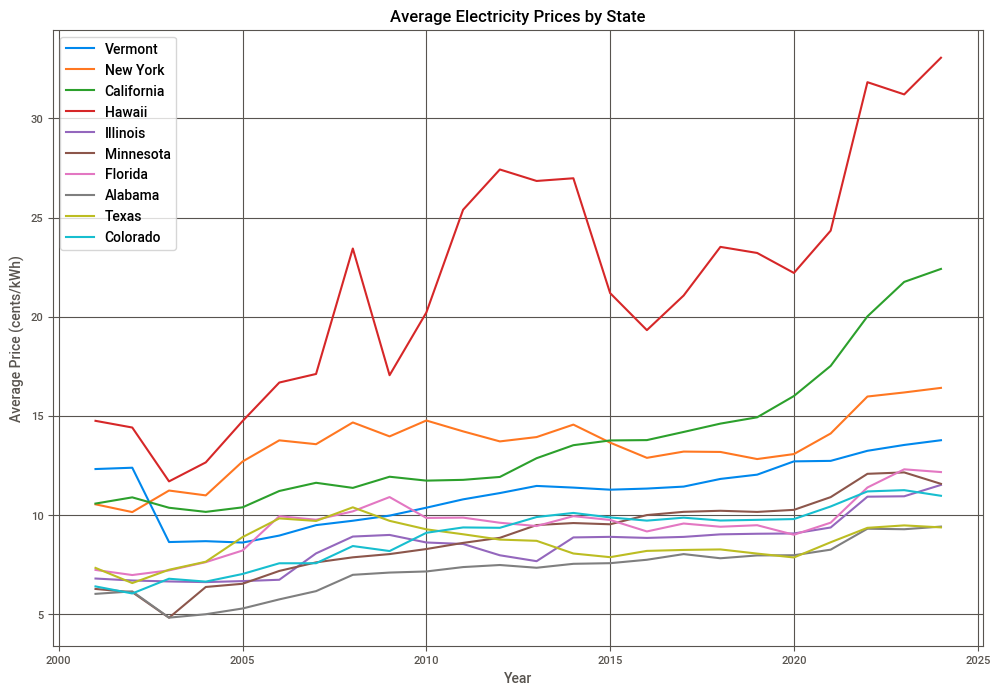

In [ ]:
states = {
    'New England': 'Vermont',
    'Middle Atlantic': 'New York',
    'Pacific Contiguous': 'California',
    'Pacific Noncontiguous': 'Hawaii',
    'East North Central': 'Illinois',
    'West North Central': 'Minnesota',
    'South Atlantic': 'Florida',
    'East South Central': 'Alabama',
    'West South Central': 'Texas',
    'Mountain': 'Colorado'
}

avg_prices = {}

for region, state in states.items():
    state_data = df[df['stateDescription'] == state]
    avg_prices[state] = state_data.groupby('year')['price'].mean()

plt.figure(figsize=(12, 8))
for state, avg_price in avg_prices.items():
    plt.plot(avg_price.index, avg_price.values, label=state)

plt.xlabel('Year')
plt.ylabel('Average Price (cents/kWh)')
plt.title('Average Electricity Prices by State')
plt.legend()
plt.grid(True)
plt.show()


### 3. Data shows strong autocorrelation. (In progress)

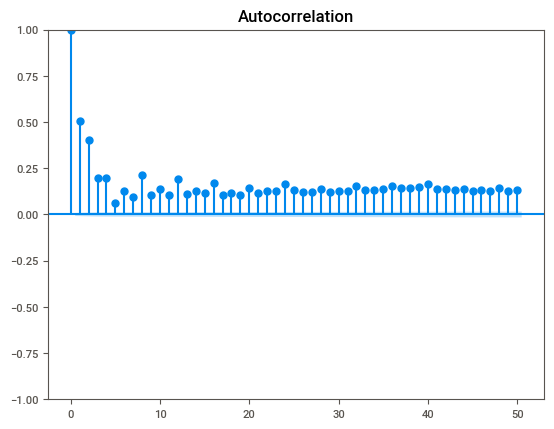

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

series = df_states_new['price']

# LAGS PARAMETER?
plot_acf(series, lags=50)
plt.show()

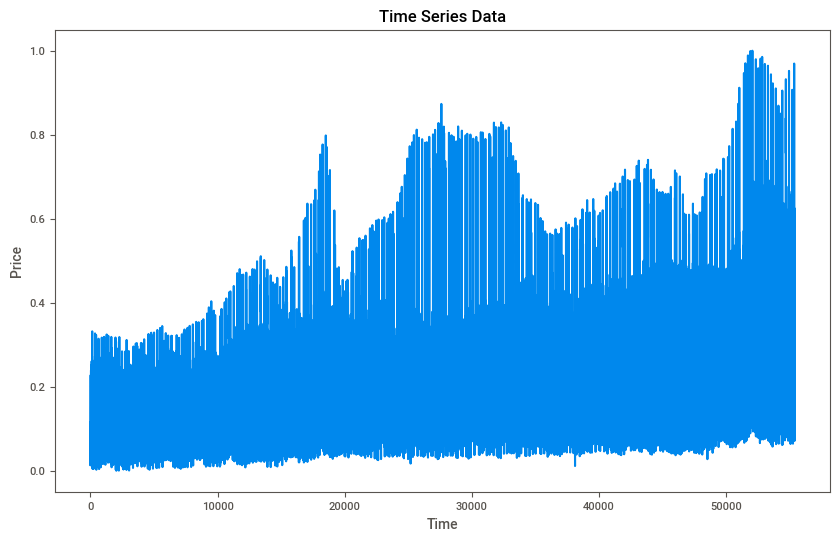

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_states_new['price'])
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()


# **Part 4: Model Selection**

Here, we will test different models and analyze their performances to determine the best one to use.

## Model 1: ARIMA

In [ ]:
# Necessary Imports
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
# Testing if the model is stationary

adf_test = adfuller(df_states_new['price'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

if (adf_test[1] < 0.05):
    print("This dataset is likely to be STATIONARY.")
else:
    print("This dataset is likely to be NOT stationary.")

ADF Statistic: -13.419096
p-value: 0.000000
This dataset is likely to be STATIONARY.


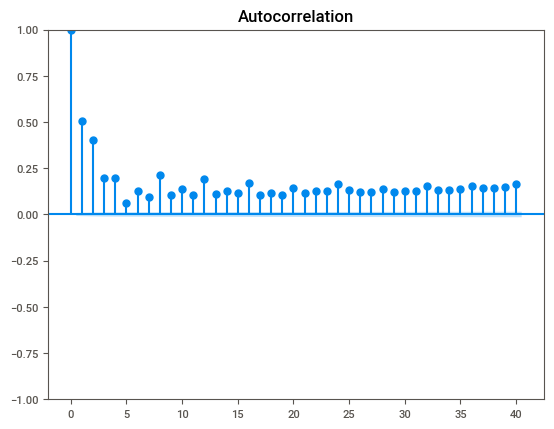

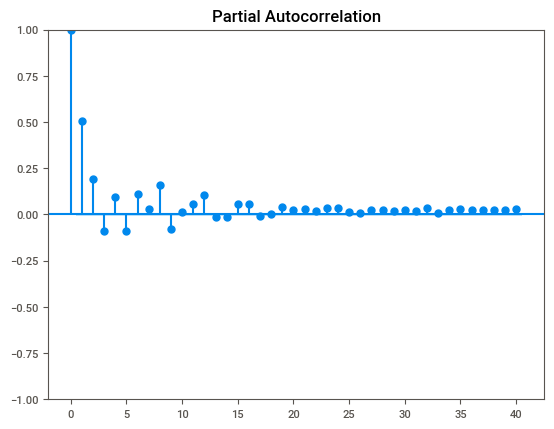

In [ ]:
# Testing which ARIMA parameters are best to use for this dataset
plot_acf(df_states_new['price'], lags=40)
plot_pacf(df_states_new['price'], lags=40)
plt.show()

These charts indicate that ARIMA(1,0,1) is a good model to use.

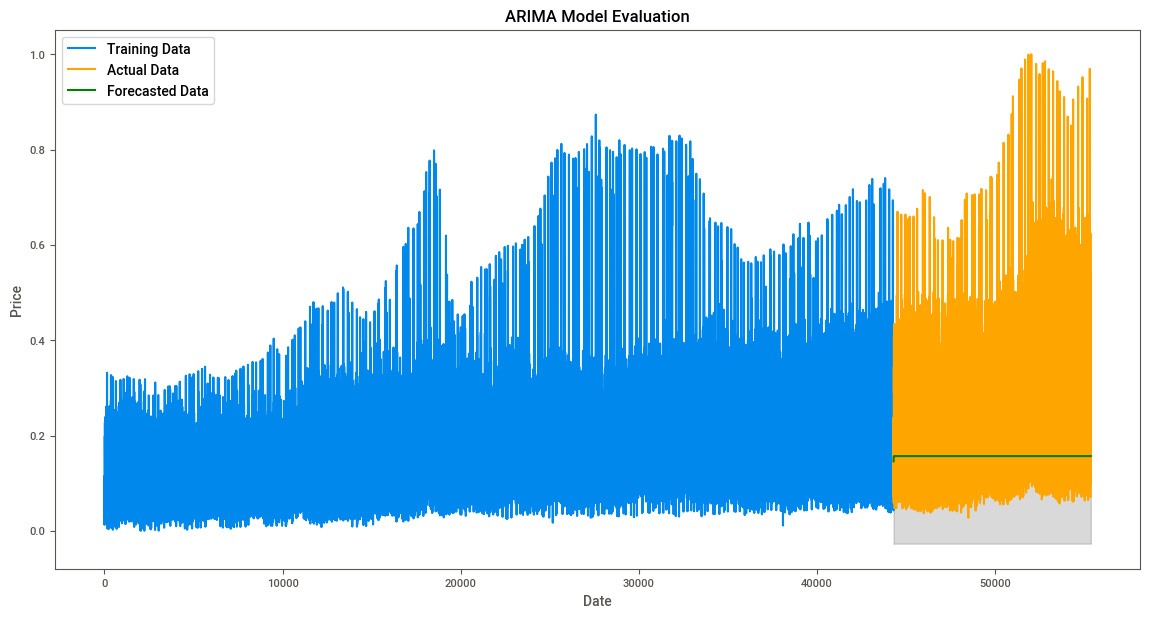

RMSE: 0.1392056278235259


In [ ]:
train_size = int(len(df_states_new) * 0.8)
train, test = df_states_new[0:train_size], df_states_new[train_size:len(df_states_new)]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['price'], order=(1, 0, 1))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = mean_squared_error(test['price'], test_forecast_series)
rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['price'], label='Training Data')
plt.plot(test['price'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print('RMSE:', rmse)

## Model 2: SARIMA (Seasonal ARIMA)

In [ ]:
# Necessary imports
from pandas.plotting import autocorrelation_plot

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

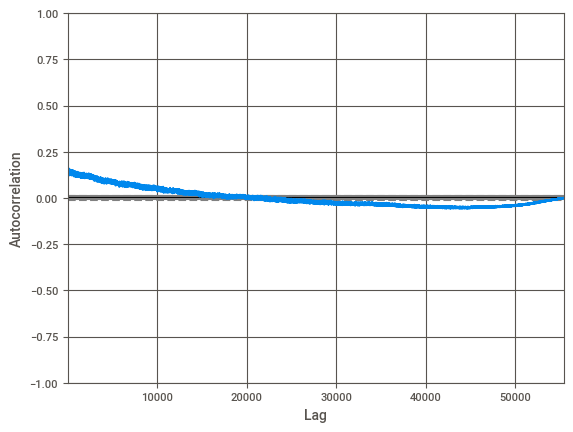

In [ ]:
autocorrelation_plot(df_states_new['price'])

The plot above is suppose to show the lagged version of price compares to the original. To indicate some sense of seasonality, there should be a wave, going up and down.

Since there is a lack of a wave, the seasonality is not obvious and using the SARIMA model will not be as useful.

## Model 3: VAR

In [ ]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


In [ ]:
adf_test(df_states_new['price'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.341910e+01
p-value                 4.224427e-25
# lags used             5.900000e+01
# observations          5.534000e+04
critical value (1%)    -3.430468e+00
critical value (5%)    -2.861592e+00
critical value (10%)   -2.566798e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
adf_test(df_states_new['revenue'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -23.110456
p-value                     0.000000
# lags used                59.000000
# observations          55340.000000
critical value (1%)        -3.430468
critical value (5%)        -2.861592
critical value (10%)       -2.566798
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
adf_test(df_states_new['sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -37.780167
p-value                     0.000000
# lags used                39.000000
# observations          55360.000000
critical value (1%)        -3.430468
critical value (5%)        -2.861592
critical value (10%)       -2.566798
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## Model 4: LSTM

In [ ]:
# Necessary Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [ ]:
y = df_states_new['price']
X = df_states_new.drop(columns = ['price'])

x_train, y_train, x_test, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)


year  Season  customers   revenue     sales  sectorName_all sectors  \
0      2001       0   0.072557  0.006196  0.019782                       1   
1      2001       0   0.072557  0.001084  0.003808                       0   
2      2001       0   0.072557  0.002083  0.010337                       0   
3      2001       0   0.072557  0.001429  0.003873                       0   
4      2001       0   0.072557  0.031823  0.055626                       0   
...     ...     ...        ...       ...       ...                     ...   
55395  2024       0   0.185414  0.054922  0.049563                       0   
55396  2024       0   0.103606  0.063144  0.083791                       1   
55397  2024       0   0.012576  0.013359  0.016784                       0   
55398  2024       0   0.002097  0.015109  0.027812                       0   
55399  2024       0   0.088910  0.033186  0.037729                       0   

       sectorName_commercial  sectorName_industrial  sectorName_residential  \
0                          0                      0                       0   
1                          1                      0                       0   
2                          0                      1                       0   
3                          0                      0                       1   
4                          0                      0                       1   
...                      ...                    ...                     ...   
55395                      0                      0                       1   
55396                      0                      0                       0   
55397                      1                      0                       0   
55398                      0                      1                       0   
55399                      0                      0                       1   

       stateDescription_Alabama  ...  stateDescription_South Dakota  \
0                             0  ...                              0   
1                             0  ...                              0   
2                             0  ...                              0   
3                             0  ...                              0   
4                             0  ...                              0   
...                         ...  ...                            ...   
55395                         0  ...                              0   
55396                         0  ...                              0   
55397                         0  ...                              0   
55398                         0  ...                              0   
55399                         0  ...                              0   

       stateDescription_Tennessee  stateDescription_Texas  \
0                               0                       0   
1                               0                       0   
2                               0                       0   
3                               0                       0   
4                               0                       0   
...                           ...                     ...   
55395                           0                       0   
55396                           0                       0   
55397                           0                       0   
55398                           0                       0   
55399                           0                       0   

       stateDescription_Utah  stateDescription_Vermont  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   
...                      ...                       ...   
55395                      0                         0   
55396                      0                         0   
55397        